In [1]:
# magic
%load_ext autoreload
%autoreload 2 
#any changes to the function files will be updated on every run
#%pdb 1 
#where code fails, stops at that breakpoint and allows to examine potential error
%matplotlib inline

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
from scipy import stats
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture

In [4]:
np.random.seed(6898)

In [5]:
from functions_wasserstein.f_ss_wasserstein import (alpha_stable, alpha_stable_ss, wasserstein_transform, summary_statistics)

## LOAD DATASET

In [6]:
actual_data = alpha_stable(1.5, 0.5, 1, 0, 200, 1)
actual_data

array([[ 1.52525588e+00, -2.05952918e+00, -3.04966385e+00,
        -4.00515580e-02,  2.02172546e+00,  3.76816221e+00,
        -2.70590595e+00,  1.43528216e+00,  1.08090715e+00,
        -1.38793863e+00, -1.28815977e+00, -5.66098969e-01,
        -3.29553455e+00,  1.01780598e+00,  9.91850104e-03,
         3.07331405e+00, -5.15051592e-01, -1.20104133e+00,
        -2.82599986e-01, -1.47057843e+00,  5.39015835e-01,
        -2.95066885e-01, -8.60684103e-01,  1.04254732e+00,
         4.74737565e+00, -4.56241079e-01,  1.92577798e+00,
        -5.22449651e-01,  4.45487138e-02,  9.25132363e-01,
         1.97457197e+00, -2.27873879e+00, -2.69905192e+00,
        -4.83475451e+00,  7.94748760e-01,  5.96387620e-01,
         1.22792653e+00, -4.81013201e+00, -2.22303927e-01,
        -2.30963215e+00, -1.68227689e+00,  2.12062493e+01,
        -1.52593111e+00, -2.70973560e+00,  3.60251911e+00,
        -3.59267882e-01,  3.63442250e-01,  6.39503600e-02,
         1.59599392e-01,  1.81524856e+00,  2.31312669e+0

In [7]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([1.60745225, 0.85671259, 1.16055395, 0.00472989])

In [8]:
# Using previously simulated data for consistency
actual_summary_statistics = np.array([ 1.36495524,  0.27388675,  0.78684313, -0.08169088])

In [9]:
num_coeffs = np.shape(actual_summary_statistics)[0]
num_latent = np.shape(actual_summary_statistics)[0]
num_datasets = 200
n_samples = 200
gamma_samples = 20

In [10]:
from multiprocessing import Pool
from functools import partial
pool = Pool(8)

## Training Wasserstein Gaussianing

In [11]:
wass_num_datasets = 6000
wass_n_samples = 30
maxG = 4

In [12]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.5, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])

In [13]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(wass_num_datasets/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets/3):int(wass_num_datasets * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(wass_num_datasets * 2/3):wass_num_datasets,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

In [14]:
def mixture_model_fit(data, maxG):
    bic_values = []
    for g in np.arange(1, maxG+1):
        mixture_obj = sklearn.mixture.GaussianMixture(n_components = g, reg_covar = 1e-10).fit(data)
        bic_values.append(mixture_obj.bic(data))
    bestG = np.argmin(bic_values) + 1
    best_mixture_obj = sklearn.mixture.GaussianMixture(n_components = bestG, reg_covar = 1e-10).fit(data)
    return best_mixture_obj, bestG

In [15]:
def grad_log_density_mixture(data, mixture_obj):
    mean_mixture_obj = mixture_obj.means_
    sigma_mixture_obj = mixture_obj.covariances_
    weights_mixture_obj = mixture_obj.weights_
    bestG = len(weights_mixture_obj)

    loglh_all_mixture = []
    grad_loglh_all_mixture = []
    for k in range(bestG):
        mean_kth_mixture = mean_mixture_obj[k,:] #1 x g
        sigma_kth_mixture = sigma_mixture_obj[k,:] # g x g
        weight_kth_mixture = weights_mixture_obj[k] 
        diff_mean_kth_mixture = data - mean_kth_mixture #99 x g aux
        loglh_all_mixture.append(np.log(weight_kth_mixture) - num_coeffs/2 * np.log(2 * np.pi)-1/2 * np.log(np.linalg.det(sigma_kth_mixture)) - 1/2 * np.diag(diff_mean_kth_mixture @ np.linalg.inv(sigma_kth_mixture) @ diff_mean_kth_mixture.T)) # 99x99 -> diag:1x99->gx99 lw
        grad_loglh_all_mixture.append(-diff_mean_kth_mixture @ np.linalg.inv(sigma_kth_mixture)) #M =99 x dim of ss =4

    max_llh_all_data = np.max(loglh_all_mixture, axis = 0) # 99 x 1
    aux_llh_all_data = loglh_all_mixture - max_llh_all_data #g x 99
    w_all_data = np.exp(aux_llh_all_data) / np.sum(np.exp(aux_llh_all_data), axis = 0) #g x 99
    log_f = np.log(np.sum(np.exp(aux_llh_all_data), axis = 0)) + max_llh_all_data #99 x 1

    grad_log_f = 0
    for k in range(bestG):    
        grad_log_f = grad_log_f + np.tile(np.reshape(w_all_data[k,:], (len(data),1)),(1,num_coeffs)) * grad_loglh_all_mixture[k] #data x num_coeff
    return log_f, grad_log_f

In [16]:
# At current particles, fit mixture normal
mixture_obj, bestG = mixture_model_fit(wass_train_summary_statistics, maxG)

In [17]:
# Start training

# Hyperparams
patience_max = 20
patience = 0 
stop = 5000
eps = 0.01
t_w = 20

# Initialize empty chain
mixture_obj_seq = [0] * stop
bestG_seq = [0] * stop
mixture_obj_seq[0] = mixture_obj
bestG_seq[0] = bestG
lb = []
LB_Smoothed = []

In [18]:
for t in range(stop):
    stepsize = eps

    train_grad_log_f = grad_log_density_mixture(wass_train_summary_statistics, mixture_obj)[1]
    v = -wass_train_summary_statistics-train_grad_log_f
    wass_train_summary_statistics = wass_train_summary_statistics + stepsize * v

    val_grad_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[1]
    val_log_f = grad_log_density_mixture(wass_val_summary_statistics, mixture_obj)[0]
    v = -wass_val_summary_statistics-val_grad_log_f
    wass_val_summary_statistics = wass_val_summary_statistics + stepsize * v
    h_vector = -1/2 * np.diag(wass_val_summary_statistics @ wass_val_summary_statistics.T) - val_log_f 

    test_grad_log_f = grad_log_density_mixture(wass_test_summary_statistics, mixture_obj)[1]
    v = -wass_test_summary_statistics-test_grad_log_f
    wass_test_summary_statistics = wass_test_summary_statistics + stepsize * v

    # Update new mixture model
    mixture_model = mixture_model_fit(wass_train_summary_statistics, maxG)
    mixture_obj = mixture_model[0]
    bestG = mixture_model[1]

    if min(mixture_obj.weights_) < 0.005:
        mixture_obj = mixture_model_fit(wass_train_summary_statistics, bestG - 1)[0]

    mixture_obj_seq[t+1] = mixture_obj
    bestG_seq[t+1] = bestG

    lb.append(np.mean(h_vector))

    if t < t_w:
        print('LB', np.mean(h_vector))

    if t >= t_w:
        LB_smoothed = np.mean(lb[t - t_w + 1 : t])
        print('LB Smoothed', LB_smoothed)
        LB_Smoothed.append(LB_smoothed)
        if LB_smoothed >= np.max(LB_Smoothed):
            patience = 0
        else:
            patience += 1
            if patience > patience_max:
                print("Stop at", t)
                break

LB -3.115683485236237
LB -8515.449424145874
LB -8341.385298748643
LB -8175.146181281037
LB -8012.249909627619
LB -7852.6028330150775
LB -7696.1564948647365
LB -7542.5882991238805
LB -7392.272510735309
LB -7245.320884358162
LB -7100.750376574407
LB -6959.24452785515
LB -6820.619254007266
LB -6685.056922167435
LB -6551.593590815188
LB -6421.393492396615
LB -6293.178302821558
LB -6167.820216837383
LB -6045.260068678092
LB -5924.838371123343
LB Smoothed -7144.364576798778
LB Smoothed -7001.792186258777
LB Smoothed -6862.305546711939
LB Smoothed -6725.601870674603
LB Smoothed -6591.623443508722
LB Smoothed -6460.300237611755
LB Smoothed -6331.593803212786
LB Smoothed -6205.464436431343
LB Smoothed -6081.847725227959
LB Smoothed -5960.694882284003
LB Smoothed -5841.949775301051
LB Smoothed -5725.572472619563
LB Smoothed -5611.512475299166
LB Smoothed -5499.702799469136
LB Smoothed -5390.139847288914
LB Smoothed -5282.737375624982
LB Smoothed -5177.511589731609
LB Smoothed -5074.362969681791


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

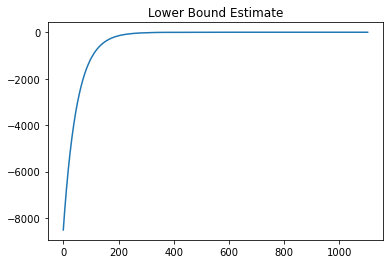

In [19]:
wass_lb_df = pd.DataFrame(np.array(lb[1:]))
plt.figure()
wass_lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

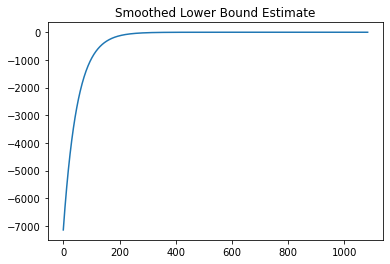

In [20]:
wass_smoothed_lb_df = pd.DataFrame(np.array(LB_Smoothed))
plt.figure()
wass_smoothed_lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

<AxesSubplot:>

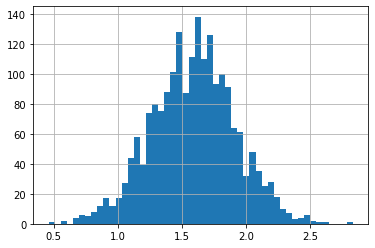

In [21]:
pd.Series(np.random.normal(np.mean(original_train_summary_statistics[:,0]),np.std(original_train_summary_statistics[:,0]), len(original_train_summary_statistics[:,0]))
).hist(bins = 50)

<AxesSubplot:>

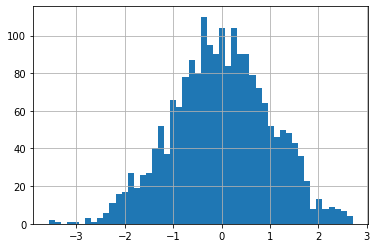

In [22]:
pd.Series(np.random.normal(np.mean(wass_train_summary_statistics[:,0]),np.std(wass_train_summary_statistics[:,0]), len(wass_train_summary_statistics[:,0]))
).hist(bins = 50)

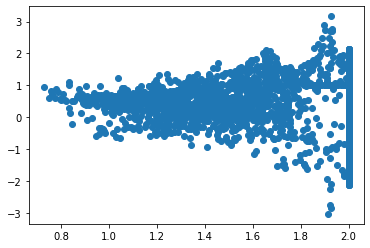

In [23]:
plt.scatter(original_train_summary_statistics[:,0], original_train_summary_statistics[:,1])

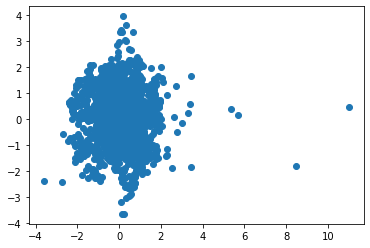

In [24]:
plt.scatter(wass_train_summary_statistics[:,0], wass_train_summary_statistics[:,1])

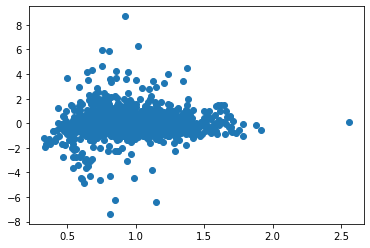

In [25]:
plt.scatter(original_train_summary_statistics[:,2], original_train_summary_statistics[:,3])

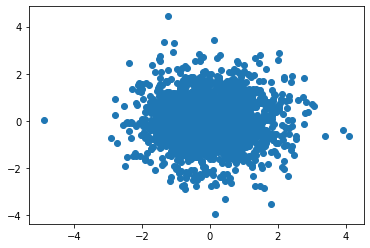

In [26]:
plt.scatter(wass_train_summary_statistics[:,2], wass_train_summary_statistics[:,3])

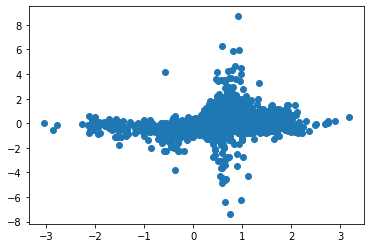

In [27]:
plt.scatter(original_train_summary_statistics[:,1], original_train_summary_statistics[:,3])

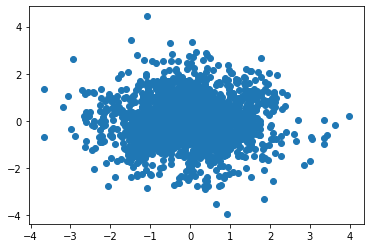

In [28]:
plt.scatter(wass_train_summary_statistics[:,1], wass_train_summary_statistics[:,3])

In [29]:
mixture_obj_seq = [i for i in mixture_obj_seq if i!=0]
mixture_obj_seq = mixture_obj_seq[:-1]
mixture_obj_seq

[GaussianMixture(n_components=4, reg_covar=1e-10),
 GaussianMixture(n_components=4, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3, reg_covar=1e-10),
 GaussianMixture(n_components=3

In [30]:
def wasserstein_transform(mixture_obj_seq, n_summary_statistics):
    for i in range(len(mixture_obj_seq)):
        stepsize = eps
        mixture_obj = mixture_obj_seq[i]
        grad_log_f = grad_log_density_mixture(n_summary_statistics, mixture_obj)[1]
        v = -n_summary_statistics-grad_log_f
        n_summary_statistics = n_summary_statistics + stepsize * v
    return n_summary_statistics

## Testing on dummary data

In [31]:
dataset_dummy = alpha_stable(1.36495524,  0.27388675,  0.78684313, -0.08169088, 30, 4000)
n_summary_statistics_dummy = np.array([alpha_stable_ss(dataset_dummy[i,:]) for i in range(4000)])

In [32]:
transformed = wasserstein_transform(mixture_obj_seq, n_summary_statistics_dummy)

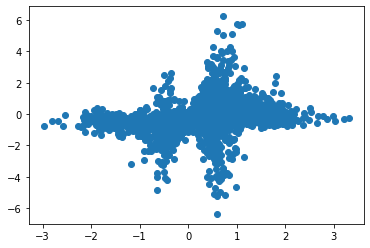

In [33]:
plt.scatter(n_summary_statistics_dummy[:,1], n_summary_statistics_dummy[:,3])

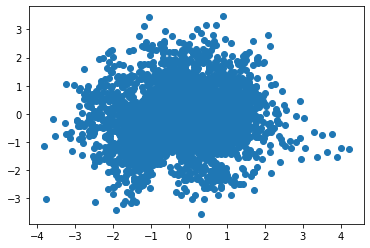

In [34]:
plt.scatter(transformed[:,1], transformed[:,3])

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [39]:
# Functions must be imported for multiprocessing to work
from functions_wasserstein.f_gradient_lb_wasserstein import (fun_gradient_lb)

In [40]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 4 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = np.array([np.log((1.5-1.1)/(2-1.5)),np.log((0.5+1)/(1-0.5)),np.log(1),0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_0_samples, mu_q = mu_0, l_q = l_0, c = 0, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb_init = results[:,0]
                lb_0 = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)

                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)

                # Multiprocessing a function with several inputs
                results = pool.map(partial(fun_gradient_lb, theta_samples = theta_q_samples, mu_q = mu_q, l_q = l_q, c = c, n_samples = n_samples, n_datasets= num_datasets, num_coeffs = self.num_coeffs, actual_summary_statistics = self.actual_summary_statistics, mixture_obj_seq = mixture_obj_seq), np.arange(self.samples)) 
                results = np.reshape(results, (self.samples, 4))
                Gradient_lb = results[:,0]
                lb_t = results[:,1]
                Flattened_gradient_lb = results[:,2]
                Flattened_gradient_log_q = results[:,3]

                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)

                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    print('Lambda', lambda_q)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                        print(lambda_best)
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [41]:
actual_summary_statistics = np.reshape(actual_summary_statistics, (1, len(actual_summary_statistics)))

## RUN VB AND PRINT OUT VARIATIONAL PARAMS

In [42]:
# Set hyperparameters
stop = 5000
transformed_summary_statistics = wasserstein_transform(mixture_obj_seq, actual_summary_statistics)

In [43]:
vb = GVB(400, transformed_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 100, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 0/5000 [00:00<?, ?it/s]/anaconda3/envs/myenv/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
  0%|          | 1/5000 [02:59<248:36:55, 179.04s/it]

LB -15.691646260641576


  0%|          | 2/5000 [05:22<219:33:03, 158.14s/it]

LB -16.111983457969988


  0%|          | 3/5000 [07:45<209:51:54, 151.19s/it]

LB -15.849665210650416


  0%|          | 4/5000 [10:08<205:30:31, 148.08s/it]

LB -15.52192353788174


  0%|          | 5/5000 [12:32<203:07:48, 146.40s/it]

LB -15.298214125929029


  0%|          | 6/5000 [14:54<200:57:42, 144.87s/it]

LB -15.147906048378832


  0%|          | 7/5000 [17:15<199:22:56, 143.76s/it]

LB -14.901502250203645


  0%|          | 8/5000 [19:40<199:51:29, 144.13s/it]

LB -14.986046939948324


  0%|          | 9/5000 [22:03<199:09:08, 143.65s/it]

LB -15.04247370761666


  0%|          | 10/5000 [24:24<198:22:09, 143.11s/it]

LB -14.662668194979187


  0%|          | 11/5000 [26:45<197:21:47, 142.41s/it]

LB -14.585730761989378


  0%|          | 12/5000 [29:07<197:07:56, 142.28s/it]

LB -14.331969165177993


  0%|          | 13/5000 [31:28<196:37:45, 141.94s/it]

LB -14.099732440721873


  0%|          | 14/5000 [33:51<196:38:17, 141.98s/it]

LB -13.885065300898521


  0%|          | 15/5000 [36:13<196:36:23, 141.98s/it]

LB -13.73493909960162


  0%|          | 16/5000 [38:34<196:33:16, 141.97s/it]

LB -13.477398843366865


  0%|          | 17/5000 [40:57<196:47:28, 142.17s/it]

LB -13.511204092381902


  0%|          | 18/5000 [43:19<196:40:41, 142.12s/it]

LB -13.161292962138587


  0%|          | 19/5000 [45:43<197:16:23, 142.58s/it]

LB -13.416400287908344


  0%|          | 20/5000 [48:06<197:39:04, 142.88s/it]

LB -13.17305582085521


  0%|          | 21/5000 [51:02<211:02:44, 152.59s/it]

LB -12.800909412300284


  0%|          | 22/5000 [53:22<206:03:44, 149.02s/it]

LB -12.632791497185092


  0%|          | 23/5000 [55:44<202:52:26, 146.74s/it]

LB -12.744468961844225


  0%|          | 24/5000 [58:05<200:46:53, 145.26s/it]

LB -13.02251198545073


  0%|          | 25/5000 [1:00:27<199:08:25, 144.10s/it]

LB -12.695840555316114


  1%|          | 26/5000 [1:02:49<198:05:02, 143.37s/it]

LB -12.57417377441537


  1%|          | 27/5000 [1:05:12<197:59:24, 143.33s/it]

LB -12.559146633210187


  1%|          | 28/5000 [1:07:33<197:04:23, 142.69s/it]

LB -12.501062849209172


  1%|          | 29/5000 [1:09:54<196:28:30, 142.29s/it]

LB -12.667011052772683


  1%|          | 30/5000 [1:12:16<196:19:47, 142.21s/it]

LB -12.454739227923753


  1%|          | 31/5000 [1:14:39<196:33:50, 142.41s/it]

LB -12.310042644837779


  1%|          | 32/5000 [1:17:01<196:03:16, 142.07s/it]

LB -12.10420518436873


  1%|          | 33/5000 [1:19:23<196:18:23, 142.28s/it]

LB -12.202851652788295


  1%|          | 34/5000 [1:21:47<196:41:15, 142.58s/it]

LB -12.385633358705801


  1%|          | 35/5000 [1:24:10<197:09:05, 142.95s/it]

LB -12.145423738428763


  1%|          | 36/5000 [1:26:32<196:31:33, 142.52s/it]

LB -12.37400781811117


  1%|          | 37/5000 [1:28:55<196:50:11, 142.78s/it]

LB -12.13691519161956


  1%|          | 38/5000 [1:31:17<196:16:52, 142.40s/it]

LB -12.084582828337215


  1%|          | 39/5000 [1:33:39<196:12:56, 142.39s/it]

LB -12.276059984415738


  1%|          | 40/5000 [1:36:02<196:25:17, 142.56s/it]

LB -12.195644999796666


  1%|          | 41/5000 [1:38:25<196:28:57, 142.64s/it]

LB -12.03836995185269


  1%|          | 42/5000 [1:40:48<196:48:02, 142.90s/it]

LB -11.864519004163187


  1%|          | 43/5000 [1:43:10<196:02:31, 142.37s/it]

LB -12.182480538344178


  1%|          | 44/5000 [1:45:31<195:30:15, 142.01s/it]

LB -12.178594266288956


  1%|          | 45/5000 [1:47:54<196:00:15, 142.40s/it]

LB -12.298290046529768


  1%|          | 46/5000 [1:50:21<197:46:43, 143.72s/it]

LB -12.242391492134242


  1%|          | 47/5000 [1:52:46<198:06:17, 143.99s/it]

LB -12.102592814151427


  1%|          | 48/5000 [1:55:10<198:12:00, 144.09s/it]

LB -12.043883536782818


  1%|          | 49/5000 [1:57:32<197:33:20, 143.65s/it]

LB -12.005723748870958


  1%|          | 50/5000 [1:59:53<196:22:45, 142.82s/it]

LB -12.027065585218741


  1%|          | 51/5000 [2:02:15<195:45:08, 142.39s/it]

LB -12.035385521022556


  1%|          | 52/5000 [2:04:36<195:25:58, 142.19s/it]

LB -11.992569854454864


  1%|          | 53/5000 [2:06:59<195:21:20, 142.16s/it]

LB -11.998128974510152


  1%|          | 54/5000 [2:09:21<195:15:18, 142.12s/it]

LB -11.92317979553955


  1%|          | 55/5000 [2:11:41<194:35:53, 141.67s/it]

LB -12.1417694265448


  1%|          | 56/5000 [2:14:03<194:48:31, 141.85s/it]

LB -11.762758917582262


  1%|          | 57/5000 [2:16:26<194:54:31, 141.95s/it]

LB -11.82206920839805


  1%|          | 58/5000 [2:18:49<195:26:43, 142.37s/it]

LB -11.981713308411383


  1%|          | 59/5000 [2:21:12<195:46:53, 142.65s/it]

LB -11.806706441074935


  1%|          | 60/5000 [2:23:33<194:55:28, 142.05s/it]

LB -12.043296345193829


  1%|          | 61/5000 [2:25:56<195:23:48, 142.42s/it]

LB -12.071603716923718


  1%|          | 62/5000 [2:28:18<195:00:38, 142.17s/it]

LB -11.838881897639492


  1%|▏         | 63/5000 [2:30:41<195:17:42, 142.41s/it]

LB -12.130859412903774


  1%|▏         | 64/5000 [2:33:04<195:41:33, 142.73s/it]

LB -12.027747612555636


  1%|▏         | 65/5000 [2:35:25<195:01:17, 142.27s/it]

LB -11.666158751139681


  1%|▏         | 66/5000 [2:37:46<194:22:54, 141.83s/it]

LB -12.003821014287896


  1%|▏         | 67/5000 [2:40:08<194:23:12, 141.86s/it]

LB -11.990819482333643


  1%|▏         | 68/5000 [2:42:31<194:33:10, 142.01s/it]

LB -11.7947574807509


  1%|▏         | 69/5000 [2:44:53<194:30:36, 142.01s/it]

LB -11.811919568895455


  1%|▏         | 70/5000 [2:47:16<194:56:35, 142.35s/it]

LB -11.882885085894099


  1%|▏         | 71/5000 [2:49:41<195:57:04, 143.12s/it]

LB -11.975241390632531


  1%|▏         | 72/5000 [2:52:48<213:59:37, 156.33s/it]

LB -11.742425915310713


  1%|▏         | 73/5000 [2:55:12<208:59:33, 152.70s/it]

LB -11.959001741130962


  1%|▏         | 74/5000 [2:57:35<205:08:02, 149.92s/it]

LB -11.828955772692598


  2%|▏         | 75/5000 [2:59:59<202:41:28, 148.16s/it]

LB -11.803507924343855


  2%|▏         | 76/5000 [3:02:24<201:13:52, 147.12s/it]

LB -11.783255065654249


  2%|▏         | 77/5000 [3:04:49<200:07:12, 146.34s/it]

LB -11.772304477447976


  2%|▏         | 78/5000 [3:07:13<199:10:12, 145.68s/it]

LB -11.702831287088413


  2%|▏         | 79/5000 [3:09:37<198:34:33, 145.27s/it]

LB -11.828349694489622


  2%|▏         | 80/5000 [3:12:00<197:28:34, 144.49s/it]

LB -11.78822704059754


  2%|▏         | 81/5000 [3:14:24<197:07:11, 144.26s/it]

LB -11.903506865267072


  2%|▏         | 82/5000 [3:16:47<196:37:51, 143.93s/it]

LB -11.83514494098567


  2%|▏         | 83/5000 [3:19:10<196:27:01, 143.83s/it]

LB -11.734037865426126


  2%|▏         | 84/5000 [3:21:36<197:19:31, 144.50s/it]

LB -11.723672429840432


  2%|▏         | 85/5000 [3:23:59<196:29:22, 143.92s/it]

LB -11.768863342394972


  2%|▏         | 86/5000 [3:26:22<196:14:31, 143.77s/it]

LB -11.753403304043047


  2%|▏         | 87/5000 [3:28:46<195:57:28, 143.59s/it]

LB -11.758012016119787


  2%|▏         | 88/5000 [3:31:10<196:14:05, 143.82s/it]

LB -11.909106149453924


  2%|▏         | 89/5000 [3:33:34<196:08:07, 143.78s/it]

LB -11.642780919762693


  2%|▏         | 90/5000 [3:35:57<195:53:31, 143.63s/it]

LB -11.518265954068582


  2%|▏         | 91/5000 [3:38:22<196:26:20, 144.06s/it]

LB -11.648226137256856


  2%|▏         | 92/5000 [3:40:46<196:29:30, 144.13s/it]

LB -11.722060409556136


  2%|▏         | 93/5000 [3:43:11<196:49:51, 144.40s/it]

LB -11.626581229561566


  2%|▏         | 94/5000 [3:45:36<196:57:44, 144.53s/it]

LB -11.729794865907326


  2%|▏         | 95/5000 [3:48:02<197:41:34, 145.10s/it]

LB -11.591123565324828


  2%|▏         | 96/5000 [3:51:01<211:08:33, 155.00s/it]

LB -11.440253140586403


  2%|▏         | 97/5000 [3:53:25<206:39:37, 151.74s/it]

LB -11.906580999845184


  2%|▏         | 98/5000 [3:55:50<203:52:57, 149.73s/it]

LB -11.494093204981345


  2%|▏         | 99/5000 [3:58:14<201:39:38, 148.13s/it]

LB -11.539471265810374


  2%|▏         | 100/5000 [4:00:39<200:16:08, 147.14s/it]

LB -11.43579684445878


  2%|▏         | 101/5000 [4:03:04<199:17:55, 146.45s/it]

LB Smoothed -12.478212264243115
Lambda [array([-0.43937884,  0.92707107, -0.17418227, -0.15807338])
 array([10.49912175,  0.49909069,  0.49902753,  0.4990724 ,  9.50002702,
        -0.49997426, -0.49997646, 10.46316889,  0.4014616 , 10.44811071])]
[array([-0.43937884,  0.92707107, -0.17418227, -0.15807338])
 array([10.49912175,  0.49909069,  0.49902753,  0.4990724 ,  9.50002702,
        -0.49997426, -0.49997646, 10.46316889,  0.4014616 , 10.44811071])]


  2%|▏         | 102/5000 [4:05:28<198:10:04, 145.65s/it]

LB Smoothed -12.431595906223617
Lambda [array([-0.4410642 ,  0.92485461, -0.17467861, -0.15773535])
 array([10.50411152,  0.50408001,  0.50401713,  0.50406193,  9.49502777,
        -0.50497353, -0.50497576, 10.46816093,  0.4064527 , 10.45310342])]
[array([-0.4410642 ,  0.92485461, -0.17467861, -0.15773535])
 array([10.50411152,  0.50408001,  0.50401713,  0.50406193,  9.49502777,
        -0.50497353, -0.50497576, 10.46816093,  0.4064527 , 10.45310342])]


  2%|▏         | 103/5000 [4:07:55<198:53:09, 146.21s/it]

LB Smoothed -12.386716308705722
Lambda [array([-0.44273509,  0.9230698 , -0.17511496, -0.15676153])
 array([10.50910156,  0.50906947,  0.50900692,  0.50905161,  9.4900285 ,
        -0.50997278, -0.50997506, 10.47315276,  0.41144352, 10.45809684])]
[array([-0.44273509,  0.9230698 , -0.17511496, -0.15676153])
 array([10.50910156,  0.50906947,  0.50900692,  0.50905161,  9.4900285 ,
        -0.50997278, -0.50997506, 10.47315276,  0.41144352, 10.45809684])]


  2%|▏         | 104/5000 [4:10:20<198:23:47, 145.88s/it]

LB Smoothed -12.347196047488397
Lambda [array([-0.44407852,  0.92106012, -0.1758554 , -0.15526357])
 array([10.51409173,  0.51405925,  0.51399703,  0.51404143,  9.48502924,
        -0.51497202, -0.51497439, 10.47814488,  0.41643417, 10.46309085])]
[array([-0.44407852,  0.92106012, -0.1758554 , -0.15526357])
 array([10.51409173,  0.51405925,  0.51399703,  0.51404143,  9.48502924,
        -0.51497202, -0.51497439, 10.47814488,  0.41643417, 10.46309085])]


  2%|▏         | 105/5000 [4:12:44<197:40:25, 145.38s/it]

LB Smoothed -12.307729739394873
Lambda [array([-0.44489349,  0.92012864, -0.17678933, -0.15353235])
 array([10.51908222,  0.51904916,  0.5189875 ,  0.51903164,  9.48002995,
        -0.51997122, -0.51997369, 10.48313708,  0.42142506, 10.46808547])]
[array([-0.44489349,  0.92012864, -0.17678933, -0.15353235])
 array([10.51908222,  0.51904916,  0.5189875 ,  0.51903164,  9.48002995,
        -0.51997122, -0.51997369, 10.48313708,  0.42142506, 10.46808547])]


  2%|▏         | 106/5000 [4:15:09<197:07:32, 145.00s/it]

LB Smoothed -12.27192810866575
Lambda [array([-0.44574278,  0.91879886, -0.17662385, -0.152242  ])
 array([10.52407314,  0.52403957,  0.52397804,  0.52402228,  9.4750307 ,
        -0.52497049, -0.52497297, 10.48812903,  0.42641609, 10.47308058])]
[array([-0.44574278,  0.91879886, -0.17662385, -0.152242  ])
 array([10.52407314,  0.52403957,  0.52397804,  0.52402228,  9.4750307 ,
        -0.52497049, -0.52497297, 10.48812903,  0.42641609, 10.47308058])]


  2%|▏         | 107/5000 [4:17:31<196:08:44, 144.31s/it]

LB Smoothed -12.237575143378315
Lambda [array([-0.44689164,  0.91715041, -0.17569239, -0.150254  ])
 array([10.52906457,  0.52903057,  0.5289689 ,  0.52901325,  9.47003151,
        -0.52996978, -0.52997228, 10.49312067,  0.43140718, 10.47807613])]
[array([-0.44689164,  0.91715041, -0.17569239, -0.150254  ])
 array([10.52906457,  0.52903057,  0.5289689 ,  0.52901325,  9.47003151,
        -0.52996978, -0.52997228, 10.49312067,  0.43140718, 10.47807613])]


  2%|▏         | 108/5000 [4:19:56<196:19:05, 144.47s/it]

LB Smoothed -12.20390468690042
Lambda [array([-0.44840885,  0.91578787, -0.17542928, -0.14914271])
 array([10.53405628,  0.53402178,  0.53396022,  0.53400465,  9.46503226,
        -0.53496906, -0.53497158, 10.49811272,  0.43639865, 10.48307194])]
[array([-0.44840885,  0.91578787, -0.17542928, -0.14914271])
 array([10.53405628,  0.53402178,  0.53396022,  0.53400465,  9.46503226,
        -0.53496906, -0.53497158, 10.49811272,  0.43639865, 10.48307194])]


  2%|▏         | 109/5000 [4:22:26<198:36:18, 146.18s/it]

LB Smoothed -12.168169199085016
Lambda [array([-0.44971798,  0.91393561, -0.17518639, -0.14843806])
 array([10.5390482 ,  0.53901339,  0.53895189,  0.53899635,  9.46003301,
        -0.53996838, -0.53997089, 10.50310517,  0.44139063, 10.48806811])]
[array([-0.44971798,  0.91393561, -0.17518639, -0.14843806])
 array([10.5390482 ,  0.53901339,  0.53895189,  0.53899635,  9.46003301,
        -0.53996838, -0.53997089, 10.50310517,  0.44139063, 10.48806811])]


  2%|▏         | 110/5000 [4:24:51<198:10:14, 145.89s/it]

LB Smoothed -12.135404071168756
Lambda [array([-0.45018693,  0.9126169 , -0.17408169, -0.14731077])
 array([10.54404052,  0.54400532,  0.54394383,  0.54398851,  9.45503374,
        -0.54496773, -0.54497017, 10.50809796,  0.44638322, 10.4930643 ])]
[array([-0.45018693,  0.9126169 , -0.17408169, -0.14731077])
 array([10.54404052,  0.54400532,  0.54394383,  0.54398851,  9.45503374,
        -0.54496773, -0.54497017, 10.50809796,  0.44638322, 10.4930643 ])]


  2%|▏         | 111/5000 [4:27:16<197:39:58, 145.55s/it]

LB Smoothed -12.10468184224122
Lambda [array([-0.45129489,  0.91164478, -0.17272225, -0.14575108])
 array([10.54903334,  0.54899761,  0.54893615,  0.54898094,  9.45003443,
        -0.5499671 , -0.54996949, 10.51309134,  0.45137632, 10.49806067])]
[array([-0.45129489,  0.91164478, -0.17272225, -0.14575108])
 array([10.54903334,  0.54899761,  0.54893615,  0.54898094,  9.45003443,
        -0.5499671 , -0.54996949, 10.51309134,  0.45137632, 10.49806067])]


  2%|▏         | 112/5000 [4:29:42<197:47:37, 145.67s/it]

LB Smoothed -12.075784812620533
Lambda [array([-0.45181033,  0.91096704, -0.17144469, -0.14428557])
 array([10.55402635,  0.55399015,  0.5539288 ,  0.55397375,  9.44503507,
        -0.55496649, -0.55496882, 10.51808533,  0.45637005, 10.50305715])]
[array([-0.45181033,  0.91096704, -0.17144469, -0.14428557])
 array([10.55402635,  0.55399015,  0.5539288 ,  0.55397375,  9.44503507,
        -0.55496649, -0.55496882, 10.51808533,  0.45637005, 10.50305715])]


  2%|▏         | 113/5000 [4:32:08<197:35:46, 145.56s/it]

LB Smoothed -12.048236649248372
Lambda [array([-0.45301415,  0.91045836, -0.16972346, -0.14270011])
 array([10.55901981,  0.55898306,  0.55892175,  0.55896693,  9.44003569,
        -0.55996592, -0.55996818, 10.52307991,  0.46136438, 10.50805355])]
[array([-0.45301415,  0.91045836, -0.16972346, -0.14270011])
 array([10.55901981,  0.55898306,  0.55892175,  0.55896693,  9.44003569,
        -0.55996592, -0.55996818, 10.52307991,  0.46136438, 10.50805355])]


  2%|▏         | 114/5000 [4:34:34<197:50:04, 145.76s/it]

LB Smoothed -12.022609066295956
Lambda [array([-0.45447648,  0.90931638, -0.16916233, -0.14111739])
 array([10.56401352,  0.56397641,  0.56391517,  0.56396039,  9.43503629,
        -0.56496532, -0.56496759, 10.52807502,  0.46635927, 10.51304978])]
[array([-0.45447648,  0.90931638, -0.16916233, -0.14111739])
 array([10.56401352,  0.56397641,  0.56391517,  0.56396039,  9.43503629,
        -0.56496532, -0.56496759, 10.52807502,  0.46635927, 10.51304978])]


  2%|▏         | 115/5000 [4:36:59<197:24:31, 145.48s/it]

LB Smoothed -12.00127751566317
Lambda [array([-0.45648165,  0.90777857, -0.16905455, -0.13970269])
 array([10.56900754,  0.56897012,  0.5689089 ,  0.5689541 ,  9.43003687,
        -0.56996474, -0.56996704, 10.53307062,  0.47135466, 10.51804586])]
[array([-0.45648165,  0.90777857, -0.16905455, -0.13970269])
 array([10.56900754,  0.56897012,  0.5689089 ,  0.5689541 ,  9.43003687,
        -0.56996474, -0.56996704, 10.53307062,  0.47135466, 10.51804586])]


  2%|▏         | 116/5000 [4:39:23<196:59:43, 145.21s/it]

LB Smoothed -11.981128020361751
Lambda [array([-0.4586697 ,  0.90676144, -0.1692001 , -0.13807713])
 array([10.57400185,  0.57396399,  0.57390293,  0.57394806,  9.4250374 ,
        -0.57496417, -0.57496651, 10.53806664,  0.47635052, 10.52304176])]
[array([-0.4586697 ,  0.90676144, -0.1692001 , -0.13807713])
 array([10.57400185,  0.57396399,  0.57390293,  0.57394806,  9.4250374 ,
        -0.57496417, -0.57496651, 10.53806664,  0.47635052, 10.52304176])]


  2%|▏         | 117/5000 [4:41:48<196:42:25, 145.02s/it]

LB Smoothed -11.959832092797285
Lambda [array([-0.46123673,  0.90557632, -0.16992498, -0.13661421])
 array([10.57899637,  0.57895809,  0.57889727,  0.57894229,  9.42003791,
        -0.5799636 , -0.57996601, 10.54306305,  0.48134678, 10.52803737])]
[array([-0.46123673,  0.90557632, -0.16992498, -0.13661421])
 array([10.57899637,  0.57895809,  0.57889727,  0.57894229,  9.42003791,
        -0.5799636 , -0.57996601, 10.54306305,  0.48134678, 10.52803737])]


  2%|▏         | 118/5000 [4:44:13<196:35:31, 144.97s/it]

LB Smoothed -11.940715621024673
Lambda [array([-0.46308823,  0.90445965, -0.16972542, -0.13467438])
 array([10.58399106,  0.58395242,  0.58389171,  0.58393674,  9.41503844,
        -0.58496306, -0.58496549, 10.5480598 ,  0.48634343, 10.53303264])]
[array([-0.46308823,  0.90445965, -0.16972542, -0.13467438])
 array([10.58399106,  0.58395242,  0.58389171,  0.58393674,  9.41503844,
        -0.58496306, -0.58496549, 10.5480598 ,  0.48634343, 10.53303264])]


  2%|▏         | 119/5000 [4:46:38<196:34:45, 144.99s/it]

LB Smoothed -11.920364193962461
Lambda [array([-0.46512793,  0.90312987, -0.16976752, -0.1328138 ])
 array([10.58898581,  0.58894693,  0.58888631,  0.58893131,  9.41003895,
        -0.58996254, -0.589965  , 10.55305687,  0.49134038, 10.53802686])]
[array([-0.46512793,  0.90312987, -0.16976752, -0.1328138 ])
 array([10.58898581,  0.58894693,  0.58888631,  0.58893131,  9.41003895,
        -0.58996254, -0.589965  , 10.55305687,  0.49134038, 10.53802686])]


  2%|▏         | 120/5000 [4:49:06<197:47:29, 145.91s/it]

LB Smoothed -11.901698334075954
Lambda [array([-0.46567643,  0.9013783 , -0.16978494, -0.13049411])
 array([10.59398052,  0.59394166,  0.59388104,  0.59392599,  9.40503949,
        -0.59496202, -0.59496453, 10.55805424,  0.49633764, 10.54302018])]
[array([-0.46567643,  0.9013783 , -0.16978494, -0.13049411])
 array([10.59398052,  0.59394166,  0.59388104,  0.59392599,  9.40503949,
        -0.59496202, -0.59496453, 10.55805424,  0.49633764, 10.54302018])]


  2%|▏         | 121/5000 [4:51:36<199:26:25, 147.16s/it]

LB Smoothed -11.88768884097281
Lambda [array([-0.46705824,  0.90012748, -0.17022326, -0.12931452])
 array([10.59897556,  0.59893643,  0.59887601,  0.59892092,  9.40003999,
        -0.5999615 , -0.59996404, 10.56305187,  0.50133517, 10.54801191])]
[array([-0.46705824,  0.90012748, -0.17022326, -0.12931452])
 array([10.59897556,  0.59893643,  0.59887601,  0.59892092,  9.40003999,
        -0.5999615 , -0.59996404, 10.56305187,  0.50133517, 10.54801191])]


  2%|▏         | 122/5000 [4:54:13<203:20:32, 150.07s/it]

LB Smoothed -11.87509343911304
Lambda [array([-0.46846232,  0.89923406, -0.17146067, -0.12751428])
 array([10.60397074,  0.60393134,  0.60387129,  0.60391589,  9.39504047,
        -0.60496088, -0.60496358, 10.56804974,  0.50633288, 10.55300273])]
[array([-0.46846232,  0.89923406, -0.17146067, -0.12751428])
 array([10.60397074,  0.60393134,  0.60387129,  0.60391589,  9.39504047,
        -0.60496088, -0.60496358, 10.56804974,  0.50633288, 10.55300273])]


  2%|▏         | 123/5000 [4:56:36<200:39:35, 148.12s/it]

LB Smoothed -11.860887077158706
Lambda [array([-0.47026666,  0.89810624, -0.17183682, -0.12535289])
 array([10.60896622,  0.60892651,  0.60886652,  0.60891106,  9.39004098,
        -0.60996031, -0.60996312, 10.57304766,  0.5113308 , 10.55799224])]
[array([-0.47026666,  0.89810624, -0.17183682, -0.12535289])
 array([10.60896622,  0.60892651,  0.60886652,  0.60891106,  9.39004098,
        -0.60996031, -0.60996312, 10.57304766,  0.5113308 , 10.55799224])]


  2%|▏         | 124/5000 [4:59:02<199:51:42, 147.56s/it]

LB Smoothed -11.845629493851055
Lambda [array([-0.4725003 ,  0.89692713, -0.17218581, -0.12284433])
 array([10.61396189,  0.61392182,  0.61386188,  0.6139063 ,  9.38504149,
        -0.61495975, -0.61496268, 10.57804578,  0.51632887, 10.56298078])]
[array([-0.4725003 ,  0.89692713, -0.17218581, -0.12284433])
 array([10.61396189,  0.61392182,  0.61386188,  0.6139063 ,  9.38504149,
        -0.61495975, -0.61496268, 10.57804578,  0.51632887, 10.56298078])]


  2%|▎         | 125/5000 [5:01:27<198:35:34, 146.65s/it]

LB Smoothed -11.831114760120247
Lambda [array([-0.47498677,  0.89499629, -0.17277179, -0.12087699])
 array([10.61895759,  0.61891735,  0.61885726,  0.61890164,  9.38004206,
        -0.61995921, -0.61996225, 10.58304402,  0.521327  , 10.56796745])]
[array([-0.47498677,  0.89499629, -0.17277179, -0.12087699])
 array([10.61895759,  0.61891735,  0.61885726,  0.61890164,  9.38004206,
        -0.61995921, -0.61996225, 10.58304402,  0.521327  , 10.56796745])]


  3%|▎         | 126/5000 [5:03:50<197:15:05, 145.69s/it]

LB Smoothed -11.818646084827376
Lambda [array([-0.47749244,  0.89330117, -0.17391499, -0.11843398])
 array([10.62395337,  0.62391289,  0.62385287,  0.62389691,  9.37504261,
        -0.6249586 , -0.62496184, 10.58804244,  0.52632517, 10.57295247])]
[array([-0.47749244,  0.89330117, -0.17391499, -0.11843398])
 array([10.62395337,  0.62391289,  0.62385287,  0.62389691,  9.37504261,
        -0.6249586 , -0.62496184, 10.58804244,  0.52632517, 10.57295247])]


  3%|▎         | 127/5000 [5:06:15<196:47:51, 145.39s/it]

LB Smoothed -11.806800203544665
Lambda [array([-0.48034729,  0.89125786, -0.17528966, -0.11571492])
 array([10.62894927,  0.62890852,  0.62884855,  0.62889217,  9.37004319,
        -0.62995798, -0.62996144, 10.59304089,  0.53132338, 10.57793557])]
[array([-0.48034729,  0.89125786, -0.17528966, -0.11571492])
 array([10.62894927,  0.62890852,  0.62884855,  0.62889217,  9.37004319,
        -0.62995798, -0.62996144, 10.59304089,  0.53132338, 10.57793557])]


  3%|▎         | 128/5000 [5:08:40<196:25:31, 145.14s/it]

LB Smoothed -11.795515598439572
Lambda [array([-0.48345019,  0.88910338, -0.17626458, -0.11399405])
 array([10.63394518,  0.63390407,  0.63384401,  0.63388758,  9.36504377,
        -0.63495741, -0.63496096, 10.59803915,  0.53632167, 10.58291677])]
[array([-0.48345019,  0.88910338, -0.17626458, -0.11399405])
 array([10.63394518,  0.63390407,  0.63384401,  0.63388758,  9.36504377,
        -0.63495741, -0.63496096, 10.59803915,  0.53632167, 10.58291677])]


  3%|▎         | 129/5000 [5:11:04<196:12:36, 145.01s/it]

LB Smoothed -11.782839234154089
Lambda [array([-0.48670523,  0.8866532 , -0.17715601, -0.11272785])
 array([10.63894091,  0.63889957,  0.63883928,  0.63888295,  9.36004436,
        -0.63995685, -0.63996045, 10.60303728,  0.54131986, 10.58789495])]
[array([-0.48670523,  0.8866532 , -0.17715601, -0.11272785])
 array([10.63894091,  0.63889957,  0.63883928,  0.63888295,  9.36004436,
        -0.63995685, -0.63996045, 10.60303728,  0.54131986, 10.58789495])]


  3%|▎         | 130/5000 [5:13:31<196:49:09, 145.49s/it]

LB Smoothed -11.771269936551311
Lambda [array([-0.49002795,  0.88427869, -0.17791181, -0.11136895])
 array([10.64393653,  0.64389488,  0.64383443,  0.64387814,  9.35504497,
        -0.64495629, -0.64495992, 10.60803528,  0.54631788, 10.59287118])]
[array([-0.49002795,  0.88427869, -0.17791181, -0.11136895])
 array([10.64393653,  0.64389488,  0.64383443,  0.64387814,  9.35504497,
        -0.64495629, -0.64495992, 10.60803528,  0.54631788, 10.59287118])]


  3%|▎         | 131/5000 [5:15:58<197:20:08, 145.90s/it]

LB Smoothed -11.762114258132708
Lambda [array([-0.49324353,  0.88217845, -0.17907261, -0.11094093])
 array([10.64893186,  0.64888995,  0.64882947,  0.6488733 ,  9.35004556,
        -0.64995569, -0.6499593 , 10.61303327,  0.55131588, 10.59784547])]
[array([-0.49324353,  0.88217845, -0.17907261, -0.11094093])
 array([10.64893186,  0.64888995,  0.64882947,  0.6488733 ,  9.35004556,
        -0.64995569, -0.6499593 , 10.61303327,  0.55131588, 10.59784547])]


  3%|▎         | 132/5000 [5:18:23<197:05:54, 145.76s/it]

LB Smoothed -11.75448677502826
Lambda [array([-0.49660494,  0.87987818, -0.17976586, -0.1108189 ])
 array([10.65392699,  0.65388486,  0.65382414,  0.65386831,  9.3450462 ,
        -0.6549551 , -0.65495862, 10.61803124,  0.55631379, 10.60281858])]
[array([-0.49660494,  0.87987818, -0.17976586, -0.1108189 ])
 array([10.65392699,  0.65388486,  0.65382414,  0.65386831,  9.3450462 ,
        -0.6549551 , -0.65495862, 10.61803124,  0.55631379, 10.60281858])]


  3%|▎         | 133/5000 [5:20:47<196:06:23, 145.06s/it]

LB Smoothed -11.743275537037805
Lambda [array([-0.5001603 ,  0.87739318, -0.18111906, -0.11153854])
 array([10.65892194,  0.65887955,  0.6588187 ,  0.6588632 ,  9.34004688,
        -0.65995441, -0.65995784, 10.62302915,  0.56131166, 10.60779137])]
[array([-0.5001603 ,  0.87739318, -0.18111906, -0.11153854])
 array([10.65892194,  0.65887955,  0.6588187 ,  0.6588632 ,  9.34004688,
        -0.65995441, -0.65995784, 10.62302915,  0.56131166, 10.60779137])]


  3%|▎         | 134/5000 [5:23:14<197:06:20, 145.82s/it]

LB Smoothed -11.732505350355822
Lambda [array([-0.50379158,  0.87473821, -0.18223612, -0.11214008])
 array([10.6639169 ,  0.66387408,  0.66381304,  0.66385789,  9.33504765,
        -0.66495367, -0.664957  , 10.62802683,  0.56630934, 10.61276451])]
[array([-0.50379158,  0.87473821, -0.18223612, -0.11214008])
 array([10.6639169 ,  0.66387408,  0.66381304,  0.66385789,  9.33504765,
        -0.66495367, -0.664957  , 10.62802683,  0.56630934, 10.61276451])]


  3%|▎         | 135/5000 [5:25:38<196:13:35, 145.20s/it]

LB Smoothed -11.723900966136792
Lambda [array([-0.50751524,  0.87229541, -0.18309305, -0.11300941])
 array([10.66891161,  0.66886826,  0.66880715,  0.66885233,  9.33004844,
        -0.6699529 , -0.66995607, 10.6330241 ,  0.57130695, 10.61773874])]
[array([-0.50751524,  0.87229541, -0.18309305, -0.11300941])
 array([10.66891161,  0.66886826,  0.66880715,  0.66885233,  9.33004844,
        -0.6699529 , -0.66995607, 10.6330241 ,  0.57130695, 10.61773874])]


  3%|▎         | 136/5000 [5:28:02<195:47:32, 144.91s/it]

LB Smoothed -11.71507255663958
Lambda [array([-0.51119879,  0.86954733, -0.18439065, -0.11337097])
 array([10.67390594,  0.67386222,  0.67380113,  0.67384633,  9.32504934,
        -0.67495201, -0.67495514, 10.63802139,  0.57630408, 10.62271454])]
[array([-0.51119879,  0.86954733, -0.18439065, -0.11337097])
 array([10.67390594,  0.67386222,  0.67380113,  0.67384633,  9.32504934,
        -0.67495201, -0.67495514, 10.63802139,  0.57630408, 10.62271454])]


  3%|▎         | 137/5000 [5:30:26<195:26:45, 144.69s/it]

LB Smoothed -11.705859252844363
Lambda [array([-0.51490454,  0.86649946, -0.18540661, -0.11458253])
 array([10.67889988,  0.67885599,  0.67879465,  0.67884022,  9.32005039,
        -0.67995112, -0.67995403, 10.64301834,  0.58130107, 10.62769153])]
[array([-0.51490454,  0.86649946, -0.18540661, -0.11458253])
 array([10.67889988,  0.67885599,  0.67879465,  0.67884022,  9.32005039,
        -0.67995112, -0.67995403, 10.64301834,  0.58130107, 10.62769153])]


  3%|▎         | 138/5000 [5:32:50<194:54:35, 144.32s/it]

LB Smoothed -11.697306368357323
Lambda [array([-0.51820477,  0.86365644, -0.18670056, -0.11528683])
 array([10.6838934 ,  0.6838494 ,  0.68378799,  0.68383365,  9.31505149,
        -0.68495007, -0.68495289, 10.64801523,  0.58629758, 10.63267028])]
[array([-0.51820477,  0.86365644, -0.18670056, -0.11528683])
 array([10.6838934 ,  0.6838494 ,  0.68378799,  0.68383365,  9.31505149,
        -0.68495007, -0.68495289, 10.64801523,  0.58629758, 10.63267028])]


  3%|▎         | 139/5000 [5:35:14<194:54:27, 144.35s/it]

LB Smoothed -11.686131412096994
Lambda [array([-0.52012753,  0.86065446, -0.18687308, -0.11547428])
 array([10.68888657,  0.68884273,  0.688781  ,  0.68882693,  9.31005282,
        -0.68994896, -0.68995162, 10.65301186,  0.59129393, 10.63765078])]
[array([-0.52012753,  0.86065446, -0.18687308, -0.11547428])
 array([10.68888657,  0.68884273,  0.688781  ,  0.68882693,  9.31005282,
        -0.68994896, -0.68995162, 10.65301186,  0.59129393, 10.63765078])]


  3%|▎         | 140/5000 [5:37:38<194:34:06, 144.12s/it]

LB Smoothed -11.675945019156014
Lambda [array([-0.52211888,  0.85756649, -0.18627778, -0.11589828])
 array([10.69387962,  0.6938359 ,  0.69377358,  0.69382015,  9.30505423,
        -0.69494783, -0.69495022, 10.6580083 ,  0.59629021, 10.64263283])]
[array([-0.52211888,  0.85756649, -0.18627778, -0.11589828])
 array([10.69387962,  0.6938359 ,  0.69377358,  0.69382015,  9.30505423,
        -0.69494783, -0.69495022, 10.6580083 ,  0.59629021, 10.64263283])]


  3%|▎         | 141/5000 [5:40:04<195:21:18, 144.74s/it]

LB Smoothed -11.666812524399134
Lambda [array([-0.52393374,  0.85455537, -0.18504991, -0.11577487])
 array([10.69887263,  0.69882897,  0.69876593,  0.69881314,  9.30005575,
        -0.69994666, -0.69994876, 10.66300456,  0.60128648, 10.64761654])]
[array([-0.52393374,  0.85455537, -0.18504991, -0.11577487])
 array([10.69887263,  0.69882897,  0.69876593,  0.69881314,  9.30005575,
        -0.69994666, -0.69994876, 10.66300456,  0.60128648, 10.64761654])]


  3%|▎         | 142/5000 [5:42:29<195:12:43, 144.66s/it]

LB Smoothed -11.661063187166913
Lambda [array([-0.52614051,  0.85129053, -0.18330582, -0.11623023])
 array([10.70386569,  0.70382206,  0.70375805,  0.70380616,  9.29505739,
        -0.70494548, -0.70494714, 10.66800071,  0.606283  , 10.65260161])]
[array([-0.52614051,  0.85129053, -0.18330582, -0.11623023])
 array([10.70386569,  0.70382206,  0.70375805,  0.70380616,  9.29505739,
        -0.70494548, -0.70494714, 10.66800071,  0.606283  , 10.65260161])]


  3%|▎         | 143/5000 [5:44:53<195:13:17, 144.70s/it]

LB Smoothed -11.653473595107641
Lambda [array([-0.52861138,  0.84781911, -0.18118681, -0.11715416])
 array([10.70885873,  0.7088151 ,  0.70875001,  0.70879918,  9.29005909,
        -0.70994429, -0.70994544, 10.67299707,  0.61127978, 10.65758807])]
[array([-0.52861138,  0.84781911, -0.18118681, -0.11715416])
 array([10.70885873,  0.7088151 ,  0.70875001,  0.70879918,  9.29005909,
        -0.70994429, -0.70994544, 10.67299707,  0.61127978, 10.65758807])]


  3%|▎         | 144/5000 [5:47:21<196:24:20, 145.61s/it]

LB Smoothed -11.643806303586283
Lambda [array([-0.5313059 ,  0.84434164, -0.17910134, -0.11864954])
 array([10.71385165,  0.71380792,  0.71374193,  0.71379221,  9.28506077,
        -0.71494303, -0.71494367, 10.67799374,  0.61627688, 10.66257587])]
[array([-0.5313059 ,  0.84434164, -0.17910134, -0.11864954])
 array([10.71385165,  0.71380792,  0.71374193,  0.71379221,  9.28506077,
        -0.71494303, -0.71494367, 10.67799374,  0.61627688, 10.66257587])]


  3%|▎         | 145/5000 [5:50:06<204:14:22, 151.44s/it]

LB Smoothed -11.632640266799477
Lambda [array([-0.53365562,  0.84070117, -0.17710588, -0.11893801])
 array([10.71884441,  0.71880065,  0.71873402,  0.71878487,  9.28006259,
        -0.7199416 , -0.71994196, 10.68299072,  0.62127421, 10.66756488])]
[array([-0.53365562,  0.84070117, -0.17710588, -0.11893801])
 array([10.71884441,  0.71880065,  0.71873402,  0.71878487,  9.28006259,
        -0.7199416 , -0.71994196, 10.68299072,  0.62127421, 10.66756488])]


  3%|▎         | 146/5000 [5:52:35<203:03:24, 150.60s/it]

LB Smoothed -11.620171651805148
Lambda [array([-0.53625703,  0.83722332, -0.17569382, -0.1187011 ])
 array([10.72383713,  0.72379321,  0.7237263 ,  0.72377714,  9.27506441,
        -0.72493998, -0.7249403 , 10.68798791,  0.62627179, 10.67255475])]
[array([-0.53625703,  0.83722332, -0.17569382, -0.1187011 ])
 array([10.72383713,  0.72379321,  0.7237263 ,  0.72377714,  9.27506441,
        -0.72493998, -0.7249403 , 10.68798791,  0.62627179, 10.67255475])]


  3%|▎         | 147/5000 [5:54:59<200:35:39, 148.80s/it]

LB Smoothed -11.609205386840086
Lambda [array([-0.53882881,  0.83404994, -0.17363057, -0.11837287])
 array([10.72882998,  0.72878586,  0.72871837,  0.72876965,  9.27006633,
        -0.72993838, -0.7299384 , 10.69298537,  0.63126944, 10.67754563])]
[array([-0.53882881,  0.83404994, -0.17363057, -0.11837287])
 array([10.72882998,  0.72878586,  0.72871837,  0.72876965,  9.27006633,
        -0.72993838, -0.7299384 , 10.69298537,  0.63126944, 10.67754563])]


  3%|▎         | 148/5000 [5:57:23<198:31:19, 147.30s/it]

LB Smoothed -11.600040911056562
Lambda [array([-0.54046371,  0.83090484, -0.17195966, -0.11860762])
 array([10.73382231,  0.73377828,  0.73371051,  0.73376216,  9.26506824,
        -0.73493669, -0.73493644, 10.69798302,  0.6362671 , 10.68253743])]
[array([-0.54046371,  0.83090484, -0.17195966, -0.11860762])
 array([10.73382231,  0.73377828,  0.73371051,  0.73376216,  9.26506824,
        -0.73493669, -0.73493644, 10.69798302,  0.6362671 , 10.68253743])]


  3%|▎         | 149/5000 [5:59:47<197:08:27, 146.30s/it]

LB Smoothed -11.592067215003876
Lambda [array([-0.5426042 ,  0.8277286 , -0.170759  , -0.11938045])
 array([10.73881469,  0.73877083,  0.7387027 ,  0.73875467,  9.26007025,
        -0.73993492, -0.73993444, 10.7029807 ,  0.64126478, 10.68753003])]
[array([-0.5426042 ,  0.8277286 , -0.170759  , -0.11938045])
 array([10.73881469,  0.73877083,  0.7387027 ,  0.73875467,  9.26007025,
        -0.73993492, -0.73993444, 10.7029807 ,  0.64126478, 10.68753003])]


  3%|▎         | 150/5000 [6:02:13<196:57:22, 146.19s/it]

LB Smoothed -11.584687620709081
Lambda [array([-0.54436576,  0.82434997, -0.17007302, -0.11970736])
 array([10.74380682,  0.74376336,  0.74369507,  0.74374692,  9.25507233,
        -0.74493303, -0.74493253, 10.70797834,  0.64626251, 10.6925232 ])]
[array([-0.54436576,  0.82434997, -0.17007302, -0.11970736])
 array([10.74380682,  0.74376336,  0.74369507,  0.74374692,  9.25507233,
        -0.74493303, -0.74493253, 10.70797834,  0.64626251, 10.6925232 ])]


  3%|▎         | 151/5000 [6:04:39<196:41:08, 146.02s/it]

LB Smoothed -11.574536453818578
Lambda [array([-0.54630143,  0.82162478, -0.16970016, -0.11995612])
 array([10.74879901,  0.74875565,  0.74868758,  0.74873913,  9.25007432,
        -0.74993105, -0.74993062, 10.71297598,  0.65126034, 10.69751697])]
[array([-0.54630143,  0.82162478, -0.16970016, -0.11995612])
 array([10.74879901,  0.74875565,  0.74868758,  0.74873913,  9.25007432,
        -0.74993105, -0.74993062, 10.71297598,  0.65126034, 10.69751697])]


  3%|▎         | 152/5000 [6:07:03<196:08:41, 145.65s/it]

LB Smoothed -11.566113464975208
Lambda [array([-0.54783101,  0.81895229, -0.16974922, -0.12051245])
 array([10.75379109,  0.75374789,  0.75368021,  0.75373145,  9.24507627,
        -0.75492903, -0.75492868, 10.71797367,  0.65625822, 10.70251123])]
[array([-0.54783101,  0.81895229, -0.16974922, -0.12051245])
 array([10.75379109,  0.75374789,  0.75368021,  0.75373145,  9.24507627,
        -0.75492903, -0.75492868, 10.71797367,  0.65625822, 10.70251123])]


  3%|▎         | 153/5000 [6:09:30<196:20:44, 145.83s/it]

LB Smoothed -11.557140296527832
Lambda [array([-0.54982379,  0.81645997, -0.17043551, -0.12053514])
 array([10.75878349,  0.75874019,  0.75867312,  0.75872376,  9.24007823,
        -0.75992686, -0.7599268 , 10.72297142,  0.66125628, 10.70750567])]
[array([-0.54982379,  0.81645997, -0.17043551, -0.12053514])
 array([10.75878349,  0.75874019,  0.75867312,  0.75872376,  9.24007823,
        -0.75992686, -0.7599268 , 10.72297142,  0.66125628, 10.70750567])]


  3%|▎         | 154/5000 [6:11:56<196:24:04, 145.90s/it]

LB Smoothed -11.549618568706741
Lambda [array([-0.55186079,  0.81367802, -0.17182222, -0.12088919])
 array([10.76377585,  0.76373281,  0.76366629,  0.76371618,  9.23508036,
        -0.76492458, -0.7649249 , 10.72796932,  0.66625446, 10.71250052])]
[array([-0.55186079,  0.81367802, -0.17182222, -0.12088919])
 array([10.76377585,  0.76373281,  0.76366629,  0.76371618,  9.23508036,
        -0.76492458, -0.7649249 , 10.72796932,  0.66625446, 10.71250052])]


  3%|▎         | 155/5000 [6:14:22<196:25:00, 145.94s/it]

LB Smoothed -11.540225208005927
Lambda [array([-0.55371271,  0.81104847, -0.17315592, -0.12196696])
 array([10.76876828,  0.76872545,  0.76865939,  0.7687089 ,  9.23008245,
        -0.76992237, -0.76992287, 10.73296743,  0.67125278, 10.71749579])]
[array([-0.55371271,  0.81104847, -0.17315592, -0.12196696])
 array([10.76876828,  0.76872545,  0.76865939,  0.7687089 ,  9.23008245,
        -0.76992237, -0.76992287, 10.73296743,  0.67125278, 10.71749579])]


  3%|▎         | 156/5000 [6:16:46<195:33:41, 145.34s/it]

LB Smoothed -11.53312223555067
Lambda [array([-0.55533173,  0.80813849, -0.17470476, -0.12257233])
 array([10.77376079,  0.77371828,  0.77365261,  0.77370155,  9.22508462,
        -0.77492014, -0.77492089, 10.73796572,  0.67625125, 10.72249122])]
[array([-0.55533173,  0.80813849, -0.17470476, -0.12257233])
 array([10.77376079,  0.77371828,  0.77365261,  0.77370155,  9.22508462,
        -0.77492014, -0.77492089, 10.73796572,  0.67625125, 10.72249122])]


  3%|▎         | 157/5000 [6:19:10<195:15:24, 145.14s/it]

LB Smoothed -11.524214635834152
Lambda [array([-0.55657983,  0.80550884, -0.17636212, -0.12322857])
 array([10.77875343,  0.77871116,  0.77864592,  0.77869439,  9.22008672,
        -0.77991791, -0.7799189 , 10.74296416,  0.68124982, 10.72748685])]
[array([-0.55657983,  0.80550884, -0.17636212, -0.12322857])
 array([10.77875343,  0.77871116,  0.77864592,  0.77869439,  9.22008672,
        -0.77991791, -0.7799189 , 10.74296416,  0.68124982, 10.72748685])]


  3%|▎         | 158/5000 [6:21:36<195:20:17, 145.23s/it]

LB Smoothed -11.514400303252097
Lambda [array([-0.55786812,  0.8030178 , -0.17725178, -0.1238295 ])
 array([10.78374641,  0.78370422,  0.78363924,  0.78368748,  9.21508883,
        -0.78491578, -0.78491683, 10.74796252,  0.68624845, 10.7324828 ])]
[array([-0.55786812,  0.8030178 , -0.17725178, -0.1238295 ])
 array([10.78374641,  0.78370422,  0.78363924,  0.78368748,  9.21508883,
        -0.78491578, -0.78491683, 10.74796252,  0.68624845, 10.7324828 ])]


  3%|▎         | 159/5000 [6:24:00<194:38:45, 144.75s/it]

LB Smoothed -11.507191949696034
Lambda [array([-0.55949962,  0.80017482, -0.17803196, -0.12427096])
 array([10.78873963,  0.7886976 ,  0.78863265,  0.78868072,  9.21009102,
        -0.78991367, -0.78991479, 10.75296087,  0.69124692, 10.73747876])]
[array([-0.55949962,  0.80017482, -0.17803196, -0.12427096])
 array([10.78873963,  0.7886976 ,  0.78863265,  0.78868072,  9.21009102,
        -0.78991367, -0.78991479, 10.75296087,  0.69124692, 10.73747876])]


  3%|▎         | 160/5000 [6:26:26<195:10:52, 145.18s/it]

LB Smoothed -11.497711484651973
Lambda [array([-0.56019276,  0.79771184, -0.17919869, -0.12408677])
 array([10.79373298,  0.7936911 ,  0.79362637,  0.79367412,  9.20509316,
        -0.79491142, -0.79491277, 10.75795932,  0.69624524, 10.74247475])]
[array([-0.56019276,  0.79771184, -0.17919869, -0.12408677])
 array([10.79373298,  0.7936911 ,  0.79362637,  0.79367412,  9.20509316,
        -0.79491142, -0.79491277, 10.75795932,  0.69624524, 10.74247475])]


  3%|▎         | 161/5000 [6:28:50<194:49:31, 144.94s/it]

LB Smoothed -11.486459425691669
Lambda [array([-0.56090177,  0.79550738, -0.17979125, -0.12404102])
 array([10.79872665,  0.79868478,  0.79862014,  0.79866781,  9.20009527,
        -0.79990924, -0.79991071, 10.76295745,  0.70124353, 10.74747086])]
[array([-0.56090177,  0.79550738, -0.17979125, -0.12404102])
 array([10.79872665,  0.79868478,  0.79862014,  0.79866781,  9.20009527,
        -0.79990924, -0.79991071, 10.76295745,  0.70124353, 10.74747086])]


  3%|▎         | 162/5000 [6:31:15<194:49:13, 144.97s/it]

LB Smoothed -11.479057301068812
Lambda [array([-0.5608665 ,  0.79306059, -0.18020402, -0.12456267])
 array([10.80372041,  0.8036787 ,  0.80361406,  0.80366181,  9.19509741,
        -0.80490715, -0.8049086 , 10.76795554,  0.70624178, 10.75246709])]
[array([-0.5608665 ,  0.79306059, -0.18020402, -0.12456267])
 array([10.80372041,  0.8036787 ,  0.80361406,  0.80366181,  9.19509741,
        -0.80490715, -0.8049086 , 10.76795554,  0.70624178, 10.75246709])]


  3%|▎         | 163/5000 [6:33:39<194:21:58, 144.66s/it]

LB Smoothed -11.46633851696566
Lambda [array([-0.56095987,  0.79073634, -0.18090632, -0.12486176])
 array([10.80871443,  0.80867282,  0.80860828,  0.808656  ,  9.19009947,
        -0.80990506, -0.80990655, 10.77295358,  0.71123977, 10.75746347])]
[array([-0.56095987,  0.79073634, -0.18090632, -0.12486176])
 array([10.80871443,  0.80867282,  0.80860828,  0.808656  ,  9.19009947,
        -0.80990506, -0.80990655, 10.77295358,  0.71123977, 10.75746347])]


  3%|▎         | 164/5000 [6:36:03<194:04:21, 144.47s/it]

LB Smoothed -11.455469556597109
Lambda [array([-0.56159046,  0.7881242 , -0.1816066 , -0.12535936])
 array([10.8137088 ,  0.8136672 ,  0.81360269,  0.81365044,  9.18510153,
        -0.81490304, -0.81490455, 10.77795138,  0.71623753, 10.76245992])]
[array([-0.56159046,  0.7881242 , -0.1816066 , -0.12535936])
 array([10.8137088 ,  0.8136672 ,  0.81360269,  0.81365044,  9.18510153,
        -0.81490304, -0.81490455, 10.77795138,  0.71623753, 10.76245992])]


  3%|▎         | 165/5000 [6:38:28<194:09:16, 144.56s/it]

LB Smoothed -11.448719040500206
Lambda [array([-0.56154089,  0.78528892, -0.18151731, -0.12632696])
 array([10.81870337,  0.81866192,  0.81859725,  0.81864527,  9.18010361,
        -0.81990114, -0.8199025 , 10.78294908,  0.72123526, 10.76745653])]
[array([-0.56154089,  0.78528892, -0.18151731, -0.12632696])
 array([10.81870337,  0.81866192,  0.81859725,  0.81864527,  9.18010361,
        -0.81990114, -0.8199025 , 10.78294908,  0.72123526, 10.76745653])]


  3%|▎         | 166/5000 [6:40:54<194:33:14, 144.89s/it]

LB Smoothed -11.436640717377166
Lambda [array([-0.56215331,  0.78248048, -0.18240639, -0.12651325])
 array([10.82369829,  0.82365691,  0.82359226,  0.82364024,  9.17510566,
        -0.82489904, -0.82490056, 10.78794687,  0.72623268, 10.77245291])]
[array([-0.56215331,  0.78248048, -0.18240639, -0.12651325])
 array([10.82369829,  0.82365691,  0.82359226,  0.82364024,  9.17510566,
        -0.82489904, -0.82490056, 10.78794687,  0.72623268, 10.77245291])]


  3%|▎         | 167/5000 [6:43:18<194:17:28, 144.72s/it]

LB Smoothed -11.426238246349188
Lambda [array([-0.56281047,  0.78057147, -0.18377738, -0.12634383])
 array([10.8286935 ,  0.82865205,  0.82858764,  0.82863542,  9.17010759,
        -0.82989688, -0.82989869, 10.79294458,  0.73122982, 10.77744917])]
[array([-0.56281047,  0.78057147, -0.18377738, -0.12634383])
 array([10.8286935 ,  0.82865205,  0.82858764,  0.82863542,  9.17010759,
        -0.82989688, -0.82989869, 10.79294458,  0.73122982, 10.77744917])]


  3%|▎         | 168/5000 [6:45:42<193:58:39, 144.52s/it]

LB Smoothed -11.417593099700229
Lambda [array([-0.56362291,  0.77843127, -0.18442778, -0.12585099])
 array([10.833689  ,  0.8336475 ,  0.83358314,  0.83363085,  9.16510954,
        -0.83489486, -0.83489684, 10.79794193,  0.73622672, 10.7824454 ])]
[array([-0.56362291,  0.77843127, -0.18442778, -0.12585099])
 array([10.833689  ,  0.8336475 ,  0.83358314,  0.83363085,  9.16510954,
        -0.83489486, -0.83489684, 10.79794193,  0.73622672, 10.7824454 ])]


  3%|▎         | 169/5000 [6:48:19<199:10:53, 148.43s/it]

LB Smoothed -11.407646288347724
Lambda [array([-0.56482344,  0.77618889, -0.18577069, -0.12567514])
 array([10.8386847 ,  0.83864315,  0.83857899,  0.83862649,  9.16011142,
        -0.83989277, -0.83989503, 10.80293929,  0.74122334, 10.78744182])]
[array([-0.56482344,  0.77618889, -0.18577069, -0.12567514])
 array([10.8386847 ,  0.83864315,  0.83857899,  0.83862649,  9.16011142,
        -0.83989277, -0.83989503, 10.80293929,  0.74122334, 10.78744182])]


  3%|▎         | 170/5000 [6:50:48<199:10:39, 148.46s/it]

LB Smoothed -11.397291489496855
Lambda [array([-0.56661596,  0.77437541, -0.18732053, -0.12641137])
 array([10.84368068,  0.84363892,  0.84357504,  0.84362242,  9.1551132 ,
        -0.84489073, -0.84489319, 10.80793633,  0.74621983, 10.79243849])]
[array([-0.56661596,  0.77437541, -0.18732053, -0.12641137])
 array([10.84368068,  0.84363892,  0.84357504,  0.84362242,  9.1551132 ,
        -0.84489073, -0.84489319, 10.80793633,  0.74621983, 10.79243849])]


  3%|▎         | 171/5000 [6:53:16<198:47:14, 148.20s/it]

LB Smoothed -11.387732960543227
Lambda [array([-0.56832774,  0.77205074, -0.18841453, -0.1270065 ])
 array([10.84867677,  0.84863499,  0.84857114,  0.84861851,  9.15011509,
        -0.84988881, -0.84989138, 10.81293297,  0.75121607, 10.79743523])]
[array([-0.56832774,  0.77205074, -0.18841453, -0.1270065 ])
 array([10.84867677,  0.84863499,  0.84857114,  0.84861851,  9.15011509,
        -0.84988881, -0.84989138, 10.81293297,  0.75121607, 10.79743523])]


  3%|▎         | 172/5000 [6:55:40<197:19:25, 147.13s/it]

LB Smoothed -11.378485376279524
Lambda [array([-0.57045664,  0.76947014, -0.18835732, -0.12802055])
 array([10.85367318,  0.85363135,  0.85356721,  0.8536149 ,  9.14511708,
        -0.85488701, -0.85488941, 10.81792886,  0.75621239, 10.80243211])]
[array([-0.57045664,  0.76947014, -0.18835732, -0.12802055])
 array([10.85367318,  0.85363135,  0.85356721,  0.8536149 ,  9.14511708,
        -0.85488701, -0.85488941, 10.81792886,  0.75621239, 10.80243211])]


  3%|▎         | 173/5000 [6:58:04<195:52:02, 146.08s/it]

LB Smoothed -11.36905935907229
Lambda [array([-0.57193823,  0.76681672, -0.18795983, -0.12924588])
 array([10.85866961,  0.85862781,  0.85856332,  0.85861144,  9.14011905,
        -0.85988528, -0.85988743, 10.82292443,  0.76120872, 10.80742895])]
[array([-0.57193823,  0.76681672, -0.18795983, -0.12924588])
 array([10.85866961,  0.85862781,  0.85856332,  0.85861144,  9.14011905,
        -0.85988528, -0.85988743, 10.82292443,  0.76120872, 10.80742895])]


  3%|▎         | 174/5000 [7:00:27<194:43:54, 145.26s/it]

LB Smoothed -11.360363173000053
Lambda [array([-0.57361496,  0.76463789, -0.18755653, -0.12937941])
 array([10.86366624,  0.86362427,  0.86355961,  0.86360795,  9.13512098,
        -0.86488348, -0.86488552, 10.82792024,  0.7662049 , 10.8124255 ])]
[array([-0.57361496,  0.76463789, -0.18755653, -0.12937941])
 array([10.86366624,  0.86362427,  0.86355961,  0.86360795,  9.13512098,
        -0.86488348, -0.86488552, 10.82792024,  0.7662049 , 10.8124255 ])]


  4%|▎         | 175/5000 [7:02:50<193:48:24, 144.60s/it]

LB Smoothed -11.35011617723587
Lambda [array([-0.57485704,  0.76211586, -0.18668294, -0.12886518])
 array([10.86866296,  0.86862092,  0.86855592,  0.86860454,  9.13012303,
        -0.86988172, -0.86988366, 10.83291615,  0.77120104, 10.8174221 ])]
[array([-0.57485704,  0.76211586, -0.18668294, -0.12886518])
 array([10.86866296,  0.86862092,  0.86855592,  0.86860454,  9.13012303,
        -0.86988172, -0.86988366, 10.83291615,  0.77120104, 10.8174221 ])]


  4%|▎         | 176/5000 [7:05:14<193:21:59, 144.30s/it]

LB Smoothed -11.340167825786638
Lambda [array([-0.5761586 ,  0.75966157, -0.18553896, -0.1284708 ])
 array([10.87365977,  0.87361757,  0.87355222,  0.87360124,  9.12512502,
        -0.87487999, -0.87488178, 10.8379121 ,  0.77619744, 10.82241876])]
[array([-0.5761586 ,  0.75966157, -0.18553896, -0.1284708 ])
 array([10.87365977,  0.87361757,  0.87355222,  0.87360124,  9.12512502,
        -0.87487999, -0.87488178, 10.8379121 ,  0.77619744, 10.82241876])]


  4%|▎         | 177/5000 [7:07:37<192:59:08, 144.05s/it]

LB Smoothed -11.332187928938332
Lambda [array([-0.57786245,  0.75687137, -0.18410347, -0.12770818])
 array([10.87865668,  0.87861437,  0.87854859,  0.87859797,  9.12012704,
        -0.87987829, -0.87987995, 10.84290839,  0.78119401, 10.82741554])]
[array([-0.57786245,  0.75687137, -0.18410347, -0.12770818])
 array([10.87865668,  0.87861437,  0.87854859,  0.87859797,  9.12012704,
        -0.87987829, -0.87987995, 10.84290839,  0.78119401, 10.82741554])]


  4%|▎         | 178/5000 [7:10:03<193:32:35, 144.50s/it]

LB Smoothed -11.322286144537836
Lambda [array([-0.57977101,  0.75392345, -0.18267521, -0.12756769])
 array([10.8836536 ,  0.88361118,  0.883545  ,  0.88359478,  9.11512903,
        -0.88487661, -0.88487809, 10.84790502,  0.7861909 , 10.83241258])]
[array([-0.57977101,  0.75392345, -0.18267521, -0.12756769])
 array([10.8836536 ,  0.88361118,  0.883545  ,  0.88359478,  9.11512903,
        -0.88487661, -0.88487809, 10.84790502,  0.7861909 , 10.83241258])]


  4%|▎         | 179/5000 [7:12:28<193:44:45, 144.68s/it]

LB Smoothed -11.312330130931976
Lambda [array([-0.58181102,  0.75094626, -0.1807363 , -0.12722324])
 array([10.88865063,  0.88860805,  0.8885414 ,  0.88859167,  9.11013106,
        -0.88987495, -0.8898762 , 10.85290197,  0.7911881 , 10.83740987])]
[array([-0.58181102,  0.75094626, -0.1807363 , -0.12722324])
 array([10.88865063,  0.88860805,  0.8885414 ,  0.88859167,  9.11013106,
        -0.88987495, -0.8898762 , 10.85290197,  0.7911881 , 10.83740987])]


  4%|▎         | 180/5000 [7:14:53<193:50:27, 144.78s/it]

LB Smoothed -11.303496367189718
Lambda [array([-0.58411384,  0.74883797, -0.17889   , -0.12693349])
 array([10.8936477 ,  0.89360476,  0.89353791,  0.89358855,  9.105133  ,
        -0.89487322, -0.8948743 , 10.85789919,  0.79618558, 10.84240739])]
[array([-0.58411384,  0.74883797, -0.17889   , -0.12693349])
 array([10.8936477 ,  0.89360476,  0.89353791,  0.89358855,  9.105133  ,
        -0.89487322, -0.8948743 , 10.85789919,  0.79618558, 10.84240739])]


  4%|▎         | 181/5000 [7:17:18<193:42:37, 144.71s/it]

LB Smoothed -11.291763028383576
Lambda [array([-0.5853107 ,  0.74640676, -0.17703409, -0.12675955])
 array([10.89864457,  0.89860154,  0.89853445,  0.8985854 ,  9.10013501,
        -0.89987147, -0.89987239, 10.86289668,  0.80118329, 10.84740513])]
[array([-0.5853107 ,  0.74640676, -0.17703409, -0.12675955])
 array([10.89864457,  0.89860154,  0.89853445,  0.8985854 ,  9.10013501,
        -0.89987147, -0.89987239, 10.86289668,  0.80118329, 10.84740513])]


  4%|▎         | 182/5000 [7:19:42<193:36:26, 144.66s/it]

LB Smoothed -11.282588699900282
Lambda [array([-0.58665036,  0.74367368, -0.17497455, -0.12559217])
 array([10.90364153,  0.90359843,  0.90353108,  0.90358212,  9.09513713,
        -0.90486965, -0.90487054, 10.86789429,  0.8061812 , 10.85240306])]
[array([-0.58665036,  0.74367368, -0.17497455, -0.12559217])
 array([10.90364153,  0.90359843,  0.90353108,  0.90358212,  9.09513713,
        -0.90486965, -0.90487054, 10.86789429,  0.8061812 , 10.85240306])]


  4%|▎         | 183/5000 [7:22:09<194:29:08, 145.35s/it]

LB Smoothed -11.272774510637685
Lambda [array([-0.58810578,  0.74066662, -0.17329033, -0.12516862])
 array([10.90863839,  0.90859534,  0.90852773,  0.90857889,  9.09013926,
        -0.90986781, -0.90986866, 10.87289199,  0.81117912, 10.8574012 ])]
[array([-0.58810578,  0.74066662, -0.17329033, -0.12516862])
 array([10.90863839,  0.90859534,  0.90852773,  0.90857889,  9.09013926,
        -0.90986781, -0.90986866, 10.87289199,  0.81117912, 10.8574012 ])]


  4%|▎         | 184/5000 [7:24:34<194:12:17, 145.17s/it]

LB Smoothed -11.264994250894201
Lambda [array([-0.59011403,  0.73740607, -0.17166666, -0.12436249])
 array([10.91363531,  0.91359235,  0.91352438,  0.91357558,  9.08514147,
        -0.91486594, -0.91486681, 10.87788966,  0.81617706, 10.86239953])]
[array([-0.59011403,  0.73740607, -0.17166666, -0.12436249])
 array([10.91363531,  0.91359235,  0.91352438,  0.91357558,  9.08514147,
        -0.91486594, -0.91486681, 10.87788966,  0.81617706, 10.86239953])]


  4%|▎         | 185/5000 [7:26:58<193:57:37, 145.02s/it]

LB Smoothed -11.255470408763538
Lambda [array([-0.59253959,  0.73408894, -0.17030382, -0.12412394])
 array([10.91863224,  0.91858927,  0.91852104,  0.91857228,  9.08014364,
        -0.91986405, -0.91986489, 10.88288729,  0.82117486, 10.867398  ])]
[array([-0.59253959,  0.73408894, -0.17030382, -0.12412394])
 array([10.91863224,  0.91858927,  0.91852104,  0.91857228,  9.08014364,
        -0.91986405, -0.91986489, 10.88288729,  0.82117486, 10.867398  ])]


  4%|▎         | 186/5000 [7:29:25<194:33:26, 145.49s/it]

LB Smoothed -11.246596318221266
Lambda [array([-0.59500991,  0.73093728, -0.16875239, -0.12387685])
 array([10.92362914,  0.92358607,  0.92351768,  0.92356896,  9.07514578,
        -0.92486212, -0.92486291, 10.88788484,  0.82617246, 10.87239662])]
[array([-0.59500991,  0.73093728, -0.16875239, -0.12387685])
 array([10.92362914,  0.92358607,  0.92351768,  0.92356896,  9.07514578,
        -0.92486212, -0.92486291, 10.88788484,  0.82617246, 10.87239662])]


  4%|▎         | 187/5000 [7:31:49<193:53:11, 145.02s/it]

LB Smoothed -11.237555987333003
Lambda [array([-0.59731886,  0.72861827, -0.16801571, -0.12322942])
 array([10.92862596,  0.92858268,  0.92851446,  0.92856556,  9.07014786,
        -0.92985995, -0.92986089, 10.892882  ,  0.83116994, 10.87739536])]
[array([-0.59731886,  0.72861827, -0.16801571, -0.12322942])
 array([10.92862596,  0.92858268,  0.92851446,  0.92856556,  9.07014786,
        -0.92985995, -0.92986089, 10.892882  ,  0.83116994, 10.87739536])]


  4%|▍         | 188/5000 [7:34:13<193:26:49, 144.72s/it]

LB Smoothed -11.2264371412094
Lambda [array([-0.59946913,  0.72601917, -0.16788166, -0.12254786])
 array([10.93362264,  0.9335793 ,  0.93351126,  0.93356207,  9.06515004,
        -0.93485767, -0.93485887, 10.89787891,  0.83616738, 10.88239422])]
[array([-0.59946913,  0.72601917, -0.16788166, -0.12254786])
 array([10.93362264,  0.9335793 ,  0.93351126,  0.93356207,  9.06515004,
        -0.93485767, -0.93485887, 10.89787891,  0.83616738, 10.88239422])]


  4%|▍         | 189/5000 [7:36:38<193:34:03, 144.84s/it]

LB Smoothed -11.217853322988326
Lambda [array([-0.60134327,  0.72352888, -0.16839344, -0.12231721])
 array([10.93861918,  0.93857583,  0.93850809,  0.93855858,  9.06015226,
        -0.93985526, -0.93985677, 10.90287583,  0.84116463, 10.88739314])]
[array([-0.60134327,  0.72352888, -0.16839344, -0.12231721])
 array([10.93861918,  0.93857583,  0.93850809,  0.93855858,  9.06015226,
        -0.93985526, -0.93985677, 10.90287583,  0.84116463, 10.88739314])]


  4%|▍         | 190/5000 [7:39:03<193:41:28, 144.97s/it]

LB Smoothed -11.211643402890648
Lambda [array([-0.60226891,  0.72094149, -0.16897714, -0.12173297])
 array([10.94361561,  0.94357236,  0.94350491,  0.94355503,  9.05515456,
        -0.94485278, -0.94485463, 10.90787283,  0.84616193, 10.89239212])]
[array([-0.60226891,  0.72094149, -0.16897714, -0.12173297])
 array([10.94361561,  0.94357236,  0.94350491,  0.94355503,  9.05515456,
        -0.94485278, -0.94485463, 10.90787283,  0.84616193, 10.89239212])]


  4%|▍         | 191/5000 [7:41:29<193:51:37, 145.12s/it]

LB Smoothed -11.203549202987865
Lambda [array([-0.60261035,  0.72008303, -0.16975385, -0.12243223])
 array([10.94861213,  0.94856868,  0.94850181,  0.94855174,  9.0501568 ,
        -0.94985019, -0.94985212, 10.9128697 ,  0.85115908, 10.89739093])]
[array([-0.60261035,  0.72008303, -0.16975385, -0.12243223])
 array([10.94861213,  0.94856868,  0.94850181,  0.94855174,  9.0501568 ,
        -0.94985019, -0.94985212, 10.9128697 ,  0.85115908, 10.89739093])]


  4%|▍         | 192/5000 [7:43:54<193:55:47, 145.21s/it]

LB Smoothed -11.192710623923977
Lambda [array([-0.6031107 ,  0.71882484, -0.17048668, -0.1229564 ])
 array([10.9536087 ,  0.95356514,  0.95349874,  0.95354841,  9.04515909,
        -0.95484765, -0.95484966, 10.9178668 ,  0.85615638, 10.90238986])]
[array([-0.6031107 ,  0.71882484, -0.17048668, -0.1229564 ])
 array([10.9536087 ,  0.95356514,  0.95349874,  0.95354841,  9.04515909,
        -0.95484765, -0.95484966, 10.9178668 ,  0.85615638, 10.90238986])]


  4%|▍         | 193/5000 [7:46:18<193:23:19, 144.83s/it]

LB Smoothed -11.185497957637837
Lambda [array([-0.603634  ,  0.71734869, -0.17203911, -0.12382092])
 array([10.95860534,  0.95856172,  0.95849585,  0.95854518,  9.04016139,
        -0.95984498, -0.95984723, 10.92286407,  0.86115393, 10.90738889])]
[array([-0.603634  ,  0.71734869, -0.17203911, -0.12382092])
 array([10.95860534,  0.95856172,  0.95849585,  0.95854518,  9.04016139,
        -0.95984498, -0.95984723, 10.92286407,  0.86115393, 10.90738889])]


  4%|▍         | 194/5000 [7:48:43<193:27:19, 144.91s/it]

LB Smoothed -11.176592103871165
Lambda [array([-0.60360635,  0.71562955, -0.17309621, -0.12411098])
 array([10.9636021 ,  0.96355849,  0.96349298,  0.96354204,  9.03516374,
        -0.9648424 , -0.96484485, 10.92786161,  0.86615172, 10.91238802])]
[array([-0.60360635,  0.71562955, -0.17309621, -0.12411098])
 array([10.9636021 ,  0.96355849,  0.96349298,  0.96354204,  9.03516374,
        -0.9648424 , -0.96484485, 10.92786161,  0.86615172, 10.91238802])]


  4%|▍         | 195/5000 [7:52:00<214:00:26, 160.34s/it]

LB Smoothed -11.168896470141718
Lambda [array([-0.60398008,  0.71416206, -0.17440425, -0.1241133 ])
 array([10.96859901,  0.96855532,  0.96849025,  0.96853898,  9.03016599,
        -0.96983984, -0.96984255, 10.93285939,  0.8711497 , 10.91738722])]
[array([-0.60398008,  0.71416206, -0.17440425, -0.1241133 ])
 array([10.96859901,  0.96855532,  0.96849025,  0.96853898,  9.03016599,
        -0.96983984, -0.96984255, 10.93285939,  0.8711497 , 10.91738722])]


  4%|▍         | 196/5000 [7:54:27<208:35:48, 156.32s/it]

LB Smoothed -11.161827009665968
Lambda [array([-0.6031391 ,  0.71386013, -0.17621385, -0.12415631])
 array([10.97359606,  0.97355219,  0.97348775,  0.97353613,  9.02516814,
        -0.97483716, -0.97484024, 10.93785737,  0.87614788, 10.9223865 ])]
[array([-0.6031391 ,  0.71386013, -0.17621385, -0.12415631])
 array([10.97359606,  0.97355219,  0.97348775,  0.97353613,  9.02516814,
        -0.97483716, -0.97484024, 10.93785737,  0.87614788, 10.9223865 ])]


  4%|▍         | 197/5000 [7:56:52<204:11:04, 153.04s/it]

LB Smoothed -11.151133356206415
Lambda [array([-0.60164317,  0.71338934, -0.17842657, -0.12398349])
 array([10.97859319,  0.97854928,  0.97848543,  0.97853342,  9.02017027,
        -0.9798345 , -0.97983803, 10.9428555 ,  0.88114602, 10.92738584])]
[array([-0.60164317,  0.71338934, -0.17842657, -0.12398349])
 array([10.97859319,  0.97854928,  0.97848543,  0.97853342,  9.02017027,
        -0.9798345 , -0.97983803, 10.9428555 ,  0.88114602, 10.92738584])]


  4%|▍         | 198/5000 [7:59:16<200:37:44, 150.41s/it]

LB Smoothed -11.144088672967705
Lambda [array([-0.60096807,  0.71263456, -0.18064828, -0.12416044])
 array([10.98359055,  0.98354657,  0.98348319,  0.98353088,  9.01517231,
        -0.98483203, -0.98483593, 10.94785344,  0.88614401, 10.93238526])]
[array([-0.60096807,  0.71263456, -0.18064828, -0.12416044])
 array([10.98359055,  0.98354657,  0.98348319,  0.98353088,  9.01517231,
        -0.98483203, -0.98483593, 10.94785344,  0.88614401, 10.93238526])]


  4%|▍         | 199/5000 [8:01:39<197:41:50, 148.24s/it]

LB Smoothed -11.136362865740645
Lambda [array([-0.60047645,  0.71197949, -0.18296445, -0.12431819])
 array([10.98858811,  0.98854402,  0.9884811 ,  0.98852851,  9.01017423,
        -0.98982972, -0.98983395, 10.95285091,  0.89114165, 10.93738468])]
[array([-0.60047645,  0.71197949, -0.18296445, -0.12431819])
 array([10.98858811,  0.98854402,  0.9884811 ,  0.98852851,  9.01017423,
        -0.98982972, -0.98983395, 10.95285091,  0.89114165, 10.93738468])]


  4%|▍         | 200/5000 [8:04:04<196:00:46, 147.01s/it]

LB Smoothed -11.130635939089116
Lambda [array([-0.59976926,  0.71120794, -0.18485553, -0.12466722])
 array([10.99358584,  0.99354168,  0.9934791 ,  0.99352634,  9.00517605,
        -0.99482758, -0.99483207, 10.95784788,  0.89613877, 10.94238415])]
[array([-0.59976926,  0.71120794, -0.18485553, -0.12466722])
 array([10.99358584,  0.99354168,  0.9934791 ,  0.99352634,  9.00517605,
        -0.99482758, -0.99483207, 10.95784788,  0.89613877, 10.94238415])]


  4%|▍         | 201/5000 [8:06:28<194:57:54, 146.25s/it]

LB Smoothed -11.12276601473095
Lambda [array([-0.60002713,  0.71012897, -0.1869871 , -0.12382173])
 array([10.99858379,  0.99853956,  0.99847728,  0.99852427,  9.00017782,
        -0.9998255 , -0.99983035, 10.96284462,  0.901135  , 10.94738357])]
[array([-0.60002713,  0.71012897, -0.1869871 , -0.12382173])
 array([10.99858379,  0.99853956,  0.99847728,  0.99852427,  9.00017782,
        -0.9998255 , -0.99983035, 10.96284462,  0.901135  , 10.94738357])]


  4%|▍         | 202/5000 [8:08:52<193:58:12, 145.54s/it]

LB Smoothed -11.115485967338435
Lambda [array([-0.5997367 ,  0.70941532, -0.18933361, -0.12316477])
 array([11.00358188,  1.00353758,  1.0034756 ,  1.00352237,  8.99517947,
        -1.00482354, -1.00482871, 10.9678408 ,  0.90613064, 10.95238305])]
[array([-0.5997367 ,  0.70941532, -0.18933361, -0.12316477])
 array([11.00358188,  1.00353758,  1.0034756 ,  1.00352237,  8.99517947,
        -1.00482354, -1.00482871, 10.9678408 ,  0.90613064, 10.95238305])]


  4%|▍         | 203/5000 [8:11:15<193:08:17, 144.94s/it]

LB Smoothed -11.106937310825058
Lambda [array([-0.60009058,  0.70869676, -0.19132084, -0.12327582])
 array([11.00858015,  1.00853576,  1.008474  ,  1.00852066,  8.990181  ,
        -1.00982175, -1.0098271 , 10.97283603,  0.9111257 , 10.95738257])]
[array([-0.60009058,  0.70869676, -0.19132084, -0.12327582])
 array([11.00858015,  1.00853576,  1.008474  ,  1.00852066,  8.990181  ,
        -1.00982175, -1.0098271 , 10.97283603,  0.9111257 , 10.95738257])]


  4%|▍         | 204/5000 [8:13:39<192:31:07, 144.51s/it]

LB Smoothed -11.10123795856679
Lambda [array([-0.60052836,  0.70832574, -0.19348197, -0.12340473])
 array([11.01357856,  1.01353405,  1.01347253,  1.01351907,  8.98518242,
        -1.01482007, -1.01482559, 10.97783051,  0.9161198 , 10.96238213])]
[array([-0.60052836,  0.70832574, -0.19348197, -0.12340473])
 array([11.01357856,  1.01353405,  1.01347253,  1.01351907,  8.98518242,
        -1.01482007, -1.01482559, 10.97783051,  0.9161198 , 10.96238213])]


  4%|▍         | 205/5000 [8:16:03<192:16:59, 144.36s/it]

LB Smoothed -11.093097488229143
Lambda [array([-0.60112273,  0.70754617, -0.19496757, -0.12394135])
 array([11.0185771 ,  1.01853251,  1.01847113,  1.01851764,  8.9801838 ,
        -1.01981853, -1.01982413, 10.98282401,  0.92111309, 10.96738172])]
[array([-0.60112273,  0.70754617, -0.19496757, -0.12394135])
 array([11.0185771 ,  1.01853251,  1.01847113,  1.01851764,  8.9801838 ,
        -1.01981853, -1.01982413, 10.98282401,  0.92111309, 10.96738172])]


  4%|▍         | 206/5000 [8:18:26<191:45:13, 144.00s/it]

LB Smoothed -11.085001758411375
Lambda [array([-0.60164611,  0.70682778, -0.19591655, -0.12390694])
 array([11.02357577,  1.02353109,  1.02346982,  1.0235163 ,  8.9751851 ,
        -1.02481711, -1.02482278, 10.98781705,  0.92610561, 10.97238135])]
[array([-0.60164611,  0.70682778, -0.19591655, -0.12390694])
 array([11.02357577,  1.02353109,  1.02346982,  1.0235163 ,  8.9751851 ,
        -1.02481711, -1.02482278, 10.98781705,  0.92610561, 10.97238135])]


  4%|▍         | 207/5000 [8:20:52<192:17:26, 144.43s/it]

LB Smoothed -11.075288236122763
Lambda [array([-0.6026384 ,  0.70645172, -0.19631775, -0.1243634 ])
 array([11.02857457,  1.02852976,  1.02846859,  1.0285151 ,  8.97018633,
        -1.0298158 , -1.02982145, 10.99280958,  0.9310977 , 10.97738101])]
[array([-0.6026384 ,  0.70645172, -0.19631775, -0.1243634 ])
 array([11.02857457,  1.02852976,  1.02846859,  1.0285151 ,  8.97018633,
        -1.0298158 , -1.02982145, 10.99280958,  0.9310977 , 10.97738101])]


  4%|▍         | 208/5000 [8:23:17<192:49:03, 144.85s/it]

LB Smoothed -11.067555562756855
Lambda [array([-0.60416406,  0.70619822, -0.19741089, -0.12547302])
 array([11.03357346,  1.03352852,  1.03346747,  1.03351399,  8.96518748,
        -1.03481451, -1.03482015, 10.99780215,  0.93608975, 10.98238068])]
[array([-0.60416406,  0.70619822, -0.19741089, -0.12547302])
 array([11.03357346,  1.03352852,  1.03346747,  1.03351399,  8.96518748,
        -1.03481451, -1.03482015, 10.99780215,  0.93608975, 10.98238068])]


  4%|▍         | 209/5000 [8:25:42<192:47:45, 144.87s/it]

LB Smoothed -11.058592362679645
Lambda [array([-0.60591163,  0.70531655, -0.1985197 , -0.1263926 ])
 array([11.03857242,  1.03852739,  1.03846642,  1.03851295,  8.96018862,
        -1.03981331, -1.03981894, 11.00279453,  0.94108144, 10.98738035])]
[array([-0.60591163,  0.70531655, -0.1985197 , -0.1263926 ])
 array([11.03857242,  1.03852739,  1.03846642,  1.03851295,  8.96018862,
        -1.03981331, -1.03981894, 11.00279453,  0.94108144, 10.98738035])]


  4%|▍         | 210/5000 [8:28:07<192:42:32, 144.83s/it]

LB Smoothed -11.049651867629256
Lambda [array([-0.60800402,  0.7043301 , -0.19863115, -0.127394  ])
 array([11.04357149,  1.04352634,  1.04346537,  1.04351199,  8.95518974,
        -1.0448122 , -1.04481774, 11.0077864 ,  0.94607316, 10.99237997])]
[array([-0.60800402,  0.7043301 , -0.19863115, -0.127394  ])
 array([11.04357149,  1.04352634,  1.04346537,  1.04351199,  8.95518974,
        -1.0448122 , -1.04481774, 11.0077864 ,  0.94607316, 10.99237997])]


  4%|▍         | 211/5000 [8:30:31<192:26:10, 144.66s/it]

LB Smoothed -11.043992689376314
Lambda [array([-0.61049918,  0.7025721 , -0.19839971, -0.12801058])
 array([11.04857064,  1.0485254 ,  1.0484644 ,  1.04851109,  8.95019097,
        -1.0498111 , -1.04981657, 11.01277839,  0.95106482, 10.99737948])]
[array([-0.61049918,  0.7025721 , -0.19839971, -0.12801058])
 array([11.04857064,  1.0485254 ,  1.0484644 ,  1.04851109,  8.95019097,
        -1.0498111 , -1.04981657, 11.01277839,  0.95106482, 10.99737948])]


  4%|▍         | 212/5000 [8:32:58<193:03:28, 145.16s/it]

LB Smoothed -11.03834877431889
Lambda [array([-0.61267158,  0.70105859, -0.19848264, -0.12864983])
 array([11.05356977,  1.05352446,  1.05346348,  1.05351021,  8.94519214,
        -1.05480999, -1.05481543, 11.01777072,  0.95605686, 11.00237888])]
[array([-0.61267158,  0.70105859, -0.19848264, -0.12864983])
 array([11.05356977,  1.05352446,  1.05346348,  1.05351021,  8.94519214,
        -1.05480999, -1.05481543, 11.01777072,  0.95605686, 11.00237888])]


  4%|▍         | 213/5000 [8:35:22<192:51:22, 145.03s/it]

LB Smoothed -11.033640101907498
Lambda [array([-0.61459741,  0.69904719, -0.19866282, -0.12979101])
 array([11.05856884,  1.05852357,  1.05846256,  1.05850935,  8.94019337,
        -1.0598089 , -1.05981428, 11.02276336,  0.96104933, 11.00737812])]
[array([-0.61459741,  0.69904719, -0.19866282, -0.12979101])
 array([11.05856884,  1.05852357,  1.05846256,  1.05850935,  8.94019337,
        -1.0598089 , -1.05981428, 11.02276336,  0.96104933, 11.00737812])]


  4%|▍         | 214/5000 [8:37:46<192:08:37, 144.53s/it]

LB Smoothed -11.024169102228244
Lambda [array([-0.616105  ,  0.69676003, -0.19840862, -0.13084461])
 array([11.06356786,  1.06352272,  1.06346162,  1.06350849,  8.93519464,
        -1.06480782, -1.0648131 , 11.02775619,  0.96604222, 11.01237716])]
[array([-0.616105  ,  0.69676003, -0.19840862, -0.13084461])
 array([11.06356786,  1.06352272,  1.06346162,  1.06350849,  8.93519464,
        -1.06480782, -1.0648131 , 11.02775619,  0.96604222, 11.01237716])]


  4%|▍         | 215/5000 [8:40:09<191:36:16, 144.15s/it]

LB Smoothed -11.01780121543697
Lambda [array([-0.61734899,  0.69410784, -0.1973718 , -0.13139874])
 array([11.0685669 ,  1.06852193,  1.06846065,  1.06850764,  8.93019606,
        -1.06980674, -1.06981189, 11.03274947,  0.97103546, 11.01737594])]
[array([-0.61734899,  0.69410784, -0.1973718 , -0.13139874])
 array([11.0685669 ,  1.06852193,  1.06846065,  1.06850764,  8.93019606,
        -1.06980674, -1.06981189, 11.03274947,  0.97103546, 11.01737594])]


  4%|▍         | 216/5000 [8:42:34<191:43:23, 144.27s/it]

LB Smoothed -11.009531381941182
Lambda [array([-0.61901704,  0.69151517, -0.19652565, -0.13217857])
 array([11.07356597,  1.07352107,  1.07345968,  1.07350676,  8.92519747,
        -1.07480563, -1.07481064, 11.03774331,  0.97602921, 11.02237455])]
[array([-0.61901704,  0.69151517, -0.19652565, -0.13217857])
 array([11.07356597,  1.07352107,  1.07345968,  1.07350676,  8.92519747,
        -1.07480563, -1.07481064, 11.03774331,  0.97602921, 11.02237455])]


  4%|▍         | 217/5000 [8:44:58<191:55:35, 144.46s/it]

LB Smoothed -11.0037680257996
Lambda [array([-0.62079923,  0.68868642, -0.19566843, -0.13359555])
 array([11.07856498,  1.07852019,  1.07845866,  1.07850589,  8.92019892,
        -1.07980449, -1.07980931, 11.04273767,  0.98102351, 11.02737302])]
[array([-0.62079923,  0.68868642, -0.19566843, -0.13359555])
 array([11.07856498,  1.07852019,  1.07845866,  1.07850589,  8.92019892,
        -1.07980449, -1.07980931, 11.04273767,  0.98102351, 11.02737302])]


  4%|▍         | 218/5000 [8:47:24<192:26:00, 144.87s/it]

LB Smoothed -10.996152043568445
Lambda [array([-0.62273267,  0.68571796, -0.19563933, -0.13435388])
 array([11.08356398,  1.08351929,  1.08345769,  1.08350489,  8.91520043,
        -1.08480319, -1.084808  , 11.04773259,  0.98601825, 11.03237114])]
[array([-0.62273267,  0.68571796, -0.19563933, -0.13435388])
 array([11.08356398,  1.08351929,  1.08345769,  1.08350489,  8.91520043,
        -1.08480319, -1.084808  , 11.04773259,  0.98601825, 11.03237114])]


  4%|▍         | 219/5000 [8:50:09<200:27:54, 150.95s/it]

LB Smoothed -10.990388976424779
Lambda [array([-0.62471505,  0.68331783, -0.19525891, -0.13495916])
 array([11.08856297,  1.08851829,  1.08845666,  1.08850386,  8.91020193,
        -1.08980181, -1.08980658, 11.05272796,  0.99101348, 11.0373689 ])]
[array([-0.62471505,  0.68331783, -0.19525891, -0.13495916])
 array([11.08856297,  1.08851829,  1.08845666,  1.08850386,  8.91020193,
        -1.08980181, -1.08980658, 11.05272796,  0.99101348, 11.0373689 ])]


  4%|▍         | 220/5000 [8:52:38<199:38:42, 150.36s/it]

LB Smoothed -10.982935022933551
Lambda [array([-0.6264438 ,  0.68199063, -0.19498847, -0.13567617])
 array([11.09356191,  1.09351713,  1.09345562,  1.09350281,  8.90520344,
        -1.09480027, -1.09480506, 11.05772379,  0.99600916, 11.04236644])]
[array([-0.6264438 ,  0.68199063, -0.19498847, -0.13567617])
 array([11.09356191,  1.09351713,  1.09345562,  1.09350281,  8.90520344,
        -1.09480027, -1.09480506, 11.05772379,  0.99600916, 11.04236644])]


  4%|▍         | 221/5000 [8:55:02<197:04:20, 148.45s/it]

LB Smoothed -10.974460643658608
Lambda [array([-0.62824777,  0.68043156, -0.19463883, -0.13632035])
 array([11.0985608 ,  1.09851595,  1.09845453,  1.09850168,  8.90020506,
        -1.09979869, -1.09980348, 11.06271999,  1.00100526, 11.04736351])]
[array([-0.62824777,  0.68043156, -0.19463883, -0.13632035])
 array([11.0985608 ,  1.09851595,  1.09845453,  1.09850168,  8.90020506,
        -1.09979869, -1.09980348, 11.06271999,  1.00100526, 11.04736351])]


  4%|▍         | 222/5000 [8:57:27<195:29:35, 147.29s/it]

LB Smoothed -10.967379977176881
Lambda [array([-0.63029387,  0.67879756, -0.19488463, -0.13713315])
 array([11.10355964,  1.10351472,  1.10345344,  1.10350049,  8.89520676,
        -1.10479701, -1.10480183, 11.06771656,  1.00600173, 11.05236019])]
[array([-0.63029387,  0.67879756, -0.19488463, -0.13713315])
 array([11.10355964,  1.10351472,  1.10345344,  1.10350049,  8.89520676,
        -1.10479701, -1.10480183, 11.06771656,  1.00600173, 11.05236019])]


  4%|▍         | 223/5000 [8:59:53<194:46:07, 146.78s/it]

LB Smoothed -10.957854732975592
Lambda [array([-0.63128675,  0.67774525, -0.19475876, -0.13703561])
 array([11.10855844,  1.10851347,  1.10845233,  1.10849928,  8.89020854,
        -1.10979519, -1.10980009, 11.07271347,  1.01099855, 11.05735674])]
[array([-0.63128675,  0.67774525, -0.19475876, -0.13703561])
 array([11.10855844,  1.10851347,  1.10845233,  1.10849928,  8.89020854,
        -1.10979519, -1.10980009, 11.07271347,  1.01099855, 11.05735674])]


  4%|▍         | 224/5000 [9:02:16<193:31:06, 145.87s/it]

LB Smoothed -10.951284533463792
Lambda [array([-0.6323377 ,  0.67598589, -0.19357078, -0.13738917])
 array([11.11355727,  1.11351232,  1.11345109,  1.11349814,  8.88521061,
        -1.11479343, -1.11479815, 11.07771066,  1.01599569, 11.06235337])]
[array([-0.6323377 ,  0.67598589, -0.19357078, -0.13738917])
 array([11.11355727,  1.11351232,  1.11345109,  1.11349814,  8.88521061,
        -1.11479343, -1.11479815, 11.07771066,  1.01599569, 11.06235337])]


  4%|▍         | 225/5000 [9:04:41<192:53:30, 145.43s/it]

LB Smoothed -10.945045067507053
Lambda [array([-0.63355329,  0.67430204, -0.19294227, -0.13725709])
 array([11.11855609,  1.11851114,  1.11844989,  1.11849692,  8.88021265,
        -1.11979153, -1.11979624, 11.08270813,  1.0209931 , 11.06734991])]
[array([-0.63355329,  0.67430204, -0.19294227, -0.13725709])
 array([11.11855609,  1.11851114,  1.11844989,  1.11849692,  8.88021265,
        -1.11979153, -1.11979624, 11.08270813,  1.0209931 , 11.06734991])]


  5%|▍         | 226/5000 [9:07:05<192:25:43, 145.11s/it]

LB Smoothed -10.93818177580884
Lambda [array([-0.63468265,  0.67223745, -0.19256169, -0.13749   ])
 array([11.12355482,  1.12350996,  1.12344868,  1.12349567,  8.87521477,
        -1.12478962, -1.12479432, 11.08770584,  1.02599078, 11.07234661])]
[array([-0.63468265,  0.67223745, -0.19256169, -0.13749   ])
 array([11.12355482,  1.12350996,  1.12344868,  1.12349567,  8.87521477,
        -1.12478962, -1.12479432, 11.08770584,  1.02599078, 11.07234661])]


  5%|▍         | 227/5000 [9:09:29<192:05:49, 144.89s/it]

LB Smoothed -10.930294321801416
Lambda [array([-0.6359937 ,  0.67059905, -0.19230369, -0.13796348])
 array([11.12855356,  1.1285087 ,  1.12844747,  1.12849442,  8.87021683,
        -1.12978765, -1.12979238, 11.09270379,  1.03098868, 11.07734343])]
[array([-0.6359937 ,  0.67059905, -0.19230369, -0.13796348])
 array([11.12855356,  1.1285087 ,  1.12844747,  1.12849442,  8.87021683,
        -1.12978765, -1.12979238, 11.09270379,  1.03098868, 11.07734343])]


  5%|▍         | 228/5000 [9:11:53<191:42:54, 144.63s/it]

LB Smoothed -10.923174616247584
Lambda [array([-0.63667191,  0.66862297, -0.19186451, -0.1375511 ])
 array([11.13355228,  1.13350749,  1.13344627,  1.13349312,  8.86521899,
        -1.13478565, -1.13479046, 11.09770192,  1.03598679, 11.08234016])]
[array([-0.63667191,  0.66862297, -0.19186451, -0.1375511 ])
 array([11.13355228,  1.13350749,  1.13344627,  1.13349312,  8.86521899,
        -1.13478565, -1.13479046, 11.09770192,  1.03598679, 11.08234016])]


  5%|▍         | 229/5000 [9:14:17<191:05:07, 144.19s/it]

LB Smoothed -10.915447957283261
Lambda [array([-0.63802722,  0.66697118, -0.19134798, -0.13804176])
 array([11.13855107,  1.13850621,  1.13844504,  1.13849189,  8.86022107,
        -1.13978365, -1.13978842, 11.10270023,  1.04098507, 11.08733716])]
[array([-0.63802722,  0.66697118, -0.19134798, -0.13804176])
 array([11.13855107,  1.13850621,  1.13844504,  1.13849189,  8.86022107,
        -1.13978365, -1.13978842, 11.10270023,  1.04098507, 11.08733716])]


  5%|▍         | 230/5000 [9:16:40<190:39:37, 143.89s/it]

LB Smoothed -10.908798361775842
Lambda [array([-0.63928197,  0.66521101, -0.19132259, -0.13908776])
 array([11.14354979,  1.14350492,  1.14344384,  1.14349067,  8.85522317,
        -1.14478161, -1.14478637, 11.10769869,  1.04598349, 11.09233428])]
[array([-0.63928197,  0.66521101, -0.19132259, -0.13908776])
 array([11.14354979,  1.14350492,  1.14344384,  1.14349067,  8.85522317,
        -1.14478161, -1.14478637, 11.10769869,  1.04598349, 11.09233428])]


  5%|▍         | 231/5000 [9:19:05<191:06:25, 144.26s/it]

LB Smoothed -10.90109416921811
Lambda [array([-0.6410669 ,  0.66351096, -0.19120902, -0.13942215])
 array([11.1485486 ,  1.14850364,  1.14844266,  1.14848941,  8.85022525,
        -1.14977952, -1.14978435, 11.1126973 ,  1.05098208, 11.09733142])]
[array([-0.6410669 ,  0.66351096, -0.19120902, -0.13942215])
 array([11.1485486 ,  1.14850364,  1.14844266,  1.14848941,  8.85022525,
        -1.14977952, -1.14978435, 11.1126973 ,  1.05098208, 11.09733142])]


  5%|▍         | 232/5000 [9:21:31<191:56:22, 144.92s/it]

LB Smoothed -10.897348685350957
Lambda [array([-0.64306758,  0.66141199, -0.19113971, -0.13958983])
 array([11.15354738,  1.1535024 ,  1.15344145,  1.15348812,  8.84522741,
        -1.15477744, -1.15478235, 11.11769603,  1.0559808 , 11.10232864])]
[array([-0.64306758,  0.66141199, -0.19113971, -0.13958983])
 array([11.15354738,  1.1535024 ,  1.15344145,  1.15348812,  8.84522741,
        -1.15477744, -1.15478235, 11.11769603,  1.0559808 , 11.10232864])]


  5%|▍         | 233/5000 [9:23:56<191:52:44, 144.91s/it]

LB Smoothed -10.888735075541623
Lambda [array([-0.64490258,  0.65942842, -0.19129326, -0.13906215])
 array([11.15854617,  1.15850114,  1.15844027,  1.15848681,  8.84022958,
        -1.15977524, -1.15978038, 11.12269485,  1.06097966, 11.10732582])]
[array([-0.64490258,  0.65942842, -0.19129326, -0.13906215])
 array([11.15854617,  1.15850114,  1.15844027,  1.15848681,  8.84022958,
        -1.15977524, -1.15978038, 11.12269485,  1.06097966, 11.10732582])]


  5%|▍         | 234/5000 [9:26:21<191:52:57, 144.94s/it]

LB Smoothed -10.880773628294524
Lambda [array([-0.64706011,  0.65724591, -0.19206922, -0.13899005])
 array([11.16354494,  1.16349987,  1.16343909,  1.1634855 ,  8.83523181,
        -1.16477299, -1.16477834, 11.12769376,  1.06597861, 11.11232319])]
[array([-0.64706011,  0.65724591, -0.19206922, -0.13899005])
 array([11.16354494,  1.16349987,  1.16343909,  1.1634855 ,  8.83523181,
        -1.16477299, -1.16477834, 11.12769376,  1.06597861, 11.11232319])]


  5%|▍         | 235/5000 [9:28:45<191:26:24, 144.63s/it]

LB Smoothed -10.871692405972478
Lambda [array([-0.64944779,  0.65491146, -0.19247754, -0.13797965])
 array([11.16854377,  1.16849864,  1.16843792,  1.16848411,  8.83023414,
        -1.16977064, -1.16977628, 11.13269278,  1.07097767, 11.11732073])]
[array([-0.64944779,  0.65491146, -0.19247754, -0.13797965])
 array([11.16854377,  1.16849864,  1.16843792,  1.16848411,  8.83023414,
        -1.16977064, -1.16977628, 11.13269278,  1.07097767, 11.11732073])]


  5%|▍         | 236/5000 [9:31:09<191:09:32, 144.45s/it]

LB Smoothed -10.864770412673835
Lambda [array([-0.65166953,  0.65285853, -0.19350849, -0.13776702])
 array([11.17354251,  1.17349735,  1.17343676,  1.17348279,  8.82523649,
        -1.1747682 , -1.17477404, 11.13769189,  1.0759768 , 11.12231851])]
[array([-0.65166953,  0.65285853, -0.19350849, -0.13776702])
 array([11.17354251,  1.17349735,  1.17343676,  1.17348279,  8.82523649,
        -1.1747682 , -1.17477404, 11.13769189,  1.0759768 , 11.12231851])]


  5%|▍         | 237/5000 [9:33:34<191:02:19, 144.39s/it]

LB Smoothed -10.85797950843005
Lambda [array([-0.65426131,  0.6509834 , -0.19341613, -0.13673923])
 array([11.17854137,  1.17849607,  1.17843557,  1.17848146,  8.82023898,
        -1.17976567, -1.17977169, 11.14269107,  1.08097602, 11.12731652])]
[array([-0.65426131,  0.6509834 , -0.19341613, -0.13673923])
 array([11.17854137,  1.17849607,  1.17843557,  1.17848146,  8.82023898,
        -1.17976567, -1.17977169, 11.14269107,  1.08097602, 11.12731652])]


  5%|▍         | 238/5000 [9:35:58<190:57:21, 144.36s/it]

LB Smoothed -10.853389360035496
Lambda [array([-0.65634306,  0.64893137, -0.19401538, -0.13560902])
 array([11.18354009,  1.18349477,  1.18343441,  1.18348009,  8.81524158,
        -1.18476292, -1.18476931, 11.14769033,  1.08597531, 11.13231473])]
[array([-0.65634306,  0.64893137, -0.19401538, -0.13560902])
 array([11.18354009,  1.18349477,  1.18343441,  1.18348009,  8.81524158,
        -1.18476292, -1.18476931, 11.14769033,  1.08597531, 11.13231473])]


  5%|▍         | 239/5000 [9:38:22<190:39:47, 144.17s/it]

LB Smoothed -10.84766036818712
Lambda [array([-0.65867231,  0.64724433, -0.19352139, -0.13458464])
 array([11.18853888,  1.18849346,  1.18843313,  1.18847878,  8.81024427,
        -1.18976023, -1.18976662, 11.15268961,  1.09097467, 11.13731303])]
[array([-0.65867231,  0.64724433, -0.19352139, -0.13458464])
 array([11.18853888,  1.18849346,  1.18843313,  1.18847878,  8.81024427,
        -1.18976023, -1.18976662, 11.15268961,  1.09097467, 11.13731303])]


  5%|▍         | 240/5000 [9:40:46<190:46:48, 144.29s/it]

LB Smoothed -10.84261775265434
Lambda [array([-0.66094245,  0.64632673, -0.19324344, -0.13396229])
 array([11.19353763,  1.19349202,  1.19343182,  1.19347747,  8.80524696,
        -1.19475741, -1.19476382, 11.15768897,  1.09597409, 11.14231134])]
[array([-0.66094245,  0.64632673, -0.19324344, -0.13396229])
 array([11.19353763,  1.19349202,  1.19343182,  1.19347747,  8.80524696,
        -1.19475741, -1.19476382, 11.15768897,  1.09597409, 11.14231134])]


  5%|▍         | 241/5000 [9:43:10<190:36:25, 144.19s/it]

LB Smoothed -10.83669941903819
Lambda [array([-0.6635621 ,  0.64513999, -0.19240465, -0.13351947])
 array([11.1985364 ,  1.19849058,  1.1984304 ,  1.19847619,  8.80024978,
        -1.19975462, -1.19976089, 11.16268837,  1.10097356, 11.14730964])]
[array([-0.6635621 ,  0.64513999, -0.19240465, -0.13351947])
 array([11.1985364 ,  1.19849058,  1.1984304 ,  1.19847619,  8.80024978,
        -1.19975462, -1.19976089, 11.16268837,  1.10097356, 11.14730964])]


  5%|▍         | 242/5000 [9:45:35<190:49:32, 144.38s/it]

LB Smoothed -10.828474896768592
Lambda [array([-0.66610241,  0.64370592, -0.19169638, -0.13303129])
 array([11.2035351 ,  1.20348913,  1.20342897,  1.20347485,  8.79525267,
        -1.20475176, -1.20475794, 11.16768779,  1.10597308, 11.15230796])]
[array([-0.66610241,  0.64370592, -0.19169638, -0.13303129])
 array([11.2035351 ,  1.20348913,  1.20342897,  1.20347485,  8.79525267,
        -1.20475176, -1.20475794, 11.16768779,  1.10597308, 11.15230796])]


  5%|▍         | 243/5000 [9:48:01<191:21:37, 144.82s/it]

LB Smoothed -10.821516232611792
Lambda [array([-0.66852121,  0.64293354, -0.19188859, -0.13245884])
 array([11.20853375,  1.20848762,  1.20842763,  1.20847346,  8.79025559,
        -1.20974864, -1.20975497, 11.17268711,  1.11097263, 11.15730631])]
[array([-0.66852121,  0.64293354, -0.19188859, -0.13245884])
 array([11.20853375,  1.20848762,  1.20842763,  1.20847346,  8.79025559,
        -1.20974864, -1.20975497, 11.17268711,  1.11097263, 11.15730631])]


  5%|▍         | 244/5000 [9:50:28<192:25:48, 145.66s/it]

LB Smoothed -10.813597888594344
Lambda [array([-0.67128026,  0.64186593, -0.19134134, -0.13142999])
 array([11.21353249,  1.21348617,  1.2134262 ,  1.2134721 ,  8.78525864,
        -1.21474558, -1.21475193, 11.17768648,  1.11597218, 11.16230451])]
[array([-0.67128026,  0.64186593, -0.19134134, -0.13142999])
 array([11.21353249,  1.21348617,  1.2134262 ,  1.2134721 ,  8.78525864,
        -1.21474558, -1.21475193, 11.17768648,  1.11597218, 11.16230451])]


  5%|▍         | 245/5000 [9:52:58<193:57:22, 146.84s/it]

LB Smoothed -10.808686075771186
Lambda [array([-0.67433821,  0.64137363, -0.19120109, -0.13056425])
 array([11.21853125,  1.21848465,  1.21842481,  1.21847072,  8.78026166,
        -1.21974243, -1.21974886, 11.18268581,  1.12097174, 11.16730257])]
[array([-0.67433821,  0.64137363, -0.19120109, -0.13056425])
 array([11.21853125,  1.21848465,  1.21842481,  1.21847072,  8.78026166,
        -1.21974243, -1.21974886, 11.18268581,  1.12097174, 11.16730257])]


  5%|▍         | 246/5000 [9:55:36<198:27:17, 150.28s/it]

LB Smoothed -10.803527388331942
Lambda [array([-0.67727794,  0.64208852, -0.19191034, -0.13065433])
 array([11.22352999,  1.22348304,  1.22342352,  1.22346941,  8.77526465,
        -1.22473899, -1.22474559, 11.18768502,  1.1259712 , 11.17230032])]
[array([-0.67727794,  0.64208852, -0.19191034, -0.13065433])
 array([11.22352999,  1.22348304,  1.22342352,  1.22346941,  8.77526465,
        -1.22473899, -1.22474559, 11.18768502,  1.1259712 , 11.17230032])]


  5%|▍         | 247/5000 [9:58:01<196:08:00, 148.55s/it]

LB Smoothed -10.796920378598255
Lambda [array([-0.67951497,  0.64266632, -0.192727  , -0.13068719])
 array([11.22852862,  1.22848149,  1.22842224,  1.22846808,  8.77026767,
        -1.22973556, -1.22974235, 11.1926843 ,  1.13097066, 11.17729799])]
[array([-0.67951497,  0.64266632, -0.192727  , -0.13068719])
 array([11.22852862,  1.22848149,  1.22842224,  1.22846808,  8.77026767,
        -1.22973556, -1.22974235, 11.1926843 ,  1.13097066, 11.17729799])]


  5%|▍         | 248/5000 [10:00:27<195:16:51, 147.94s/it]

LB Smoothed -10.791556098791945
Lambda [array([-0.68118054,  0.642789  , -0.19400982, -0.12997893])
 array([11.23352723,  1.23348002,  1.23342103,  1.23346667,  8.76527078,
        -1.234732  , -1.23473924, 11.19768357,  1.13597018, 11.18229563])]
[array([-0.68118054,  0.642789  , -0.19400982, -0.12997893])
 array([11.23352723,  1.23348002,  1.23342103,  1.23346667,  8.76527078,
        -1.234732  , -1.23473924, 11.19768357,  1.13597018, 11.18229563])]


  5%|▍         | 249/5000 [10:02:53<194:14:23, 147.18s/it]

LB Smoothed -10.78409040012735
Lambda [array([-0.68289553,  0.64334333, -0.19504448, -0.12981224])
 array([11.23852587,  1.23847856,  1.23841981,  1.23846534,  8.7602738 ,
        -1.23972859, -1.23973609, 11.20268292,  1.14096973, 11.18729296])]
[array([-0.68289553,  0.64334333, -0.19504448, -0.12981224])
 array([11.23852587,  1.23847856,  1.23841981,  1.23846534,  8.7602738 ,
        -1.23972859, -1.23973609, 11.20268292,  1.14096973, 11.18729296])]


  5%|▌         | 250/5000 [10:05:18<193:20:39, 146.53s/it]

LB Smoothed -10.77895809223155
Lambda [array([-0.68479724,  0.64311585, -0.19581326, -0.12906259])
 array([11.24352457,  1.24347721,  1.24341858,  1.24346401,  8.75527685,
        -1.24472531, -1.24473306, 11.20768232,  1.14596932, 11.19229017])]
[array([-0.68479724,  0.64311585, -0.19581326, -0.12906259])
 array([11.24352457,  1.24347721,  1.24341858,  1.24346401,  8.75527685,
        -1.24472531, -1.24473306, 11.20768232,  1.14596932, 11.19229017])]


  5%|▌         | 251/5000 [10:07:41<192:08:47, 145.66s/it]

LB Smoothed -10.773271378816938
Lambda [array([-0.68705076,  0.64222422, -0.19624896, -0.12863359])
 array([11.24852331,  1.24847595,  1.24841733,  1.24846274,  8.75027991,
        -1.2497222 , -1.24973008, 11.21268177,  1.15096895, 11.19728715])]
[array([-0.68705076,  0.64222422, -0.19624896, -0.12863359])
 array([11.24852331,  1.24847595,  1.24841733,  1.24846274,  8.75027991,
        -1.2497222 , -1.24973008, 11.21268177,  1.15096895, 11.19728715])]


  5%|▌         | 252/5000 [10:10:10<193:10:03, 146.46s/it]

LB Smoothed -10.767852740849492
Lambda [array([-0.68843814,  0.64087153, -0.19629497, -0.1286972 ])
 array([11.25352203,  1.25347477,  1.25341605,  1.25346155,  8.74528303,
        -1.25471924, -1.25472708, 11.21768126,  1.15596862, 11.20228381])]
[array([-0.68843814,  0.64087153, -0.19629497, -0.1286972 ])
 array([11.25352203,  1.25347477,  1.25341605,  1.25346155,  8.74528303,
        -1.25471924, -1.25472708, 11.21768126,  1.15596862, 11.20228381])]


  5%|▌         | 253/5000 [10:12:35<192:40:41, 146.12s/it]

LB Smoothed -10.760329199182912
Lambda [array([-0.68936214,  0.63932939, -0.19625474, -0.12898246])
 array([11.25852074,  1.25847363,  1.2584148 ,  1.2584604 ,  8.74028609,
        -1.25971638, -1.25972412, 11.22268081,  1.16096832, 11.2072805 ])]
[array([-0.68936214,  0.63932939, -0.19625474, -0.12898246])
 array([11.25852074,  1.25847363,  1.2584148 ,  1.2584604 ,  8.74028609,
        -1.25971638, -1.25972412, 11.22268081,  1.16096832, 11.2072805 ])]


  5%|▌         | 254/5000 [10:15:00<192:03:32, 145.68s/it]

LB Smoothed -10.754674514669132
Lambda [array([-0.69059049,  0.63769638, -0.1958013 , -0.12990393])
 array([11.26351952,  1.26347252,  1.26341354,  1.26345933,  8.73528909,
        -1.26471364, -1.26472112, 11.22768039,  1.16596804, 11.21227723])]
[array([-0.69059049,  0.63769638, -0.1958013 , -0.12990393])
 array([11.26351952,  1.26347252,  1.26341354,  1.26345933,  8.73528909,
        -1.26471364, -1.26472112, 11.22768039,  1.16596804, 11.21227723])]


  5%|▌         | 255/5000 [10:17:23<191:09:59, 145.04s/it]

LB Smoothed -10.74893981330746
Lambda [array([-0.69129202,  0.63576463, -0.19569442, -0.13005297])
 array([11.26851833,  1.26847148,  1.26841236,  1.26845821,  8.7302921 ,
        -1.26971085, -1.26971828, 11.23267999,  1.17096778, 11.21727413])]
[array([-0.69129202,  0.63576463, -0.19569442, -0.13005297])
 array([11.26851833,  1.26847148,  1.26841236,  1.26845821,  8.7302921 ,
        -1.26971085, -1.26971828, 11.23267999,  1.17096778, 11.21727413])]


  5%|▌         | 256/5000 [10:19:48<190:52:46, 144.85s/it]

LB Smoothed -10.744658499217184
Lambda [array([-0.69184917,  0.63418551, -0.19561535, -0.13012257])
 array([11.27351718,  1.27347043,  1.27341123,  1.27345712,  8.72529499,
        -1.27470809, -1.2747155 , 11.23767964,  1.17596754, 11.22227126])]
[array([-0.69184917,  0.63418551, -0.19561535, -0.13012257])
 array([11.27351718,  1.27347043,  1.27341123,  1.27345712,  8.72529499,
        -1.27470809, -1.2747155 , 11.23767964,  1.17596754, 11.22227126])]


  5%|▌         | 257/5000 [10:22:13<191:08:42, 145.08s/it]

LB Smoothed -10.739756103604522
Lambda [array([-0.69281153,  0.63281265, -0.19632947, -0.13004275])
 array([11.27851609,  1.27846939,  1.2784102 ,  1.27845603,  8.7202978 ,
        -1.27970525, -1.27971282, 11.2426793 ,  1.18096732, 11.2272686 ])]
[array([-0.69281153,  0.63281265, -0.19632947, -0.13004275])
 array([11.27851609,  1.27846939,  1.2784102 ,  1.27845603,  8.7202978 ,
        -1.27970525, -1.27971282, 11.2426793 ,  1.18096732, 11.2272686 ])]


  5%|▌         | 258/5000 [10:24:39<191:13:02, 145.17s/it]

LB Smoothed -10.733241344882362
Lambda [array([-0.69425408,  0.63127421, -0.19708259, -0.12993941])
 array([11.28351506,  1.28346839,  1.28340918,  1.28345498,  8.71530054,
        -1.28470252, -1.2847102 , 11.24767899,  1.18596711, 11.23226612])]
[array([-0.69425408,  0.63127421, -0.19708259, -0.12993941])
 array([11.28351506,  1.28346839,  1.28340918,  1.28345498,  8.71530054,
        -1.28470252, -1.2847102 , 11.24767899,  1.18596711, 11.23226612])]


  5%|▌         | 259/5000 [10:27:03<191:01:14, 145.05s/it]

LB Smoothed -10.726842476620552
Lambda [array([-0.6957046 ,  0.62996858, -0.1973295 , -0.12936959])
 array([11.2885141 ,  1.28846742,  1.28840818,  1.28845396,  8.71030323,
        -1.28969986, -1.28970761, 11.25267871,  1.19096692, 11.23726384])]
[array([-0.6957046 ,  0.62996858, -0.1973295 , -0.12936959])
 array([11.2885141 ,  1.28846742,  1.28840818,  1.28845396,  8.71030323,
        -1.28969986, -1.28970761, 11.25267871,  1.19096692, 11.23726384])]


  5%|▌         | 260/5000 [10:29:27<190:29:18, 144.67s/it]

LB Smoothed -10.72182931264694
Lambda [array([-0.69644477,  0.6291369 , -0.19829131, -0.1284669 ])
 array([11.29351315,  1.29346645,  1.29340727,  1.29345296,  8.70530589,
        -1.29469706, -1.29470507, 11.25767845,  1.19596669, 11.24226177])]
[array([-0.69644477,  0.6291369 , -0.19829131, -0.1284669 ])
 array([11.29351315,  1.29346645,  1.29340727,  1.29345296,  8.70530589,
        -1.29469706, -1.29470507, 11.25767845,  1.19596669, 11.24226177])]


  5%|▌         | 261/5000 [10:31:51<190:10:05, 144.46s/it]

LB Smoothed -10.714375373565447
Lambda [array([-0.69658597,  0.62791833, -0.19976322, -0.12859142])
 array([11.29851213,  1.29846556,  1.29840642,  1.29845203,  8.70030858,
        -1.29969429, -1.29970249, 11.26267822,  1.20096648, 11.24725975])]
[array([-0.69658597,  0.62791833, -0.19976322, -0.12859142])
 array([11.29851213,  1.29846556,  1.29840642,  1.29845203,  8.70030858,
        -1.29969429, -1.29970249, 11.26267822,  1.20096648, 11.24725975])]


  5%|▌         | 262/5000 [10:34:16<190:23:06, 144.66s/it]

LB Smoothed -10.70841090552817
Lambda [array([-0.69768497,  0.62622242, -0.20069424, -0.12917083])
 array([11.3035112 ,  1.30346472,  1.30340552,  1.30345117,  8.69531126,
        -1.30469168, -1.30469989, 11.26767788,  1.20596625, 11.25225773])]
[array([-0.69768497,  0.62622242, -0.20069424, -0.12917083])
 array([11.3035112 ,  1.30346472,  1.30340552,  1.30345117,  8.69531126,
        -1.30469168, -1.30469989, 11.26767788,  1.20596625, 11.25225773])]


  5%|▌         | 263/5000 [10:36:42<190:38:30, 144.88s/it]

LB Smoothed -10.703368760687642
Lambda [array([-0.69930382,  0.62458751, -0.20059935, -0.13059492])
 array([11.30851036,  1.30846392,  1.30840458,  1.3084504 ,  8.69031392,
        -1.3096892 , -1.30969706, 11.27267745,  1.21096604, 11.25725569])]
[array([-0.69930382,  0.62458751, -0.20059935, -0.13059492])
 array([11.30851036,  1.30846392,  1.30840458,  1.3084504 ,  8.69031392,
        -1.3096892 , -1.30969706, 11.27267745,  1.21096604, 11.25725569])]


  5%|▌         | 264/5000 [10:39:08<191:02:44, 145.22s/it]

LB Smoothed -10.697258776186949
Lambda [array([-0.7013889 ,  0.62237334, -0.20016927, -0.13207094])
 array([11.31350956,  1.3134632 ,  1.31340364,  1.31344965,  8.68531667,
        -1.31468682, -1.3146943 , 11.27767697,  1.21596574, 11.26225386])]
[array([-0.7013889 ,  0.62237334, -0.20016927, -0.13207094])
 array([11.31350956,  1.3134632 ,  1.31340364,  1.31344965,  8.68531667,
        -1.31468682, -1.3146943 , 11.27767697,  1.21596574, 11.26225386])]


  5%|▌         | 265/5000 [10:41:33<191:01:38, 145.24s/it]

LB Smoothed -10.693188946266405
Lambda [array([-0.70373671,  0.6198461 , -0.19980258, -0.1339107 ])
 array([11.31850878,  1.31846249,  1.31840271,  1.31844891,  8.68031943,
        -1.31968446, -1.31969157, 11.28267651,  1.22096545, 11.2672522 ])]
[array([-0.70373671,  0.6198461 , -0.19980258, -0.1339107 ])
 array([11.31850878,  1.31846249,  1.31840271,  1.31844891,  8.68031943,
        -1.31968446, -1.31969157, 11.28267651,  1.22096545, 11.2672522 ])]


  5%|▌         | 266/5000 [10:43:56<190:11:14, 144.63s/it]

LB Smoothed -10.688362891824376
Lambda [array([-0.70569662,  0.61800555, -0.19913278, -0.13522544])
 array([11.32350803,  1.32346175,  1.32340181,  1.32344816,  8.67532211,
        -1.32468202, -1.32468883, 11.28767608,  1.22596515, 11.27225053])]
[array([-0.70569662,  0.61800555, -0.19913278, -0.13522544])
 array([11.32350803,  1.32346175,  1.32340181,  1.32344816,  8.67532211,
        -1.32468202, -1.32468883, 11.28767608,  1.22596515, 11.27225053])]


  5%|▌         | 267/5000 [10:46:20<189:58:18, 144.50s/it]

LB Smoothed -10.682783000374691
Lambda [array([-0.70694324,  0.61701903, -0.19908473, -0.13655143])
 array([11.32850727,  1.32846095,  1.32840098,  1.32844742,  8.67032475,
        -1.32967938, -1.32968609, 11.29267569,  1.23096488, 11.27724887])]
[array([-0.70694324,  0.61701903, -0.19908473, -0.13655143])
 array([11.32850727,  1.32846095,  1.32840098,  1.32844742,  8.67032475,
        -1.32967938, -1.32968609, 11.29267569,  1.23096488, 11.27724887])]


  5%|▌         | 268/5000 [10:48:50<192:07:50, 146.17s/it]

LB Smoothed -10.678503438585677
Lambda [array([-0.70846021,  0.61682914, -0.198728  , -0.13801914])
 array([11.33350655,  1.33346009,  1.33340016,  1.33344671,  8.66532732,
        -1.33467673, -1.3346833 , 11.29767534,  1.23596464, 11.28224715])]
[array([-0.70846021,  0.61682914, -0.198728  , -0.13801914])
 array([11.33350655,  1.33346009,  1.33340016,  1.33344671,  8.66532732,
        -1.33467673, -1.3346833 , 11.29767534,  1.23596464, 11.28224715])]


  5%|▌         | 269/5000 [10:51:50<205:12:18, 156.15s/it]

LB Smoothed -10.673386318475806
Lambda [array([-0.70941574,  0.61698849, -0.19836446, -0.13869665])
 array([11.33850587,  1.33845923,  1.33839938,  1.33844598,  8.66032986,
        -1.33967402, -1.33968057, 11.30267502,  1.24096441, 11.28724526])]
[array([-0.70941574,  0.61698849, -0.19836446, -0.13869665])
 array([11.33850587,  1.33845923,  1.33839938,  1.33844598,  8.66032986,
        -1.33967402, -1.33968057, 11.30267502,  1.24096441, 11.28724526])]


  5%|▌         | 270/5000 [10:54:14<200:18:10, 152.45s/it]

LB Smoothed -10.667504098492756
Lambda [array([-0.71091914,  0.61716383, -0.19770607, -0.13949304])
 array([11.34350522,  1.3434584 ,  1.34339859,  1.34344527,  8.65533237,
        -1.34467141, -1.34467789, 11.30767473,  1.2459642 , 11.29224325])]
[array([-0.71091914,  0.61716383, -0.19770607, -0.13949304])
 array([11.34350522,  1.3434584 ,  1.34339859,  1.34344527,  8.65533237,
        -1.34467141, -1.34467789, 11.30767473,  1.2459642 , 11.29224325])]


  5%|▌         | 271/5000 [10:56:38<197:09:02, 150.08s/it]

LB Smoothed -10.663156070423572
Lambda [array([-0.71288424,  0.61712604, -0.19659289, -0.1401272 ])
 array([11.34850462,  1.34845762,  1.34839781,  1.34844459,  8.65033487,
        -1.3496689 , -1.34967528, 11.31267446,  1.25096401, 11.29724108])]
[array([-0.71288424,  0.61712604, -0.19659289, -0.1401272 ])
 array([11.34850462,  1.34845762,  1.34839781,  1.34844459,  8.65033487,
        -1.3496689 , -1.34967528, 11.31267446,  1.25096401, 11.29724108])]


  5%|▌         | 272/5000 [10:59:02<194:44:28, 148.28s/it]

LB Smoothed -10.656408198874164
Lambda [array([-0.71477364,  0.61721401, -0.19536682, -0.14091082])
 array([11.35350402,  1.35345686,  1.35339704,  1.35344393,  8.64533729,
        -1.35466646, -1.35467273, 11.3176742 ,  1.25596381, 11.3022389 ])]
[array([-0.71477364,  0.61721401, -0.19536682, -0.14091082])
 array([11.35350402,  1.35345686,  1.35339704,  1.35344393,  8.64533729,
        -1.35466646, -1.35467273, 11.3176742 ,  1.25596381, 11.3022389 ])]


  5%|▌         | 273/5000 [11:01:27<193:21:24, 147.26s/it]

LB Smoothed -10.650372513778404
Lambda [array([-0.71608882,  0.61642736, -0.19397862, -0.14128268])
 array([11.35850339,  1.35845618,  1.3583963 ,  1.35844326,  8.64033981,
        -1.35966409, -1.3596703 , 11.32267393,  1.26096362, 11.30723653])]
[array([-0.71608882,  0.61642736, -0.19397862, -0.14128268])
 array([11.35850339,  1.35845618,  1.3583963 ,  1.35844326,  8.64033981,
        -1.35966409, -1.3596703 , 11.32267393,  1.26096362, 11.30723653])]


  5%|▌         | 274/5000 [11:03:53<192:36:45, 146.72s/it]

LB Smoothed -10.646834033025621
Lambda [array([-0.71679232,  0.61547255, -0.19250809, -0.14190381])
 array([11.36350272,  1.36345552,  1.36339558,  1.36344263,  8.63534231,
        -1.3646618 , -1.36466791, 11.32767364,  1.26596334, 11.31223412])]
[array([-0.71679232,  0.61547255, -0.19250809, -0.14190381])
 array([11.36350272,  1.36345552,  1.36339558,  1.36344263,  8.63534231,
        -1.3646618 , -1.36466791, 11.32767364,  1.26596334, 11.31223412])]


  6%|▌         | 275/5000 [11:06:17<191:47:40, 146.13s/it]

LB Smoothed -10.643091295645092
Lambda [array([-0.71806039,  0.61439197, -0.19111375, -0.14273219])
 array([11.3685021 ,  1.36845488,  1.36839489,  1.36844201,  8.63034469,
        -1.36965957, -1.3696656 , 11.33267328,  1.27096297, 11.3172318 ])]
[array([-0.71806039,  0.61439197, -0.19111375, -0.14273219])
 array([11.3685021 ,  1.36845488,  1.36839489,  1.36844201,  8.63034469,
        -1.36965957, -1.3696656 , 11.33267328,  1.27096297, 11.3172318 ])]


  6%|▌         | 276/5000 [11:08:42<191:17:39, 145.78s/it]

LB Smoothed -10.638757024788063
Lambda [array([-0.71951973,  0.61282124, -0.18964408, -0.14395368])
 array([11.37350146,  1.37345428,  1.3733942 ,  1.37344142,  8.62534708,
        -1.37465742, -1.37466333, 11.33767281,  1.27596244, 11.3222293 ])]
[array([-0.71951973,  0.61282124, -0.18964408, -0.14395368])
 array([11.37350146,  1.37345428,  1.3733942 ,  1.37344142,  8.62534708,
        -1.37465742, -1.37466333, 11.33767281,  1.27596244, 11.3222293 ])]


  6%|▌         | 277/5000 [11:11:07<190:55:20, 145.53s/it]

LB Smoothed -10.634580268195013
Lambda [array([-0.72085293,  0.6109358 , -0.18856969, -0.14394324])
 array([11.37850084,  1.37845372,  1.37839357,  1.37844078,  8.62034946,
        -1.37965519, -1.3796612 , 11.34267193,  1.28096184, 11.32722647])]
[array([-0.72085293,  0.6109358 , -0.18856969, -0.14394324])
 array([11.37850084,  1.37845372,  1.37839357,  1.37844078,  8.62034946,
        -1.37965519, -1.3796612 , 11.34267193,  1.28096184, 11.32722647])]


  6%|▌         | 278/5000 [11:13:32<190:28:44, 145.22s/it]

LB Smoothed -10.629385216810029
Lambda [array([-0.72241196,  0.60934221, -0.18754975, -0.14424975])
 array([11.38350026,  1.38345312,  1.38339294,  1.38344017,  8.61535172,
        -1.384653  , -1.38465904, 11.34767084,  1.28596104, 11.33222368])]
[array([-0.72241196,  0.60934221, -0.18754975, -0.14424975])
 array([11.38350026,  1.38345312,  1.38339294,  1.38344017,  8.61535172,
        -1.384653  , -1.38465904, 11.34767084,  1.28596104, 11.33222368])]


  6%|▌         | 279/5000 [11:15:58<190:59:51, 145.65s/it]

LB Smoothed -10.62478177091226
Lambda [array([-0.72414194,  0.60818714, -0.1869496 , -0.14460546])
 array([11.38849968,  1.3884525 ,  1.38839235,  1.38843956,  8.61035392,
        -1.38965079, -1.38965692, 11.3526696 ,  1.29096003, 11.33722079])]
[array([-0.72414194,  0.60818714, -0.1869496 , -0.14460546])
 array([11.38849968,  1.3884525 ,  1.38839235,  1.38843956,  8.61035392,
        -1.38965079, -1.38965692, 11.3526696 ,  1.29096003, 11.33722079])]


  6%|▌         | 280/5000 [11:18:24<190:46:24, 145.51s/it]

LB Smoothed -10.621006570568497
Lambda [array([-0.72578842,  0.60669505, -0.18673678, -0.14464264])
 array([11.3934991 ,  1.3934519 ,  1.39339178,  1.39343893,  8.60535614,
        -1.39464855, -1.39465484, 11.35766802,  1.29595889, 11.34221781])]
[array([-0.72578842,  0.60669505, -0.18673678, -0.14464264])
 array([11.3934991 ,  1.3934519 ,  1.39339178,  1.39343893,  8.60535614,
        -1.39464855, -1.39465484, 11.35766802,  1.29595889, 11.34221781])]


  6%|▌         | 281/5000 [11:20:51<191:29:44, 146.09s/it]

LB Smoothed -10.614443143227843
Lambda [array([-0.72776409,  0.60481252, -0.18617933, -0.14482277])
 array([11.39849852,  1.39845133,  1.39839118,  1.39843832,  8.6003584 ,
        -1.39964638, -1.39965272, 11.36266644,  1.30095759, 11.34721488])]
[array([-0.72776409,  0.60481252, -0.18617933, -0.14482277])
 array([11.39849852,  1.39845133,  1.39839118,  1.39843832,  8.6003584 ,
        -1.39964638, -1.39965272, 11.36266644,  1.30095759, 11.34721488])]


  6%|▌         | 282/5000 [11:23:35<198:28:36, 151.44s/it]

LB Smoothed -10.610779897164939
Lambda [array([-0.72991077,  0.60325214, -0.18536133, -0.14527025])
 array([11.40349797,  1.40345074,  1.40339056,  1.40343773,  8.59536063,
        -1.40464419, -1.40465052, 11.36766487,  1.30595616, 11.35221218])]
[array([-0.72991077,  0.60325214, -0.18536133, -0.14527025])
 array([11.40349797,  1.40345074,  1.40339056,  1.40343773,  8.59536063,
        -1.40464419, -1.40465052, 11.36766487,  1.30595616, 11.35221218])]


  6%|▌         | 283/5000 [11:25:58<195:00:28, 148.83s/it]

LB Smoothed -10.606055893155737
Lambda [array([-0.73247902,  0.60135937, -0.18493315, -0.145172  ])
 array([11.40849743,  1.40845016,  1.40838997,  1.4084371 ,  8.59036294,
        -1.40964189, -1.40964836, 11.37266313,  1.31095472, 11.35720964])]
[array([-0.73247902,  0.60135937, -0.18493315, -0.145172  ])
 array([11.40849743,  1.40845016,  1.40838997,  1.4084371 ,  8.59036294,
        -1.40964189, -1.40964836, 11.37266313,  1.31095472, 11.35720964])]


  6%|▌         | 284/5000 [11:28:18<191:25:57, 146.13s/it]

LB Smoothed -10.601647193493468
Lambda [array([-0.73514286,  0.5996725 , -0.18425946, -0.14415439])
 array([11.41349693,  1.41344958,  1.41338939,  1.41343644,  8.58536533,
        -1.41463949, -1.41464618, 11.37766126,  1.31595314, 11.36220719])]
[array([-0.73514286,  0.5996725 , -0.18425946, -0.14415439])
 array([11.41349693,  1.41344958,  1.41338939,  1.41343644,  8.58536533,
        -1.41463949, -1.41464618, 11.37766126,  1.31595314, 11.36220719])]


  6%|▌         | 285/5000 [11:30:39<189:43:26, 144.86s/it]

LB Smoothed -10.596773806913351
Lambda [array([-0.73746145,  0.59765437, -0.18365642, -0.14250673])
 array([11.4184964 ,  1.41844901,  1.41838884,  1.41843573,  8.58036791,
        -1.41963696, -1.41964396, 11.38265925,  1.32095145, 11.36720494])]
[array([-0.73746145,  0.59765437, -0.18365642, -0.14250673])
 array([11.4184964 ,  1.41844901,  1.41838884,  1.41843573,  8.58036791,
        -1.41963696, -1.41964396, 11.38265925,  1.32095145, 11.36720494])]


  6%|▌         | 286/5000 [11:33:02<188:43:36, 144.13s/it]

LB Smoothed -10.591812259847114
Lambda [array([-0.73974501,  0.59561757, -0.18257028, -0.14138469])
 array([11.42349584,  1.42344844,  1.42338821,  1.42343505,  8.57537057,
        -1.42463441, -1.4246415 , 11.38765724,  1.3259495 , 11.37220292])]
[array([-0.73974501,  0.59561757, -0.18257028, -0.14138469])
 array([11.42349584,  1.42344844,  1.42338821,  1.42343505,  8.57537057,
        -1.42463441, -1.4246415 , 11.38765724,  1.3259495 , 11.37220292])]


  6%|▌         | 287/5000 [11:35:23<187:27:58, 143.20s/it]

LB Smoothed -10.587379085649044
Lambda [array([-0.74239522,  0.59401428, -0.18264374, -0.14007384])
 array([11.42849529,  1.4284478 ,  1.42838763,  1.42843434,  8.57037327,
        -1.4296316 , -1.429639  , 11.3926549 ,  1.33094733, 11.37720107])]
[array([-0.74239522,  0.59401428, -0.18264374, -0.14007384])
 array([11.42849529,  1.4284478 ,  1.42838763,  1.42843434,  8.57037327,
        -1.4296316 , -1.429639  , 11.3926549 ,  1.33094733, 11.37720107])]


  6%|▌         | 288/5000 [11:37:41<185:35:52, 141.80s/it]

LB Smoothed -10.584048812486024
Lambda [array([-0.74334674,  0.59282473, -0.18302784, -0.13877833])
 array([11.43349462,  1.43344716,  1.43338706,  1.43343364,  8.5653761 ,
        -1.43462861, -1.4346363 , 11.39765236,  1.33594492, 11.38219931])]
[array([-0.74334674,  0.59282473, -0.18302784, -0.13877833])
 array([11.43349462,  1.43344716,  1.43338706,  1.43343364,  8.5653761 ,
        -1.43462861, -1.4346363 , 11.39765236,  1.33594492, 11.38219931])]


  6%|▌         | 289/5000 [11:40:00<184:17:53, 140.83s/it]

LB Smoothed -10.578546017386648
Lambda [array([-0.74395188,  0.59210988, -0.18314657, -0.13847949])
 array([11.43849393,  1.43844648,  1.43838644,  1.438433  ,  8.56037899,
        -1.43962561, -1.43963335, 11.40264981,  1.34094224, 11.38719744])]
[array([-0.74395188,  0.59210988, -0.18314657, -0.13847949])
 array([11.43849393,  1.43844648,  1.43838644,  1.438433  ,  8.56037899,
        -1.43962561, -1.43963335, 11.40264981,  1.34094224, 11.38719744])]


  6%|▌         | 290/5000 [11:42:19<183:24:08, 140.18s/it]

LB Smoothed -10.573323490121219
Lambda [array([-0.74407627,  0.59176721, -0.18408178, -0.13818486])
 array([11.44349321,  1.4434458 ,  1.44338587,  1.44343235,  8.55538189,
        -1.44462247, -1.44463038, 11.40764729,  1.34593959, 11.39219559])]
[array([-0.74407627,  0.59176721, -0.18408178, -0.13818486])
 array([11.44349321,  1.4434458 ,  1.44338587,  1.44343235,  8.55538189,
        -1.44462247, -1.44463038, 11.40764729,  1.34593959, 11.39219559])]


  6%|▌         | 291/5000 [11:44:37<182:42:31, 139.68s/it]

LB Smoothed -10.571689000373084
Lambda [array([-0.74470885,  0.59156086, -0.18584623, -0.13805799])
 array([11.44849252,  1.44844512,  1.44838535,  1.44843171,  8.55038484,
        -1.44961916, -1.44962744, 11.41264483,  1.35093709, 11.39719379])]
[array([-0.74470885,  0.59156086, -0.18584623, -0.13805799])
 array([11.44849252,  1.44844512,  1.44838535,  1.44843171,  8.55038484,
        -1.44961916, -1.44962744, 11.41264483,  1.35093709, 11.39719379])]


  6%|▌         | 292/5000 [11:46:57<182:41:07, 139.69s/it]

LB Smoothed -10.5659960120312
Lambda [array([-0.74547626,  0.5916981 , -0.18750089, -0.13889843])
 array([11.45349186,  1.45344446,  1.45338479,  1.45343113,  8.54538773,
        -1.45461598, -1.45462441, 11.41764256,  1.35593477, 11.40219194])]
[array([-0.74547626,  0.5916981 , -0.18750089, -0.13889843])
 array([11.45349186,  1.45344446,  1.45338479,  1.45343113,  8.54538773,
        -1.45461598, -1.45462441, 11.41764256,  1.35593477, 11.40219194])]


  6%|▌         | 293/5000 [11:49:20<183:51:38, 140.62s/it]

LB Smoothed -10.559307319123658
Lambda [array([-0.74583524,  0.59202039, -0.189579  , -0.13997689])
 array([11.45849121,  1.45844382,  1.45838428,  1.45843057,  8.54039056,
        -1.45961284, -1.45962146, 11.42264052,  1.36093267, 11.40719017])]
[array([-0.74583524,  0.59202039, -0.189579  , -0.13997689])
 array([11.45849121,  1.45844382,  1.45838428,  1.45843057,  8.54039056,
        -1.45961284, -1.45962146, 11.42264052,  1.36093267, 11.40719017])]


  6%|▌         | 294/5000 [11:51:58<190:53:54, 146.03s/it]

LB Smoothed -10.555402296155979
Lambda [array([-0.74707126,  0.59102985, -0.19181344, -0.14027367])
 array([11.46349062,  1.46344324,  1.4633838 ,  1.46342999,  8.53539346,
        -1.46460979, -1.4646187 , 11.42763867,  1.36593073, 11.41218857])]
[array([-0.74707126,  0.59102985, -0.19181344, -0.14027367])
 array([11.46349062,  1.46344324,  1.4633838 ,  1.46342999,  8.53539346,
        -1.46460979, -1.4646187 , 11.42763867,  1.36593073, 11.41218857])]


  6%|▌         | 295/5000 [11:54:19<188:42:36, 144.39s/it]

LB Smoothed -10.551598062493728
Lambda [array([-0.74851496,  0.58955826, -0.19322449, -0.14024623])
 array([11.46849008,  1.46844271,  1.4683833 ,  1.46842943,  8.53039633,
        -1.46960694, -1.46961602, 11.4326369 ,  1.37092891, 11.4171871 ])]
[array([-0.74851496,  0.58955826, -0.19322449, -0.14024623])
 array([11.46849008,  1.46844271,  1.4683833 ,  1.46842943,  8.53039633,
        -1.46960694, -1.46961602, 11.4326369 ,  1.37092891, 11.4171871 ])]


  6%|▌         | 296/5000 [11:56:40<187:31:26, 143.51s/it]

LB Smoothed -10.547023741767017
Lambda [array([-0.74914477,  0.5883028 , -0.19431417, -0.14017809])
 array([11.47348954,  1.47344221,  1.47338282,  1.47342892,  8.52539908,
        -1.47460417, -1.47461337, 11.43763525,  1.37592719, 11.42218575])]
[array([-0.74914477,  0.5883028 , -0.19431417, -0.14017809])
 array([11.47348954,  1.47344221,  1.47338282,  1.47342892,  8.52539908,
        -1.47460417, -1.47461337, 11.43763525,  1.37592719, 11.42218575])]


  6%|▌         | 297/5000 [11:59:02<186:38:44, 142.87s/it]

LB Smoothed -10.541373750860961
Lambda [array([-0.74992038,  0.58666411, -0.19560428, -0.1411141 ])
 array([11.47848901,  1.47844174,  1.47838235,  1.47842845,  8.5204018 ,
        -1.4796015 , -1.47961067, 11.44263366,  1.38092559, 11.42718447])]
[array([-0.74992038,  0.58666411, -0.19560428, -0.1411141 ])
 array([11.47848901,  1.47844174,  1.47838235,  1.47842845,  8.5204018 ,
        -1.4796015 , -1.47961067, 11.44263366,  1.38092559, 11.42718447])]


  6%|▌         | 298/5000 [12:01:22<185:36:58, 142.11s/it]

LB Smoothed -10.536628271444922
Lambda [array([-0.75033208,  0.58458505, -0.19686404, -0.14152989])
 array([11.48348848,  1.48344132,  1.48338191,  1.48342798,  8.51540455,
        -1.4845989 , -1.4846081 , 11.44763208,  1.38592389, 11.43218331])]
[array([-0.75033208,  0.58458505, -0.19686404, -0.14152989])
 array([11.48348848,  1.48344132,  1.48338191,  1.48342798,  8.51540455,
        -1.4845989 , -1.4846081 , 11.44763208,  1.38592389, 11.43218331])]


  6%|▌         | 299/5000 [12:03:42<184:33:18, 141.33s/it]

LB Smoothed -10.531080669430882
Lambda [array([-0.75132626,  0.58215694, -0.19856194, -0.14222656])
 array([11.48848799,  1.48844092,  1.4883815 ,  1.48842752,  8.5104073 ,
        -1.48959636, -1.48960558, 11.45263047,  1.39092207, 11.43718227])]
[array([-0.75132626,  0.58215694, -0.19856194, -0.14222656])
 array([11.48848799,  1.48844092,  1.4883815 ,  1.48842752,  8.5104073 ,
        -1.48959636, -1.48960558, 11.45263047,  1.39092207, 11.43718227])]


  6%|▌         | 300/5000 [12:06:02<184:15:56, 141.14s/it]

LB Smoothed -10.526783238322766
Lambda [array([-0.75310479,  0.57972215, -0.20049526, -0.14364356])
 array([11.49348755,  1.49344054,  1.4933811 ,  1.49342711,  8.50541004,
        -1.49459382, -1.49460295, 11.45762867,  1.39592028, 11.44218133])]
[array([-0.75310479,  0.57972215, -0.20049526, -0.14364356])
 array([11.49348755,  1.49344054,  1.4933811 ,  1.49342711,  8.50541004,
        -1.49459382, -1.49460295, 11.45762867,  1.39592028, 11.44218133])]


  6%|▌         | 301/5000 [12:08:22<183:41:55, 140.74s/it]

LB Smoothed -10.522396087717896
Lambda [array([-0.75438845,  0.57776712, -0.20091596, -0.14443812])
 array([11.49848715,  1.49844017,  1.4983807 ,  1.49842673,  8.50041277,
        -1.49959129, -1.49960024, 11.4626267 ,  1.40091831, 11.44718048])]
[array([-0.75438845,  0.57776712, -0.20091596, -0.14443812])
 array([11.49848715,  1.49844017,  1.4983807 ,  1.49842673,  8.50041277,
        -1.49959129, -1.49960024, 11.4626267 ,  1.40091831, 11.44718048])]


  6%|▌         | 302/5000 [12:10:40<182:43:57, 140.02s/it]

LB Smoothed -10.518433108962896
Lambda [array([-0.75523435,  0.57555493, -0.20213849, -0.14533258])
 array([11.50348671,  1.50343983,  1.50338033,  1.50342635,  8.49541554,
        -1.50458855, -1.50459754, 11.46762475,  1.40591618, 11.45217966])]
[array([-0.75523435,  0.57555493, -0.20213849, -0.14533258])
 array([11.50348671,  1.50343983,  1.50338033,  1.50342635,  8.49541554,
        -1.50458855, -1.50459754, 11.46762475,  1.40591618, 11.45217966])]


  6%|▌         | 303/5000 [12:13:01<182:47:20, 140.10s/it]

LB Smoothed -10.514199563535113
Lambda [array([-0.7561635 ,  0.57301144, -0.20318877, -0.14645313])
 array([11.50848625,  1.5084395 ,  1.50837995,  1.50842598,  8.49041837,
        -1.50958585, -1.50959481, 11.47262245,  1.41091387, 11.45717885])]
[array([-0.7561635 ,  0.57301144, -0.20318877, -0.14645313])
 array([11.50848625,  1.5084395 ,  1.50837995,  1.50842598,  8.49041837,
        -1.50958585, -1.50959481, 11.47262245,  1.41091387, 11.45717885])]


  6%|▌         | 304/5000 [12:15:21<182:55:08, 140.23s/it]

LB Smoothed -10.508955279818808
Lambda [array([-0.75773983,  0.57048767, -0.20488106, -0.14761925])
 array([11.51348584,  1.51343916,  1.51337961,  1.51342561,  8.48542124,
        -1.51458295, -1.51459208, 11.47762023,  1.41591125, 11.46217788])]
[array([-0.75773983,  0.57048767, -0.20488106, -0.14761925])
 array([11.51348584,  1.51343916,  1.51337961,  1.51342561,  8.48542124,
        -1.51458295, -1.51459208, 11.47762023,  1.41591125, 11.46217788])]


  6%|▌         | 305/5000 [12:17:41<182:47:53, 140.16s/it]

LB Smoothed -10.502956745990874
Lambda [array([-0.7595189 ,  0.56862169, -0.20592673, -0.14925592])
 array([11.51848547,  1.5184388 ,  1.51837922,  1.51842527,  8.48042413,
        -1.5195801 , -1.51958914, 11.48261776,  1.42090856, 11.46717692])]
[array([-0.7595189 ,  0.56862169, -0.20592673, -0.14925592])
 array([11.51848547,  1.5184388 ,  1.51837922,  1.51842527,  8.48042413,
        -1.5195801 , -1.51958914, 11.48261776,  1.42090856, 11.46717692])]


  6%|▌         | 306/5000 [12:20:02<182:56:24, 140.30s/it]

LB Smoothed -10.498111988711667
Lambda [array([-0.76117172,  0.56626394, -0.20697309, -0.15054633])
 array([11.52348506,  1.52343847,  1.52337881,  1.5234249 ,  8.47542722,
        -1.52457718, -1.52458623, 11.48761511,  1.42590557, 11.47217567])]
[array([-0.76117172,  0.56626394, -0.20697309, -0.15054633])
 array([11.52348506,  1.52343847,  1.52337881,  1.5234249 ,  8.47542722,
        -1.52457718, -1.52458623, 11.48761511,  1.42590557, 11.47217567])]


  6%|▌         | 307/5000 [12:22:24<183:43:01, 140.93s/it]

LB Smoothed -10.4936780012286
Lambda [array([-0.76251616,  0.56385766, -0.20783931, -0.15161361])
 array([11.52848465,  1.52843814,  1.52837841,  1.52842452,  8.47043037,
        -1.52957424, -1.52958323, 11.49261225,  1.43090245, 11.47717429])]
[array([-0.76251616,  0.56385766, -0.20783931, -0.15161361])
 array([11.52848465,  1.52843814,  1.52837841,  1.52842452,  8.47043037,
        -1.52957424, -1.52958323, 11.49261225,  1.43090245, 11.47717429])]


  6%|▌         | 308/5000 [12:24:45<183:31:31, 140.81s/it]

LB Smoothed -10.49188682739598
Lambda [array([-0.76388972,  0.56115791, -0.20843561, -0.1521306 ])
 array([11.53348426,  1.53343782,  1.53337799,  1.53342413,  8.46543365,
        -1.53457121, -1.53458021, 11.49760925,  1.43589911, 11.48217275])]
[array([-0.76388972,  0.56115791, -0.20843561, -0.1521306 ])
 array([11.53348426,  1.53343782,  1.53337799,  1.53342413,  8.46543365,
        -1.53457121, -1.53458021, 11.49760925,  1.43589911, 11.48217275])]


  6%|▌         | 309/5000 [12:27:03<182:34:35, 140.11s/it]

LB Smoothed -10.489265225293396
Lambda [array([-0.76494015,  0.55846767, -0.2083745 , -0.15267796])
 array([11.53848387,  1.5384375 ,  1.53837756,  1.53842375,  8.46043703,
        -1.53956816, -1.53957701, 11.50260611,  1.44089581, 11.48717107])]
[array([-0.76494015,  0.55846767, -0.2083745 , -0.15267796])
 array([11.53848387,  1.5384375 ,  1.53837756,  1.53842375,  8.46043703,
        -1.53956816, -1.53957701, 11.50260611,  1.44089581, 11.48717107])]


  6%|▌         | 310/5000 [12:29:23<182:31:18, 140.10s/it]

LB Smoothed -10.483480081016447
Lambda [array([-0.76656674,  0.55742802, -0.20886365, -0.15329641])
 array([11.54348352,  1.54343706,  1.54337716,  1.54342338,  8.45544032,
        -1.5445648 , -1.54457365, 11.50760307,  1.44589257, 11.49216921])]
[array([-0.76656674,  0.55742802, -0.20886365, -0.15329641])
 array([11.54348352,  1.54343706,  1.54337716,  1.54342338,  8.45544032,
        -1.5445648 , -1.54457365, 11.50760307,  1.44589257, 11.49216921])]


  6%|▌         | 311/5000 [12:31:42<181:54:51, 139.67s/it]

LB Smoothed -10.479016639160202
Lambda [array([-0.76769366,  0.55632485, -0.20927531, -0.15366535])
 array([11.54848313,  1.54843663,  1.54837677,  1.548423  ,  8.45044376,
        -1.54956137, -1.54957024, 11.5126001 ,  1.45088935, 11.49716716])]
[array([-0.76769366,  0.55632485, -0.20927531, -0.15366535])
 array([11.54848313,  1.54843663,  1.54837677,  1.548423  ,  8.45044376,
        -1.54956137, -1.54957024, 11.5126001 ,  1.45088935, 11.49716716])]


  6%|▌         | 312/5000 [12:34:01<181:38:20, 139.48s/it]

LB Smoothed -10.472684519046988
Lambda [array([-0.76950709,  0.55557748, -0.20949499, -0.15479039])
 array([11.55348279,  1.55343618,  1.55337637,  1.55342265,  8.44544719,
        -1.55455791, -1.55456662, 11.51759716,  1.45588634, 11.50216513])]
[array([-0.76950709,  0.55557748, -0.20949499, -0.15479039])
 array([11.55348279,  1.55343618,  1.55337637,  1.55342265,  8.44544719,
        -1.55455791, -1.55456662, 11.51759716,  1.45588634, 11.50216513])]


  6%|▋         | 313/5000 [12:36:20<181:21:38, 139.30s/it]

LB Smoothed -10.469779235697604
Lambda [array([-0.77133879,  0.55439858, -0.21014315, -0.15520159])
 array([11.55848243,  1.55843576,  1.55837599,  1.55842225,  8.44045073,
        -1.55955432, -1.55956307, 11.52259444,  1.46088337, 11.50716283])]
[array([-0.77133879,  0.55439858, -0.21014315, -0.15520159])
 array([11.55848243,  1.55843576,  1.55837599,  1.55842225,  8.44045073,
        -1.55955432, -1.55956307, 11.52259444,  1.46088337, 11.50716283])]


  6%|▋         | 314/5000 [12:38:39<181:21:24, 139.33s/it]

LB Smoothed -10.463859251037698
Lambda [array([-0.77353273,  0.55384075, -0.21040867, -0.15554072])
 array([11.5634821 ,  1.5634353 ,  1.56337561,  1.56342188,  8.43545415,
        -1.56455077, -1.56455944, 11.52759184,  1.46588051, 11.51216061])]
[array([-0.77353273,  0.55384075, -0.21040867, -0.15554072])
 array([11.5634821 ,  1.5634353 ,  1.56337561,  1.56342188,  8.43545415,
        -1.56455077, -1.56455944, 11.52759184,  1.46588051, 11.51216061])]


  6%|▋         | 315/5000 [12:41:00<182:01:22, 139.87s/it]

LB Smoothed -10.460921830666237
Lambda [array([-0.77534749,  0.5531015 , -0.21039015, -0.15566826])
 array([11.56848175,  1.56843487,  1.56837523,  1.56842151,  8.43045763,
        -1.56954722, -1.56955581, 11.53258933,  1.47087779, 11.5171584 ])]
[array([-0.77534749,  0.5531015 , -0.21039015, -0.15566826])
 array([11.56848175,  1.56843487,  1.56837523,  1.56842151,  8.43045763,
        -1.56954722, -1.56955581, 11.53258933,  1.47087779, 11.5171584 ])]


  6%|▋         | 316/5000 [12:43:21<182:18:20, 140.12s/it]

LB Smoothed -10.45644726449242
Lambda [array([-0.77669173,  0.55219594, -0.21093341, -0.15655301])
 array([11.57348132,  1.57343446,  1.57337487,  1.57342116,  8.42546121,
        -1.57454361, -1.57455212, 11.53758702,  1.47587531, 11.52215623])]
[array([-0.77669173,  0.55219594, -0.21093341, -0.15655301])
 array([11.57348132,  1.57343446,  1.57337487,  1.57342116,  8.42546121,
        -1.57454361, -1.57455212, 11.53758702,  1.47587531, 11.52215623])]


  6%|▋         | 317/5000 [12:45:41<182:18:13, 140.14s/it]

LB Smoothed -10.452453089675537
Lambda [array([-0.7782762 ,  0.5514855 , -0.2117325 , -0.15738326])
 array([11.57848092,  1.57843405,  1.57837453,  1.57842081,  8.42046472,
        -1.57954   , -1.57954845, 11.54258486,  1.48087295, 11.52715398])]
[array([-0.7782762 ,  0.5514855 , -0.2117325 , -0.15738326])
 array([11.57848092,  1.57843405,  1.57837453,  1.57842081,  8.42046472,
        -1.57954   , -1.57954845, 11.54258486,  1.48087295, 11.52715398])]


  6%|▋         | 318/5000 [12:48:02<182:31:42, 140.35s/it]

LB Smoothed -10.447185851700068
Lambda [array([-0.77953926,  0.5504619 , -0.21179032, -0.15732053])
 array([11.58348054,  1.58343367,  1.58337418,  1.58342046,  8.41546832,
        -1.58453643, -1.58454485, 11.54758282,  1.4858707 , 11.53215181])]
[array([-0.77953926,  0.5504619 , -0.21179032, -0.15732053])
 array([11.58348054,  1.58343367,  1.58337418,  1.58342046,  8.41546832,
        -1.58453643, -1.58454485, 11.54758282,  1.4858707 , 11.53215181])]


  6%|▋         | 319/5000 [12:50:25<183:29:22, 141.12s/it]

LB Smoothed -10.443246085714378
Lambda [array([-0.78098617,  0.54935037, -0.21182706, -0.1569331 ])
 array([11.58848018,  1.5884333 ,  1.58837385,  1.58842009,  8.41047191,
        -1.5895329 , -1.58954133, 11.55258094,  1.49086857, 11.53714976])]
[array([-0.78098617,  0.54935037, -0.21182706, -0.1569331 ])
 array([11.58848018,  1.5884333 ,  1.58837385,  1.58842009,  8.41047191,
        -1.5895329 , -1.58954133, 11.55258094,  1.49086857, 11.53714976])]


  6%|▋         | 320/5000 [12:52:46<183:24:34, 141.08s/it]

LB Smoothed -10.440267063869559
Lambda [array([-0.7825638 ,  0.54773529, -0.21085838, -0.15614574])
 array([11.59347986,  1.59343296,  1.59337348,  1.59341975,  8.40547563,
        -1.59452947, -1.59453779, 11.55757914,  1.4958666 , 11.54214788])]
[array([-0.7825638 ,  0.54773529, -0.21085838, -0.15614574])
 array([11.59347986,  1.59343296,  1.59337348,  1.59341975,  8.40547563,
        -1.59452947, -1.59453779, 11.55757914,  1.4958666 , 11.54214788])]


  6%|▋         | 321/5000 [12:55:07<183:11:10, 140.94s/it]

LB Smoothed -10.436543506221069
Lambda [array([-0.7833588 ,  0.54631184, -0.21041069, -0.15607694])
 array([11.59847947,  1.59843263,  1.59837314,  1.59841943,  8.4004793 ,
        -1.599526  , -1.59953422, 11.56257752,  1.50086482, 11.54714618])]
[array([-0.7833588 ,  0.54631184, -0.21041069, -0.15607694])
 array([11.59847947,  1.59843263,  1.59837314,  1.59841943,  8.4004793 ,
        -1.599526  , -1.59953422, 11.56257752,  1.50086482, 11.54714618])]


  6%|▋         | 322/5000 [12:57:26<182:39:11, 140.56s/it]

LB Smoothed -10.432860315480543
Lambda [array([-0.78399332,  0.54521254, -0.20918862, -0.15533921])
 array([11.60347912,  1.60343232,  1.60337279,  1.60341913,  8.39548294,
        -1.60452259, -1.60453064, 11.56757602,  1.5058632 , 11.55214464])]
[array([-0.78399332,  0.54521254, -0.20918862, -0.15533921])
 array([11.60347912,  1.60343232,  1.60337279,  1.60341913,  8.39548294,
        -1.60452259, -1.60453064, 11.56757602,  1.5058632 , 11.55214464])]


  6%|▋         | 323/5000 [12:59:46<182:09:09, 140.21s/it]

LB Smoothed -10.430736425767567
Lambda [array([-0.78466953,  0.54384367, -0.20804812, -0.15397776])
 array([11.60847878,  1.60843202,  1.60837246,  1.60841879,  8.39048656,
        -1.60951916, -1.60952722, 11.57257466,  1.51086174, 11.55714322])]
[array([-0.78466953,  0.54384367, -0.20804812, -0.15397776])
 array([11.60847878,  1.60843202,  1.60837246,  1.60841879,  8.39048656,
        -1.60951916, -1.60952722, 11.57257466,  1.51086174, 11.55714322])]


  6%|▋         | 324/5000 [13:02:05<181:42:34, 139.90s/it]

LB Smoothed -10.425677750188973
Lambda [array([-0.78505548,  0.54201319, -0.20755191, -0.15305904])
 array([11.61347838,  1.61343173,  1.61337215,  1.61341846,  8.3854902 ,
        -1.6145157 , -1.61452388, 11.57757339,  1.51586042, 11.56214193])]
[array([-0.78505548,  0.54201319, -0.20755191, -0.15305904])
 array([11.61347838,  1.61343173,  1.61337215,  1.61341846,  8.3854902 ,
        -1.6145157 , -1.61452388, 11.57757339,  1.51586042, 11.56214193])]


  6%|▋         | 325/5000 [13:04:23<181:08:11, 139.48s/it]

LB Smoothed -10.419999763465245
Lambda [array([-0.78618417,  0.54000132, -0.20754771, -0.15191434])
 array([11.61847801,  1.61843144,  1.61837187,  1.6184181 ,  8.38049374,
        -1.61951221, -1.61952065, 11.5825722 ,  1.52085923, 11.56714076])]
[array([-0.78618417,  0.54000132, -0.20754771, -0.15191434])
 array([11.61847801,  1.61843144,  1.61837187,  1.6184181 ,  8.38049374,
        -1.61951221, -1.61952065, 11.5825722 ,  1.52085923, 11.56714076])]


  7%|▋         | 326/5000 [13:06:58<187:05:22, 144.10s/it]

LB Smoothed -10.416203344308988
Lambda [array([-0.78755496,  0.53816645, -0.20763774, -0.15123973])
 array([11.62347764,  1.62343114,  1.62337157,  1.62341776,  8.37549717,
        -1.6245088 , -1.62451743, 11.58757113,  1.52585814, 11.57213964])]
[array([-0.78755496,  0.53816645, -0.20763774, -0.15123973])
 array([11.62347764,  1.62343114,  1.62337157,  1.62341776,  8.37549717,
        -1.6245088 , -1.62451743, 11.58757113,  1.52585814, 11.57213964])]


  7%|▋         | 327/5000 [13:09:11<182:25:01, 140.53s/it]

LB Smoothed -10.410566035010483
Lambda [array([-0.78765559,  0.53819268, -0.20755251, -0.1510723 ])
 array([11.62847727,  1.62843079,  1.62837129,  1.62841746,  8.37050047,
        -1.62950535, -1.629514  , 11.59257014,  1.53085709, 11.57713842])]
[array([-0.78765559,  0.53819268, -0.20755251, -0.1510723 ])
 array([11.62847727,  1.62843079,  1.62837129,  1.62841746,  8.37050047,
        -1.62950535, -1.629514  , 11.59257014,  1.53085709, 11.57713842])]


  7%|▋         | 328/5000 [13:11:12<175:07:38, 134.94s/it]

LB Smoothed -10.407444961677328
Lambda [array([-0.78720045,  0.53742786, -0.20743356, -0.15055771])
 array([11.63347686,  1.63343047,  1.63337101,  1.63341714,  8.36550389,
        -1.63450197, -1.63451071, 11.59756926,  1.53585613, 11.58213728])]
[array([-0.78720045,  0.53742786, -0.20743356, -0.15055771])
 array([11.63347686,  1.63343047,  1.63337101,  1.63341714,  8.36550389,
        -1.63450197, -1.63451071, 11.59756926,  1.53585613, 11.58213728])]


  7%|▋         | 329/5000 [13:13:22<172:50:34, 133.21s/it]

LB Smoothed -10.403476381765996
Lambda [array([-0.78655357,  0.53664344, -0.20735535, -0.15029083])
 array([11.63847644,  1.63843016,  1.63837074,  1.63841684,  8.36050718,
        -1.63949872, -1.63950751, 11.60256844,  1.54085527, 11.58713616])]
[array([-0.78655357,  0.53664344, -0.20735535, -0.15029083])
 array([11.63847644,  1.63843016,  1.63837074,  1.63841684,  8.36050718,
        -1.63949872, -1.63950751, 11.60256844,  1.54085527, 11.58713616])]


  7%|▋         | 330/5000 [13:15:50<178:42:33, 137.76s/it]

LB Smoothed -10.39972872342471
Lambda [array([-0.78598686,  0.53581286, -0.20749957, -0.15023435])
 array([11.64347604,  1.64342985,  1.64337047,  1.64341654,  8.35551036,
        -1.64449561, -1.64450443, 11.6075677 ,  1.54585448, 11.59213507])]
[array([-0.78598686,  0.53581286, -0.20749957, -0.15023435])
 array([11.64347604,  1.64342985,  1.64337047,  1.64341654,  8.35551036,
        -1.64449561, -1.64450443, 11.6075677 ,  1.54585448, 11.59213507])]


  7%|▋         | 331/5000 [13:17:49<171:29:51, 132.23s/it]

LB Smoothed -10.395780082805123
Lambda [array([-0.78630882,  0.53449533, -0.20769873, -0.14950414])
 array([11.64847568,  1.64842956,  1.64837021,  1.64841623,  8.35051348,
        -1.64949261, -1.64950155, 11.61256704,  1.55085376, 11.59713407])]
[array([-0.78630882,  0.53449533, -0.20769873, -0.14950414])
 array([11.64847568,  1.64842956,  1.64837021,  1.64841623,  8.35051348,
        -1.64949261, -1.64950155, 11.61256704,  1.55085376, 11.59713407])]


  7%|▋         | 332/5000 [13:20:03<171:59:38, 132.64s/it]

LB Smoothed -10.393251954463675
Lambda [array([-0.7868771 ,  0.53264516, -0.207494  , -0.1489964 ])
 array([11.65347533,  1.65342931,  1.65336994,  1.65341593,  8.34551655,
        -1.65448981, -1.65449876, 11.61756643,  1.55585311, 11.6021331 ])]
[array([-0.7868771 ,  0.53264516, -0.207494  , -0.1489964 ])
 array([11.65347533,  1.65342931,  1.65336994,  1.65341593,  8.34551655,
        -1.65448981, -1.65449876, 11.61756643,  1.55585311, 11.6021331 ])]


  7%|▋         | 333/5000 [13:22:38<180:40:03, 139.36s/it]

LB Smoothed -10.390877670683086
Lambda [array([-0.78695746,  0.5304864 , -0.20667179, -0.14833051])
 array([11.65847499,  1.65842908,  1.65836967,  1.65841565,  8.34051961,
        -1.65948714, -1.65949606, 11.62256588,  1.56085252, 11.60713213])]
[array([-0.78695746,  0.5304864 , -0.20667179, -0.14833051])
 array([11.65847499,  1.65842908,  1.65836967,  1.65841565,  8.34051961,
        -1.65948714, -1.65949606, 11.62256588,  1.56085252, 11.60713213])]


  7%|▋         | 334/5000 [13:24:59<181:19:18, 139.90s/it]

LB Smoothed -10.387909431429321
Lambda [array([-0.78669051,  0.52848822, -0.20560448, -0.14826944])
 array([11.66347465,  1.66342884,  1.66336939,  1.6634154 ,  8.33552256,
        -1.66448458, -1.66449336, 11.62756539,  1.56585197, 11.61213103])]
[array([-0.78669051,  0.52848822, -0.20560448, -0.14826944])
 array([11.66347465,  1.66342884,  1.66336939,  1.6634154 ,  8.33552256,
        -1.66448458, -1.66449336, 11.62756539,  1.56585197, 11.61213103])]


  7%|▋         | 335/5000 [13:27:33<186:47:10, 144.14s/it]

LB Smoothed -10.384561334586499
Lambda [array([-0.7862288 ,  0.52640995, -0.20467412, -0.14841839])
 array([11.66847431,  1.66842861,  1.66836913,  1.66841515,  8.33052541,
        -1.66948209, -1.66949073, 11.63256493,  1.57085147, 11.61712996])]
[array([-0.7862288 ,  0.52640995, -0.20467412, -0.14841839])
 array([11.66847431,  1.66842861,  1.66836913,  1.66841515,  8.33052541,
        -1.66948209, -1.66949073, 11.63256493,  1.57085147, 11.61712996])]


  7%|▋         | 336/5000 [13:29:54<185:36:10, 143.26s/it]

LB Smoothed -10.381721123822485
Lambda [array([-0.78550204,  0.52421022, -0.20368568, -0.14776488])
 array([11.67347399,  1.67342839,  1.67336888,  1.67341489,  8.32552824,
        -1.6744796 , -1.67448821, 11.63756449,  1.57585102, 11.62212895])]
[array([-0.78550204,  0.52421022, -0.20368568, -0.14776488])
 array([11.67347399,  1.67342839,  1.67336888,  1.67341489,  8.32552824,
        -1.6744796 , -1.67448821, 11.63756449,  1.57585102, 11.62212895])]


  7%|▋         | 337/5000 [13:32:08<182:00:36, 140.52s/it]

LB Smoothed -10.375831882835035
Lambda [array([-0.78503121,  0.52168644, -0.20260264, -0.14794974])
 array([11.67847368,  1.67842818,  1.67836862,  1.67841466,  8.32053107,
        -1.67947721, -1.67948566, 11.64256408,  1.58085059, 11.62712797])]
[array([-0.78503121,  0.52168644, -0.20260264, -0.14794974])
 array([11.67847368,  1.67842818,  1.67836862,  1.67841466,  8.32053107,
        -1.67947721, -1.67948566, 11.64256408,  1.58085059, 11.62712797])]


  7%|▋         | 338/5000 [13:34:17<177:25:15, 137.00s/it]

LB Smoothed -10.370732428741892
Lambda [array([-0.78471086,  0.51895418, -0.20089324, -0.14738353])
 array([11.6834734 ,  1.68342799,  1.68336836,  1.68341442,  8.31553388,
        -1.68447488, -1.6844832 , 11.64756369,  1.58585017, 11.63212708])]
[array([-0.78471086,  0.51895418, -0.20089324, -0.14738353])
 array([11.6834734 ,  1.68342799,  1.68336836,  1.68341442,  8.31553388,
        -1.68447488, -1.6844832 , 11.64756369,  1.58585017, 11.63212708])]


  7%|▋         | 339/5000 [13:36:30<175:47:25, 135.77s/it]

LB Smoothed -10.36701218863035
Lambda [array([-0.78400308,  0.51746203, -0.2006365 , -0.14758023])
 array([11.68847312,  1.68842776,  1.68836812,  1.6884142 ,  8.31053655,
        -1.68947233, -1.68948065, 11.6525632 ,  1.59084968, 11.63712617])]
[array([-0.78400308,  0.51746203, -0.2006365 , -0.14758023])
 array([11.68847312,  1.68842776,  1.68836812,  1.6884142 ,  8.31053655,
        -1.68947233, -1.68948065, 11.6525632 ,  1.59084968, 11.63712617])]


  7%|▋         | 340/5000 [13:38:50<177:24:48, 137.06s/it]

LB Smoothed -10.362846981408778
Lambda [array([-0.78416891,  0.51562983, -0.20007557, -0.14761852])
 array([11.69347287,  1.69342753,  1.69336787,  1.69341398,  8.3055392 ,
        -1.69446988, -1.69447817, 11.65756273,  1.59584922, 11.64212533])]
[array([-0.78416891,  0.51562983, -0.20007557, -0.14761852])
 array([11.69347287,  1.69342753,  1.69336787,  1.69341398,  8.3055392 ,
        -1.69446988, -1.69447817, 11.65756273,  1.59584922, 11.64212533])]


  7%|▋         | 341/5000 [13:40:57<173:23:24, 133.98s/it]

LB Smoothed -10.35915571155191
Lambda [array([-0.78421814,  0.51474182, -0.19936179, -0.14735551])
 array([11.69847264,  1.69842726,  1.69836763,  1.69841376,  8.30054172,
        -1.69946743, -1.69947574, 11.6625622 ,  1.60084874, 11.64712456])]
[array([-0.78421814,  0.51474182, -0.19936179, -0.14735551])
 array([11.69847264,  1.69842726,  1.69836763,  1.69841376,  8.30054172,
        -1.69946743, -1.69947574, 11.6625622 ,  1.60084874, 11.64712456])]


  7%|▋         | 342/5000 [13:42:58<168:22:21, 130.13s/it]

LB Smoothed -10.354933684848634
Lambda [array([-0.78484306,  0.51471699, -0.19859686, -0.14724942])
 array([11.70347244,  1.70342694,  1.7033674 ,  1.70341355,  8.29554406,
        -1.704465  , -1.70447332, 11.66756164,  1.60584823, 11.65212386])]
[array([-0.78484306,  0.51471699, -0.19859686, -0.14724942])
 array([11.70347244,  1.70342694,  1.7033674 ,  1.70341355,  8.29554406,
        -1.704465  , -1.70447332, 11.66756164,  1.60584823, 11.65212386])]


  7%|▋         | 343/5000 [13:45:12<169:39:08, 131.15s/it]

LB Smoothed -10.352955469929583
Lambda [array([-0.78608045,  0.51488474, -0.19742823, -0.14804626])
 array([11.70847225,  1.70842661,  1.70836716,  1.70841336,  8.29054632,
        -1.70946269, -1.70947083, 11.6725611 ,  1.61084755, 11.65712318])]
[array([-0.78608045,  0.51488474, -0.19742823, -0.14804626])
 array([11.70847225,  1.70842661,  1.70836716,  1.70841336,  8.29054632,
        -1.70946269, -1.70947083, 11.6725611 ,  1.61084755, 11.65712318])]


  7%|▋         | 344/5000 [13:48:51<203:57:26, 157.70s/it]

LB Smoothed -10.350008354681385
Lambda [array([-0.78647966,  0.51554951, -0.19582909, -0.1485398 ])
 array([11.71347207,  1.71342629,  1.71336692,  1.71341319,  8.28554855,
        -1.71446043, -1.71446841, 11.67756049,  1.61584682, 11.66212256])]
[array([-0.78647966,  0.51554951, -0.19582909, -0.1485398 ])
 array([11.71347207,  1.71342629,  1.71336692,  1.71341319,  8.28554855,
        -1.71446043, -1.71446841, 11.67756049,  1.61584682, 11.66212256])]


  7%|▋         | 345/5000 [13:53:01<239:28:28, 185.20s/it]

LB Smoothed -10.346591852116182
Lambda [array([-0.78630994,  0.51638229, -0.19534926, -0.14933569])
 array([11.71847186,  1.71842599,  1.71836671,  1.71841302,  8.28055071,
        -1.71945816, -1.71946611, 11.68255961,  1.62084601, 11.66712201])]
[array([-0.78630994,  0.51638229, -0.19534926, -0.14933569])
 array([11.71847186,  1.71842599,  1.71836671,  1.71841302,  8.28055071,
        -1.71945816, -1.71946611, 11.68255961,  1.62084601, 11.66712201])]


  7%|▋         | 346/5000 [13:56:54<258:01:15, 199.59s/it]

LB Smoothed -10.343475668922833
Lambda [array([-0.78670887,  0.51697764, -0.19483094, -0.14951408])
 array([11.72347166,  1.72342572,  1.72336651,  1.72341283,  8.27555278,
        -1.72445602, -1.72446398, 11.68755871,  1.62584521, 11.67212145])]
[array([-0.78670887,  0.51697764, -0.19483094, -0.14951408])
 array([11.72347166,  1.72342572,  1.72336651,  1.72341283,  8.27555278,
        -1.72445602, -1.72446398, 11.68755871,  1.62584521, 11.67212145])]


  7%|▋         | 347/5000 [14:02:43<316:01:29, 244.51s/it]

LB Smoothed -10.338724427348774
Lambda [array([-0.78688948,  0.517053  , -0.1940898 , -0.1489098 ])
 array([11.72847148,  1.72842547,  1.72836633,  1.72841263,  8.2705548 ,
        -1.729454  , -1.72946204, 11.69255767,  1.63084441, 11.67712091])]
[array([-0.78688948,  0.517053  , -0.1940898 , -0.1489098 ])
 array([11.72847148,  1.72842547,  1.72836633,  1.72841263,  8.2705548 ,
        -1.729454  , -1.72946204, 11.69255767,  1.63084441, 11.67712091])]


  7%|▋         | 348/5000 [14:07:22<329:23:09, 254.90s/it]

LB Smoothed -10.334274219331908
Lambda [array([-0.78757093,  0.5169841 , -0.19340267, -0.14845093])
 array([11.73347131,  1.73342524,  1.73336614,  1.73341244,  8.26555667,
        -1.73445214, -1.73446024, 11.69755663,  1.63584352, 11.68212043])]
[array([-0.78757093,  0.5169841 , -0.19340267, -0.14845093])
 array([11.73347131,  1.73342524,  1.73336614,  1.73341244,  8.26555667,
        -1.73445214, -1.73446024, 11.69755663,  1.63584352, 11.68212043])]


  7%|▋         | 349/5000 [14:11:16<321:08:31, 248.57s/it]

LB Smoothed -10.331553144873018
Lambda [array([-0.78808708,  0.51663501, -0.19310426, -0.14864829])
 array([11.73847112,  1.73842504,  1.73836597,  1.73841227,  8.26055842,
        -1.7394504 , -1.73945854, 11.70255548,  1.64084254, 11.68711999])]
[array([-0.78808708,  0.51663501, -0.19310426, -0.14864829])
 array([11.73847112,  1.73842504,  1.73836597,  1.73841227,  8.26055842,
        -1.7394504 , -1.73945854, 11.70255548,  1.64084254, 11.68711999])]


  7%|▋         | 350/5000 [14:15:37<325:46:12, 252.21s/it]

LB Smoothed -10.327434952140644
Lambda [array([-0.78866666,  0.5157229 , -0.19209367, -0.14853333])
 array([11.74347094,  1.74342485,  1.74336579,  1.74341211,  8.25556011,
        -1.7444488 , -1.74445696, 11.70755438,  1.64584151, 11.69211959])]
[array([-0.78866666,  0.5157229 , -0.19209367, -0.14853333])
 array([11.74347094,  1.74342485,  1.74336579,  1.74341211,  8.25556011,
        -1.7444488 , -1.74445696, 11.70755438,  1.64584151, 11.69211959])]


  7%|▋         | 351/5000 [14:18:49<302:26:59, 234.21s/it]

LB Smoothed -10.323850814424908
Lambda [array([-0.78943301,  0.51544174, -0.19140044, -0.14843409])
 array([11.74847078,  1.74842465,  1.74836563,  1.74841196,  8.25056166,
        -1.74944728, -1.74945547, 11.71255314,  1.65084043, 11.69711923])]
[array([-0.78943301,  0.51544174, -0.19140044, -0.14843409])
 array([11.74847078,  1.74842465,  1.74836563,  1.74841196,  8.25056166,
        -1.74944728, -1.74945547, 11.71255314,  1.65084043, 11.69711923])]


  7%|▋         | 352/5000 [14:23:57<330:50:50, 256.25s/it]

LB Smoothed -10.321105246569983
Lambda [array([-0.78923792,  0.51483556, -0.19122732, -0.1486869 ])
 array([11.75347057,  1.75342446,  1.75336548,  1.75341182,  8.24556315,
        -1.75444583, -1.75445406, 11.71755181,  1.65583925, 11.7021189 ])]
[array([-0.78923792,  0.51483556, -0.19122732, -0.1486869 ])
 array([11.75347057,  1.75342446,  1.75336548,  1.75341182,  8.24556315,
        -1.75444583, -1.75445406, 11.71755181,  1.65583925, 11.7021189 ])]


  7%|▋         | 353/5000 [14:28:55<347:01:55, 268.84s/it]

LB Smoothed -10.315880669701981
Lambda [array([-0.78858256,  0.51455046, -0.19139559, -0.1488415 ])
 array([11.75847036,  1.75842428,  1.75836535,  1.75841169,  8.24056455,
        -1.75944441, -1.75945273, 11.72255037,  1.66083801, 11.70711858])]
[array([-0.78858256,  0.51455046, -0.19139559, -0.1488415 ])
 array([11.75847036,  1.75842428,  1.75836535,  1.75841169,  8.24056455,
        -1.75944441, -1.75945273, 11.72255037,  1.66083801, 11.70711858])]


  7%|▋         | 354/5000 [14:32:20<322:25:43, 249.84s/it]

LB Smoothed -10.312440557400453
Lambda [array([-0.78865026,  0.51371121, -0.19228793, -0.14808346])
 array([11.76347017,  1.76342412,  1.76336522,  1.76341152,  8.23556594,
        -1.76444301, -1.76445153, 11.7275489 ,  1.66583686, 11.71211828])]
[array([-0.78865026,  0.51371121, -0.19228793, -0.14808346])
 array([11.76347017,  1.76342412,  1.76336522,  1.76341152,  8.23556594,
        -1.76444301, -1.76445153, 11.7275489 ,  1.66583686, 11.71211828])]


  7%|▋         | 355/5000 [14:35:43<304:11:43, 235.76s/it]

LB Smoothed -10.30960319504103
Lambda [array([-0.78918195,  0.51309113, -0.1936672 , -0.14731863])
 array([11.76847001,  1.76842395,  1.76836511,  1.76841136,  8.2305672 ,
        -1.76944167, -1.7694504 , 11.73254751,  1.67083578, 11.71711801])]
[array([-0.78918195,  0.51309113, -0.1936672 , -0.14731863])
 array([11.76847001,  1.76842395,  1.76836511,  1.76841136,  8.2305672 ,
        -1.76944167, -1.7694504 , 11.73254751,  1.67083578, 11.71711801])]


  7%|▋         | 356/5000 [14:41:13<340:25:48, 263.90s/it]

LB Smoothed -10.307360648343517
Lambda [array([-0.78970811,  0.51302669, -0.19501791, -0.14669261])
 array([11.77346985,  1.77342377,  1.77336501,  1.77341122,  8.22556836,
        -1.77444042, -1.77444931, 11.73754624,  1.67583478, 11.72211771])]
[array([-0.78970811,  0.51302669, -0.19501791, -0.14669261])
 array([11.77346985,  1.77342377,  1.77336501,  1.77341122,  8.22556836,
        -1.77444042, -1.77444931, 11.73754624,  1.67583478, 11.72211771])]


  7%|▋         | 357/5000 [14:46:16<355:32:29, 275.67s/it]

LB Smoothed -10.305119305293232
Lambda [array([-0.79007899,  0.51250406, -0.19686623, -0.14712285])
 array([11.77846968,  1.77842361,  1.77836491,  1.77841109,  8.22056952,
        -1.77943923, -1.77944822, 11.7425451 ,  1.68083387, 11.72711738])]
[array([-0.79007899,  0.51250406, -0.19686623, -0.14712285])
 array([11.77846968,  1.77842361,  1.77836491,  1.77841109,  8.22056952,
        -1.77943923, -1.77944822, 11.7425451 ,  1.68083387, 11.72711738])]


  7%|▋         | 358/5000 [14:51:10<362:34:14, 281.18s/it]

LB Smoothed -10.300844747711148
Lambda [array([-0.79084033,  0.51136577, -0.19892469, -0.14779256])
 array([11.78346951,  1.78342346,  1.78336481,  1.78341096,  8.21557067,
        -1.78443813, -1.7844472 , 11.74754405,  1.68583304, 11.73211702])]
[array([-0.79084033,  0.51136577, -0.19892469, -0.14779256])
 array([11.78346951,  1.78342346,  1.78336481,  1.78341096,  8.21557067,
        -1.78443813, -1.7844472 , 11.74754405,  1.68583304, 11.73211702])]


  7%|▋         | 359/5000 [14:56:20<373:45:16, 289.92s/it]

LB Smoothed -10.298153073401277
Lambda [array([-0.79230569,  0.51035118, -0.20090726, -0.14852124])
 array([11.78846936,  1.78842332,  1.78836472,  1.78841084,  8.21057176,
        -1.78943711, -1.7894462 , 11.75254304,  1.69083224, 11.73711668])]
[array([-0.79230569,  0.51035118, -0.20090726, -0.14852124])
 array([11.78846936,  1.78842332,  1.78836472,  1.78841084,  8.21057176,
        -1.78943711, -1.7894462 , 11.75254304,  1.69083224, 11.73711668])]


  7%|▋         | 360/5000 [15:01:32<382:05:37, 296.45s/it]

LB Smoothed -10.297244921314393
Lambda [array([-0.79358257,  0.50905368, -0.20204855, -0.14916057])
 array([11.79346921,  1.79342318,  1.79336461,  1.79341074,  8.20557286,
        -1.79443615, -1.7944452 , 11.75754193,  1.69583142, 11.74211638])]
[array([-0.79358257,  0.50905368, -0.20204855, -0.14916057])
 array([11.79346921,  1.79342318,  1.79336461,  1.79341074,  8.20557286,
        -1.79443615, -1.7944452 , 11.75754193,  1.69583142, 11.74211638])]


  7%|▋         | 361/5000 [15:06:45<388:17:32, 301.33s/it]

LB Smoothed -10.296372287173986
Lambda [array([-0.79515894,  0.50792291, -0.20294568, -0.15016978])
 array([11.79846908,  1.79842305,  1.7983645 ,  1.79841064,  8.20057392,
        -1.79943522, -1.79944418, 11.76254078,  1.70083053, 11.7471161 ])]
[array([-0.79515894,  0.50792291, -0.20294568, -0.15016978])
 array([11.79846908,  1.79842305,  1.7983645 ,  1.79841064,  8.20057392,
        -1.79943522, -1.79944418, 11.76254078,  1.70083053, 11.7471161 ])]


  7%|▋         | 362/5000 [15:11:41<386:14:26, 299.80s/it]

LB Smoothed -10.292869832556208
Lambda [array([-0.79722177,  0.50653899, -0.20393766, -0.15145024])
 array([11.80346896,  1.80342293,  1.80336439,  1.80341055,  8.19557497,
        -1.80443431, -1.80444315, 11.76753958,  1.70582952, 11.75211584])]
[array([-0.79722177,  0.50653899, -0.20393766, -0.15145024])
 array([11.80346896,  1.80342293,  1.80336439,  1.80341055,  8.19557497,
        -1.80443431, -1.80444315, 11.76753958,  1.70582952, 11.75211584])]


  7%|▋         | 363/5000 [15:16:38<384:57:03, 298.86s/it]

LB Smoothed -10.290146554078678
Lambda [array([-0.79950345,  0.50536793, -0.2041734 , -0.15236346])
 array([11.80846885,  1.8084228 ,  1.80836428,  1.80841046,  8.19057601,
        -1.80943339, -1.80944208, 11.77253834,  1.71082847, 11.75711559])]
[array([-0.79950345,  0.50536793, -0.2041734 , -0.15236346])
 array([11.80846885,  1.8084228 ,  1.80836428,  1.80841046,  8.19057601,
        -1.80943339, -1.80944208, 11.77253834,  1.71082847, 11.75711559])]


  7%|▋         | 364/5000 [15:21:30<382:13:03, 296.80s/it]

LB Smoothed -10.288469379536433
Lambda [array([-0.80217764,  0.5034963 , -0.20507475, -0.15241477])
 array([11.81346875,  1.81342268,  1.81336418,  1.81341034,  8.18557729,
        -1.8144323 , -1.81444105, 11.7775372 ,  1.71582728, 11.76211522])]
[array([-0.80217764,  0.5034963 , -0.20507475, -0.15241477])
 array([11.81346875,  1.81342268,  1.81336418,  1.81341034,  8.18557729,
        -1.8144323 , -1.81444105, 11.7775372 ,  1.71582728, 11.76211522])]


  7%|▋         | 365/5000 [15:26:25<381:43:18, 296.48s/it]

LB Smoothed -10.284276096143955
Lambda [array([-0.80391579,  0.50241279, -0.20598786, -0.15303901])
 array([11.81846863,  1.81842255,  1.81836409,  1.81841023,  8.18057858,
        -1.8194311 , -1.81943978, 11.78253611,  1.72082618, 11.76711488])]
[array([-0.80391579,  0.50241279, -0.20598786, -0.15303901])
 array([11.81846863,  1.81842255,  1.81836409,  1.81841023,  8.18057858,
        -1.8194311 , -1.81943978, 11.78253611,  1.72082618, 11.76711488])]


  7%|▋         | 366/5000 [15:31:47<391:24:50, 304.08s/it]

LB Smoothed -10.281510522372834
Lambda [array([-0.80612095,  0.50107536, -0.20734738, -0.15414267])
 array([11.82346852,  1.82342243,  1.823364  ,  1.82341013,  8.17557995,
        -1.82442981, -1.82443842, 11.78753501,  1.72582504, 11.77211454])]
[array([-0.80612095,  0.50107536, -0.20734738, -0.15414267])
 array([11.82346852,  1.82342243,  1.823364  ,  1.82341013,  8.17557995,
        -1.82442981, -1.82443842, 11.78753501,  1.72582504, 11.77211454])]


  7%|▋         | 367/5000 [15:37:00<394:47:51, 306.77s/it]

LB Smoothed -10.278383244159484
Lambda [array([-0.80803867,  0.49938667, -0.20922463, -0.15493649])
 array([11.82846838,  1.82842232,  1.82836391,  1.82841001,  8.1705815 ,
        -1.82942833, -1.82943702, 11.79253395,  1.73082385, 11.77711411])]
[array([-0.80803867,  0.49938667, -0.20922463, -0.15493649])
 array([11.82846838,  1.82842232,  1.82836391,  1.82841001,  8.1705815 ,
        -1.82942833, -1.82943702, 11.79253395,  1.73082385, 11.77711411])]


  7%|▋         | 368/5000 [15:42:38<406:39:19, 316.05s/it]

LB Smoothed -10.276002738415714
Lambda [array([-0.80999706,  0.49830255, -0.21053546, -0.15605772])
 array([11.83346824,  1.83342218,  1.83336381,  1.83340991,  8.16558306,
        -1.83442679, -1.83443542, 11.79753278,  1.73582265, 11.78211371])]
[array([-0.80999706,  0.49830255, -0.21053546, -0.15605772])
 array([11.83346824,  1.83342218,  1.83336381,  1.83340991,  8.16558306,
        -1.83442679, -1.83443542, 11.79753278,  1.73582265, 11.78211371])]


  7%|▋         | 369/5000 [15:49:48<450:31:26, 350.22s/it]

LB Smoothed -10.27269547658034
Lambda [array([-0.81151312,  0.4978412 , -0.21150832, -0.15698901])
 array([11.83846812,  1.83842202,  1.83836371,  1.8384098 ,  8.16058465,
        -1.83942514, -1.83943368, 11.80253156,  1.74082143, 11.78711325])]
[array([-0.81151312,  0.4978412 , -0.21150832, -0.15698901])
 array([11.83846812,  1.83842202,  1.83836371,  1.8384098 ,  8.16058465,
        -1.83942514, -1.83943368, 11.80253156,  1.74082143, 11.78711325])]


  7%|▋         | 370/5000 [15:57:25<491:45:18, 382.36s/it]

LB Smoothed -10.271156182718553
Lambda [array([-0.81308609,  0.49704997, -0.21254005, -0.15848666])
 array([11.84346798,  1.84342188,  1.84336359,  1.84340971,  8.15558641,
        -1.84442343, -1.8444318 , 11.80753026,  1.7458202 , 11.79211277])]
[array([-0.81308609,  0.49704997, -0.21254005, -0.15848666])
 array([11.84346798,  1.84342188,  1.84336359,  1.84340971,  8.15558641,
        -1.84442343, -1.8444318 , 11.80753026,  1.7458202 , 11.79211277])]


  7%|▋         | 371/5000 [16:04:25<505:53:53, 393.44s/it]

LB Smoothed -10.268261380214348
Lambda [array([-0.81371275,  0.49578848, -0.21358488, -0.15989272])
 array([11.84846781,  1.84842175,  1.84836349,  1.84840962,  8.15058839,
        -1.84942161, -1.84942986, 11.81252885,  1.75081888, 11.79711222])]
[array([-0.81371275,  0.49578848, -0.21358488, -0.15989272])
 array([11.84846781,  1.84842175,  1.84836349,  1.84840962,  8.15058839,
        -1.84942161, -1.84942986, 11.81252885,  1.75081888, 11.79711222])]


  7%|▋         | 372/5000 [16:09:46<477:52:10, 371.72s/it]

LB Smoothed -10.267674487047291
Lambda [array([-0.81392355,  0.49439387, -0.21383151, -0.16142654])
 array([11.85346764,  1.85342164,  1.85336337,  1.85340953,  8.1455905 ,
        -1.8544198 , -1.85442782, 11.81752731,  1.7558175 , 11.80211156])]
[array([-0.81392355,  0.49439387, -0.21383151, -0.16142654])
 array([11.85346764,  1.85342164,  1.85336337,  1.85340953,  8.1455905 ,
        -1.8544198 , -1.85442782, 11.81752731,  1.7558175 , 11.80211156])]


  7%|▋         | 373/5000 [16:15:35<469:17:45, 365.13s/it]

LB Smoothed -10.265052583053485
Lambda [array([-0.81408663,  0.49376801, -0.21373608, -0.16245665])
 array([11.85846748,  1.8584215 ,  1.85836325,  1.85840944,  8.14059253,
        -1.85941791, -1.85942575, 11.82252572,  1.76081603, 11.80711057])]
[array([-0.81408663,  0.49376801, -0.21373608, -0.16245665])
 array([11.85846748,  1.8584215 ,  1.85836325,  1.85840944,  8.14059253,
        -1.85941791, -1.85942575, 11.82252572,  1.76081603, 11.80711057])]


  7%|▋         | 374/5000 [16:20:58<452:45:25, 352.34s/it]

LB Smoothed -10.263737846621332
Lambda [array([-0.81490871,  0.49376048, -0.21399252, -0.16286081])
 array([11.86346734,  1.86342134,  1.86336315,  1.86340935,  8.13559449,
        -1.86441594, -1.86442372, 11.82752419,  1.76581448, 11.81210926])]
[array([-0.81490871,  0.49376048, -0.21399252, -0.16286081])
 array([11.86346734,  1.86342134,  1.86336315,  1.86340935,  8.13559449,
        -1.86441594, -1.86442372, 11.82752419,  1.76581448, 11.81210926])]


  8%|▊         | 375/5000 [16:26:09<436:36:45, 339.85s/it]

LB Smoothed -10.259391087669105
Lambda [array([-0.81627109,  0.49420422, -0.2145302 , -0.16351109])
 array([11.8684672 ,  1.86842116,  1.86836305,  1.86840925,  8.13059637,
        -1.86941396, -1.86942172, 11.83252271,  1.77081294, 11.81710771])]
[array([-0.81627109,  0.49420422, -0.2145302 , -0.16351109])
 array([11.8684672 ,  1.86842116,  1.86836305,  1.86840925,  8.13059637,
        -1.86941396, -1.86942172, 11.83252271,  1.77081294, 11.81710771])]


  8%|▊         | 376/5000 [16:31:13<422:57:50, 329.30s/it]

LB Smoothed -10.258086717107195
Lambda [array([-0.81705486,  0.4946433 , -0.21462464, -0.16507898])
 array([11.87346705,  1.87342099,  1.87336295,  1.87340915,  8.12559829,
        -1.87441204, -1.87441955, 11.83752118,  1.77581155, 11.82210618])]
[array([-0.81705486,  0.4946433 , -0.21462464, -0.16507898])
 array([11.87346705,  1.87342099,  1.87336295,  1.87340915,  8.12559829,
        -1.87441204, -1.87441955, 11.83752118,  1.77581155, 11.82210618])]


  8%|▊         | 377/5000 [16:36:16<412:43:51, 321.40s/it]

LB Smoothed -10.257449101207012
Lambda [array([-0.81861741,  0.4938651 , -0.21428401, -0.16656882])
 array([11.87846691,  1.87842084,  1.87836285,  1.87840905,  8.12060033,
        -1.87941022, -1.87941748, 11.84251967,  1.78081016, 11.82710447])]
[array([-0.81861741,  0.4938651 , -0.21428401, -0.16656882])
 array([11.87846691,  1.87842084,  1.87836285,  1.87840905,  8.12060033,
        -1.87941022, -1.87941748, 11.84251967,  1.78081016, 11.82710447])]


  8%|▊         | 378/5000 [16:41:17<404:49:36, 315.31s/it]

LB Smoothed -10.255837715123464
Lambda [array([-0.81971109,  0.49286939, -0.21295221, -0.16804929])
 array([11.88346678,  1.88342069,  1.88336273,  1.88340896,  8.11560241,
        -1.88440846, -1.8844154 , 11.84751823,  1.78580888, 11.83210264])]
[array([-0.81971109,  0.49286939, -0.21295221, -0.16804929])
 array([11.88346678,  1.88342069,  1.88336273,  1.88340896,  8.11560241,
        -1.88440846, -1.8844154 , 11.84751823,  1.78580888, 11.83210264])]


  8%|▊         | 379/5000 [16:46:15<397:54:11, 309.99s/it]

LB Smoothed -10.254497176345517
Lambda [array([-0.81999306,  0.49234954, -0.21140858, -0.16974944])
 array([11.88846664,  1.88842056,  1.88836262,  1.88840888,  8.11060442,
        -1.88940672, -1.8894133 , 11.85251691,  1.79080773, 11.83710056])]
[array([-0.81999306,  0.49234954, -0.21140858, -0.16974944])
 array([11.88846664,  1.88842056,  1.88836262,  1.88840888,  8.11060442,
        -1.88940672, -1.8894133 , 11.85251691,  1.79080773, 11.83710056])]


  8%|▊         | 380/5000 [16:51:31<400:19:14, 311.94s/it]

LB Smoothed -10.252734476629675
Lambda [array([-0.82078341,  0.49228903, -0.21009803, -0.17197161])
 array([11.89346651,  1.8934204 ,  1.89336252,  1.8934088 ,  8.1056063 ,
        -1.894405  , -1.89441119, 11.85751572,  1.79580669, 11.84209819])]
[array([-0.82078341,  0.49228903, -0.21009803, -0.17197161])
 array([11.89346651,  1.8934204 ,  1.89336252,  1.8934088 ,  8.1056063 ,
        -1.894405  , -1.89441119, 11.85751572,  1.79580669, 11.84209819])]


  8%|▊         | 381/5000 [16:56:26<393:36:22, 306.77s/it]

LB Smoothed -10.250435047181004
Lambda [array([-0.82099378,  0.49307734, -0.20857611, -0.17408399])
 array([11.8984664 ,  1.89842022,  1.89836243,  1.89840873,  8.10060806,
        -1.89940327, -1.89940914, 11.86251465,  1.80080575, 11.84709536])]
[array([-0.82099378,  0.49307734, -0.20857611, -0.17408399])
 array([11.8984664 ,  1.89842022,  1.89836243,  1.89840873,  8.10060806,
        -1.89940327, -1.89940914, 11.86251465,  1.80080575, 11.84709536])]


  8%|▊         | 382/5000 [17:01:15<386:45:35, 301.50s/it]

LB Smoothed -10.247400463610127
Lambda [array([-0.82075144,  0.49378533, -0.20667259, -0.17638243])
 array([11.90346627,  1.90342007,  1.90336234,  1.90340867,  8.09560977,
        -1.90440165, -1.90440717, 11.86751368,  1.80580489, 11.85209193])]
[array([-0.82075144,  0.49378533, -0.20667259, -0.17638243])
 array([11.90346627,  1.90342007,  1.90336234,  1.90340867,  8.09560977,
        -1.90440165, -1.90440717, 11.86751368,  1.80580489, 11.85209193])]


  8%|▊         | 383/5000 [17:06:02<381:07:37, 297.18s/it]

LB Smoothed -10.24538253112545
Lambda [array([-0.82020069,  0.49407768, -0.20500493, -0.17763196])
 array([11.90846614,  1.90841992,  1.90836226,  1.90840859,  8.09061147,
        -1.90940008, -1.90940538, 11.87251277,  1.81080412, 11.8570872 ])]
[array([-0.82020069,  0.49407768, -0.20500493, -0.17763196])
 array([11.90846614,  1.90841992,  1.90836226,  1.90840859,  8.09061147,
        -1.90940008, -1.90940538, 11.87251277,  1.81080412, 11.8570872 ])]


  8%|▊         | 384/5000 [17:10:48<376:32:54, 293.67s/it]

LB Smoothed -10.242646590821957
Lambda [array([-0.81934812,  0.49453951, -0.20332632, -0.17898501])
 array([11.91346602,  1.91341978,  1.91336218,  1.9134085 ,  8.08561302,
        -1.91439862, -1.91440372, 11.87751191,  1.81580335, 11.86208157])]
[array([-0.81934812,  0.49453951, -0.20332632, -0.17898501])
 array([11.91346602,  1.91341978,  1.91336218,  1.9134085 ,  8.08561302,
        -1.91439862, -1.91440372, 11.87751191,  1.81580335, 11.86208157])]


  8%|▊         | 385/5000 [17:15:36<374:27:20, 292.10s/it]

LB Smoothed -10.241743540382275
Lambda [array([-0.81949284,  0.49404856, -0.20173989, -0.17945884])
 array([11.91846589,  1.91841965,  1.91836211,  1.9184084 ,  8.08061451,
        -1.91939725, -1.91940222, 11.88251104,  1.82080264, 11.8670751 ])]
[array([-0.81949284,  0.49404856, -0.20173989, -0.17945884])
 array([11.91846589,  1.91841965,  1.91836211,  1.9184084 ,  8.08061451,
        -1.91939725, -1.91940222, 11.88251104,  1.82080264, 11.8670751 ])]


  8%|▊         | 386/5000 [17:20:26<373:20:13, 291.29s/it]

LB Smoothed -10.241568885102796
Lambda [array([-0.8194913 ,  0.49318307, -0.19997941, -0.17963962])
 array([11.92346576,  1.92341953,  1.92336204,  1.9234083 ,  8.07561593,
        -1.924396  , -1.92440085, 11.8875101 ,  1.82580193, 11.87206818])]
[array([-0.8194913 ,  0.49318307, -0.19997941, -0.17963962])
 array([11.92346576,  1.92341953,  1.92336204,  1.9234083 ,  8.07561593,
        -1.924396  , -1.92440085, 11.8875101 ,  1.82580193, 11.87206818])]


  8%|▊         | 387/5000 [17:25:14<372:00:00, 290.31s/it]

LB Smoothed -10.23739795107165
Lambda [array([-0.8199316 ,  0.49175345, -0.19924542, -0.17984092])
 array([11.92846563,  1.92841942,  1.92836198,  1.92840819,  8.07061729,
        -1.92939481, -1.92939961, 11.89250908,  1.83080115, 11.87706091])]
[array([-0.8199316 ,  0.49175345, -0.19924542, -0.17984092])
 array([11.92846563,  1.92841942,  1.92836198,  1.92840819,  8.07061729,
        -1.92939481, -1.92939961, 11.89250908,  1.83080115, 11.87706091])]


  8%|▊         | 388/5000 [17:30:07<372:50:56, 291.04s/it]

LB Smoothed -10.235669704932736
Lambda [array([-0.82065481,  0.49012691, -0.19805657, -0.17939268])
 array([11.93346552,  1.93341932,  1.93336192,  1.93340808,  8.06561856,
        -1.9343937 , -1.93439846, 11.89750804,  1.83580033, 11.8820535 ])]
[array([-0.82065481,  0.49012691, -0.19805657, -0.17939268])
 array([11.93346552,  1.93341932,  1.93336192,  1.93340808,  8.06561856,
        -1.9343937 , -1.93439846, 11.89750804,  1.83580033, 11.8820535 ])]


  8%|▊         | 389/5000 [17:34:52<370:44:05, 289.45s/it]

LB Smoothed -10.234437033919074
Lambda [array([-0.82119071,  0.48918758, -0.19649555, -0.17827334])
 array([11.93846541,  1.93841921,  1.93836186,  1.93840797,  8.06061974,
        -1.9393926 , -1.93939737, 11.90250683,  1.84079943, 11.88704621])]
[array([-0.82119071,  0.48918758, -0.19649555, -0.17827334])
 array([11.93846541,  1.93841921,  1.93836186,  1.93840797,  8.06061974,
        -1.9393926 , -1.93939737, 11.90250683,  1.84079943, 11.88704621])]


  8%|▊         | 390/5000 [17:39:44<371:22:04, 290.01s/it]

LB Smoothed -10.231291748877107
Lambda [array([-0.82187158,  0.48820448, -0.19453233, -0.17678391])
 array([11.94346531,  1.9434191 ,  1.9433618 ,  1.94340786,  8.0556209 ,
        -1.94439157, -1.94439633, 11.90750557,  1.84579839, 11.89203931])]
[array([-0.82187158,  0.48820448, -0.19453233, -0.17678391])
 array([11.94346531,  1.9434191 ,  1.9433618 ,  1.94340786,  8.0556209 ,
        -1.94439157, -1.94439633, 11.90750557,  1.84579839, 11.89203931])]


  8%|▊         | 391/5000 [17:45:05<383:11:54, 299.31s/it]

LB Smoothed -10.22935697140678
Lambda [array([-0.82291446,  0.48655199, -0.19295598, -0.17471412])
 array([11.94846523,  1.94841898,  1.94836175,  1.94840772,  8.05062217,
        -1.94939049, -1.94939537, 11.91250398,  1.85079721, 11.89703288])]
[array([-0.82291446,  0.48655199, -0.19295598, -0.17471412])
 array([11.94846523,  1.94841898,  1.94836175,  1.94840772,  8.05062217,
        -1.94939049, -1.94939537, 11.91250398,  1.85079721, 11.89703288])]


  8%|▊         | 392/5000 [17:50:32<393:50:19, 307.69s/it]

LB Smoothed -10.230474719361125
Lambda [array([-0.82382495,  0.48547196, -0.19216972, -0.17255734])
 array([11.95346514,  1.95341884,  1.9533617 ,  1.95340758,  8.04562337,
        -1.95438938, -1.95439441, 11.91750201,  1.85579571, 11.90202709])]


  8%|▊         | 393/5000 [17:55:40<393:49:37, 307.74s/it]

LB Smoothed -10.228249858124155
Lambda [array([-0.82455454,  0.4842367 , -0.19155851, -0.17030311])
 array([11.95846503,  1.9584187 ,  1.95836164,  1.95840744,  8.04062458,
        -1.95938827, -1.95939343, 11.92249971,  1.860794  , 11.90702187])]
[array([-0.82455454,  0.4842367 , -0.19155851, -0.17030311])
 array([11.95846503,  1.9584187 ,  1.95836164,  1.95840744,  8.04062458,
        -1.95938827, -1.95939343, 11.92249971,  1.860794  , 11.90702187])]


  8%|▊         | 394/5000 [18:00:49<394:13:29, 308.12s/it]

LB Smoothed -10.225271661887449
Lambda [array([-0.82518871,  0.48285786, -0.19029686, -0.1677657 ])
 array([11.96346493,  1.96341857,  1.96336157,  1.9634073 ,  8.03562584,
        -1.96438716, -1.96439244, 11.92749729,  1.865792  , 11.91201712])]
[array([-0.82518871,  0.48285786, -0.19029686, -0.1677657 ])
 array([11.96346493,  1.96341857,  1.96336157,  1.9634073 ,  8.03562584,
        -1.96438716, -1.96439244, 11.92749729,  1.865792  , 11.91201712])]


  8%|▊         | 395/5000 [18:05:51<392:00:53, 306.46s/it]

LB Smoothed -10.223641827537525
Lambda [array([-0.82581805,  0.48099061, -0.1888693 , -0.16500939])
 array([11.96846481,  1.96841845,  1.96836149,  1.96840715,  8.03062721,
        -1.96938604, -1.96939143, 11.93249473,  1.87078978, 11.91701272])]
[array([-0.82581805,  0.48099061, -0.1888693 , -0.16500939])
 array([11.96846481,  1.96841845,  1.96836149,  1.96840715,  8.03062721,
        -1.96938604, -1.96939143, 11.93249473,  1.87078978, 11.91701272])]


  8%|▊         | 396/5000 [18:10:52<389:44:53, 304.76s/it]

LB Smoothed -10.223680870063651
Lambda [array([-0.82699513,  0.47965439, -0.18731898, -0.16211424])
 array([11.9734647 ,  1.97341828,  1.9733614 ,  1.973407  ,  8.02562852,
        -1.97438488, -1.97439034, 11.93749189,  1.87578719, 11.92200837])]


  8%|▊         | 397/5000 [18:15:53<388:17:05, 303.68s/it]

LB Smoothed -10.222225133004176
Lambda [array([-0.82753053,  0.47852469, -0.18570637, -0.15906661])
 array([11.97846458,  1.9784181 ,  1.97836131,  1.97840685,  8.02062989,
        -1.9793836 , -1.9793892 , 11.9424887 ,  1.88078427, 11.9270039 ])]
[array([-0.82753053,  0.47852469, -0.18570637, -0.15906661])
 array([11.97846458,  1.9784181 ,  1.97836131,  1.97840685,  8.02062989,
        -1.9793836 , -1.9793892 , 11.9424887 ,  1.88078427, 11.9270039 ])]


  8%|▊         | 398/5000 [18:20:54<387:02:06, 302.77s/it]

LB Smoothed -10.221080690713555
Lambda [array([-0.82721759,  0.47787534, -0.18389372, -0.15591005])
 array([11.98346444,  1.98341791,  1.98336122,  1.98340672,  8.0156313 ,
        -1.98438224, -1.98438795, 11.94748501,  1.88578087, 11.9319987 ])]
[array([-0.82721759,  0.47787534, -0.18389372, -0.15591005])
 array([11.98346444,  1.98341791,  1.98336122,  1.98340672,  8.0156313 ,
        -1.98438224, -1.98438795, 11.94748501,  1.88578087, 11.9319987 ])]


  8%|▊         | 399/5000 [18:26:12<392:42:07, 307.27s/it]

LB Smoothed -10.21972893899146
Lambda [array([-0.82668386,  0.47680286, -0.18266795, -0.15252371])
 array([11.98846428,  1.98841774,  1.98836114,  1.98840655,  8.01063282,
        -1.98938076, -1.98938671, 11.95248079,  1.89077705, 11.93699289])]
[array([-0.82668386,  0.47680286, -0.18266795, -0.15252371])
 array([11.98846428,  1.98841774,  1.98836114,  1.98840655,  8.01063282,
        -1.98938076, -1.98938671, 11.95248079,  1.89077705, 11.93699289])]


  8%|▊         | 400/5000 [18:30:44<379:16:21, 296.82s/it]

LB Smoothed -10.220394180971232
Lambda [array([-0.82674445,  0.47601721, -0.18275184, -0.15003974])
 array([11.99346412,  1.99341754,  1.99336106,  1.9934064 ,  8.00563432,
        -1.9943792 , -1.99438534, 11.95747601,  1.89577262, 11.94198611])]


  8%|▊         | 401/5000 [18:35:10<367:14:37, 287.47s/it]

LB Smoothed -10.21828825895323
Lambda [array([-0.8263    ,  0.47467528, -0.1833711 , -0.1472609 ])
 array([11.99846393,  1.99841737,  1.99836099,  1.99840623,  8.000636  ,
        -1.99937759, -1.999384  , 11.96247093,  1.90076804, 11.94697799])]
[array([-0.8263    ,  0.47467528, -0.1833711 , -0.1472609 ])
 array([11.99846393,  1.99841737,  1.99836099,  1.99840623,  8.000636  ,
        -1.99937759, -1.999384  , 11.96247093,  1.90076804, 11.94697799])]


  8%|▊         | 402/5000 [18:40:11<372:32:31, 291.68s/it]

LB Smoothed -10.216328070245284
Lambda [array([-0.82590751,  0.47429315, -0.18491445, -0.14439991])
 array([12.00346375,  2.00341715,  2.00336091,  2.00340607,  7.99563763,
        -2.00437576, -2.00438261, 11.96746556,  1.9057633 , 11.95196815])]
[array([-0.82590751,  0.47429315, -0.18491445, -0.14439991])
 array([12.00346375,  2.00341715,  2.00336091,  2.00340607,  7.99563763,
        -2.00437576, -2.00438261, 11.96746556,  1.9057633 , 11.95196815])]


  8%|▊         | 403/5000 [18:45:38<385:52:56, 302.19s/it]

LB Smoothed -10.215784872910806
Lambda [array([-0.82489284,  0.47397602, -0.18685268, -0.14134795])
 array([12.00846355,  2.00841695,  2.00836085,  2.0084059 ,  7.99063925,
        -2.00937392, -2.00938123, 11.97246032,  1.91075873, 11.95695679])]
[array([-0.82489284,  0.47397602, -0.18685268, -0.14134795])
 array([12.00846355,  2.00841695,  2.00836085,  2.0084059 ,  7.99063925,
        -2.00937392, -2.00938123, 11.97246032,  1.91075873, 11.95695679])]


  8%|▊         | 404/5000 [18:51:23<402:01:42, 314.90s/it]

LB Smoothed -10.216785687627072
Lambda [array([-0.82449549,  0.47413019, -0.18907352, -0.13842753])
 array([12.01346337,  2.01341672,  2.01336078,  2.01340575,  7.98564075,
        -2.01437214, -2.01437985, 11.97745542,  1.91575449, 11.96194329])]


  8%|▊         | 405/5000 [18:55:35<377:59:29, 296.14s/it]

LB Smoothed -10.215796294697126
Lambda [array([-0.82450204,  0.47390528, -0.19120735, -0.13548297])
 array([12.01846321,  2.01841651,  2.01836069,  2.0184056 ,  7.98064219,
        -2.01937047, -2.01937852, 11.982451  ,  1.92075064, 11.96692723])]


  8%|▊         | 406/5000 [18:59:31<355:00:18, 278.19s/it]

LB Smoothed -10.215417547893049
Lambda [array([-0.82393515,  0.47422652, -0.19351536, -0.13268417])
 array([12.02346304,  2.0234163 ,  2.02336061,  2.02340547,  7.97564355,
        -2.02436885, -2.02437721, 11.98744701,  1.92574714, 11.97190838])]
[array([-0.82393515,  0.47422652, -0.19351536, -0.13268417])
 array([12.02346304,  2.0234163 ,  2.02336061,  2.02340547,  7.97564355,
        -2.02436885, -2.02437721, 11.98744701,  1.92574714, 11.97190838])]


  8%|▊         | 407/5000 [19:04:03<352:38:26, 276.40s/it]

LB Smoothed -10.213958600346478
Lambda [array([-0.82344436,  0.47455274, -0.19619197, -0.13016079])
 array([12.02846288,  2.0284161 ,  2.02836053,  2.02840535,  7.97064486,
        -2.0293673 , -2.02937597, 11.99244342,  1.93074397, 11.97688643])]
[array([-0.82344436,  0.47455274, -0.19619197, -0.13016079])
 array([12.02846288,  2.0284161 ,  2.02836053,  2.02840535,  7.97064486,
        -2.0293673 , -2.02937597, 11.99244342,  1.93074397, 11.97688643])]


  8%|▊         | 408/5000 [19:07:49<333:11:05, 261.21s/it]

LB Smoothed -10.210947389317573
Lambda [array([-0.82270086,  0.47511061, -0.19877997, -0.12786502])
 array([12.03346272,  2.03341592,  2.03336046,  2.03340523,  7.96564607,
        -2.03436587, -2.03437479, 11.99744011,  1.93574108, 11.98186143])]
[array([-0.82270086,  0.47511061, -0.19877997, -0.12786502])
 array([12.03346272,  2.03341592,  2.03336046,  2.03340523,  7.96564607,
        -2.03436587, -2.03437479, 11.99744011,  1.93574108, 11.98186143])]


  8%|▊         | 409/5000 [19:11:32<318:22:29, 249.65s/it]

LB Smoothed -10.2093377763405
Lambda [array([-0.82233152,  0.4762031 , -0.20155522, -0.12660251])
 array([12.03846258,  2.03841573,  2.03836039,  2.03840513,  7.96064717,
        -2.03936455, -2.03937365, 12.00243691,  1.94073838, 11.98683328])]
[array([-0.82233152,  0.4762031 , -0.20155522, -0.12660251])
 array([12.03846258,  2.03841573,  2.03836039,  2.03840513,  7.96064717,
        -2.03936455, -2.03937365, 12.00243691,  1.94073838, 11.98683328])]


  8%|▊         | 410/5000 [19:15:07<304:59:07, 239.20s/it]

LB Smoothed -10.209061428009326
Lambda [array([-0.82271793,  0.47672911, -0.20426647, -0.12494051])
 array([12.04346245,  2.04341556,  2.04336032,  2.04340503,  7.95564819,
        -2.04436335, -2.04437261, 12.00743368,  1.9457355 , 11.991803  ])]
[array([-0.82271793,  0.47672911, -0.20426647, -0.12494051])
 array([12.04346245,  2.04341556,  2.04336032,  2.04340503,  7.95564819,
        -2.04436335, -2.04437261, 12.00743368,  1.9457355 , 11.991803  ])]


  8%|▊         | 411/5000 [19:18:29<290:44:38, 228.08s/it]

LB Smoothed -10.208910956873808
Lambda [array([-0.82347292,  0.47734984, -0.20728535, -0.12448588])
 array([12.04846233,  2.0484154 ,  2.04836026,  2.04840493,  7.95064913,
        -2.04936224, -2.04937163, 12.01243049,  1.95073257, 11.99676976])]
[array([-0.82347292,  0.47734984, -0.20728535, -0.12448588])
 array([12.04846233,  2.0484154 ,  2.04836026,  2.04840493,  7.95064913,
        -2.04936224, -2.04937163, 12.01243049,  1.95073257, 11.99676976])]


  8%|▊         | 412/5000 [19:22:14<289:37:18, 227.25s/it]

LB Smoothed -10.207217787197893
Lambda [array([-0.8245982 ,  0.47784764, -0.20986891, -0.12451541])
 array([12.05346222,  2.05341526,  2.05336018,  2.05340484,  7.94564999,
        -2.05436125, -2.05437071, 12.01742694,  1.95572944, 12.00173482])]
[array([-0.8245982 ,  0.47784764, -0.20986891, -0.12451541])
 array([12.05346222,  2.05341526,  2.05336018,  2.05340484,  7.94564999,
        -2.05436125, -2.05437071, 12.01742694,  1.95572944, 12.00173482])]


  8%|▊         | 413/5000 [19:27:19<319:08:07, 250.47s/it]

LB Smoothed -10.206623947007154
Lambda [array([-0.82545654,  0.47872698, -0.21212628, -0.12458909])
 array([12.05846212,  2.05841512,  2.05836011,  2.05840476,  7.94065076,
        -2.05936034, -2.05936986, 12.02242304,  1.9607259 , 12.00669868])]
[array([-0.82545654,  0.47872698, -0.21212628, -0.12458909])
 array([12.05846212,  2.05841512,  2.05836011,  2.05840476,  7.94065076,
        -2.05936034, -2.05936986, 12.02242304,  1.9607259 , 12.00669868])]


  8%|▊         | 414/5000 [19:32:13<335:37:07, 263.46s/it]

LB Smoothed -10.206222995577296
Lambda [array([-0.82667901,  0.48012153, -0.21445421, -0.12552526])
 array([12.06346203,  2.063415  ,  2.06336004,  2.06340466,  7.93565146,
        -2.06435952, -2.06436905, 12.02741864,  1.9657222 , 12.01166218])]
[array([-0.82667901,  0.48012153, -0.21445421, -0.12552526])
 array([12.06346203,  2.063415  ,  2.06336004,  2.06340466,  7.93565146,
        -2.06435952, -2.06436905, 12.02741864,  1.9657222 , 12.01166218])]


  8%|▊         | 415/5000 [19:36:42<337:48:15, 265.23s/it]

LB Smoothed -10.207670631466579
Lambda [array([-0.82741075,  0.48155748, -0.21651489, -0.12607406])
 array([12.06846195,  2.06841488,  2.06835998,  2.06840458,  7.93065209,
        -2.06935878, -2.06936832, 12.03241392,  1.97071798, 12.01662679])]


  8%|▊         | 416/5000 [19:39:09<292:29:42, 229.71s/it]

LB Smoothed -10.207293303345804
Lambda [array([-0.82815952,  0.4833592 , -0.21834904, -0.12694827])
 array([12.07346188,  2.07341478,  2.07335993,  2.0734045 ,  7.92565266,
        -2.07435812, -2.07436765, 12.03740883,  1.97571336, 12.02159242])]


  8%|▊         | 417/5000 [19:41:40<262:33:29, 206.24s/it]

LB Smoothed -10.207379126502317
Lambda [array([-0.82875547,  0.48546554, -0.22029161, -0.12809771])
 array([12.07846181,  2.07841468,  2.07835988,  2.07840442,  7.92065317,
        -2.07935751, -2.07936705, 12.04240343,  1.98070831, 12.02655957])]


  8%|▊         | 418/5000 [19:44:07<239:57:25, 188.53s/it]

LB Smoothed -10.205876250791297
Lambda [array([-0.82839996,  0.48750602, -0.2206647 , -0.1294862 ])
 array([12.08346175,  2.08341457,  2.08335983,  2.08340432,  7.91565365,
        -2.08435695, -2.0843665 , 12.04739737,  1.98570314, 12.03152861])]
[array([-0.82839996,  0.48750602, -0.2206647 , -0.1294862 ])
 array([12.08346175,  2.08341457,  2.08335983,  2.08340432,  7.91565365,
        -2.08435695, -2.0843665 , 12.04739737,  1.98570314, 12.03152861])]


  8%|▊         | 419/5000 [19:46:55<231:58:59, 182.31s/it]

LB Smoothed -10.206734660243983
Lambda [array([-0.82772163,  0.48997467, -0.22011865, -0.13024515])
 array([12.08846166,  2.08841448,  2.08835978,  2.08840422,  7.91065409,
        -2.08935644, -2.089366  , 12.05239118,  1.99069771, 12.03649988])]


  8%|▊         | 420/5000 [19:49:35<223:09:49, 175.41s/it]

LB Smoothed -10.204215221892477
Lambda [array([-0.82643807,  0.49242301, -0.21909507, -0.13136339])
 array([12.09346158,  2.09341438,  2.09335974,  2.09340412,  7.90565449,
        -2.09435594, -2.09436555, 12.05738504,  1.99569235, 12.04147344])]
[array([-0.82643807,  0.49242301, -0.21909507, -0.13136339])
 array([12.09346158,  2.09341438,  2.09335974,  2.09340412,  7.90565449,
        -2.09435594, -2.09436555, 12.05738504,  1.99569235, 12.04147344])]


  8%|▊         | 421/5000 [19:52:32<224:02:29, 176.14s/it]

LB Smoothed -10.20432649922258
Lambda [array([-0.82490921,  0.49508045, -0.2179724 , -0.13208938])
 array([12.0984615 ,  2.09841429,  2.0983597 ,  2.09840402,  7.90065491,
        -2.09935546, -2.09936509, 12.06237906,  2.00068699, 12.04644947])]


  8%|▊         | 422/5000 [19:54:52<210:03:33, 165.18s/it]

LB Smoothed -10.202851507013428
Lambda [array([-0.82277272,  0.49761939, -0.2164576 , -0.13234416])
 array([12.10346143,  2.10341419,  2.10335966,  2.10340393,  7.89565531,
        -2.10435498, -2.10436462, 12.06737341,  2.00568185, 12.05142772])]
[array([-0.82277272,  0.49761939, -0.2164576 , -0.13234416])
 array([12.10346143,  2.10341419,  2.10335966,  2.10340393,  7.89565531,
        -2.10435498, -2.10436462, 12.06737341,  2.00568185, 12.05142772])]


  8%|▊         | 423/5000 [19:57:59<218:16:58, 171.69s/it]

LB Smoothed -10.203701725222821
Lambda [array([-0.8218722 ,  0.49971606, -0.21488012, -0.13282791])
 array([12.10846134,  2.10841408,  2.10835962,  2.10840384,  7.89065578,
        -2.1093544 , -2.10936408, 12.07236805,  2.01067698, 12.05640808])]


  8%|▊         | 424/5000 [20:01:44<238:29:08, 187.62s/it]

LB Smoothed -10.205030013718577
Lambda [array([-0.82127412,  0.5010965 , -0.21297747, -0.13301599])
 array([12.11346125,  2.11341397,  2.11335958,  2.11340377,  7.88565626,
        -2.11435373, -2.11436345, 12.07736308,  2.01567244, 12.06139041])]


  8%|▊         | 425/5000 [20:05:13<246:49:02, 194.22s/it]

LB Smoothed -10.204915366497625
Lambda [array([-0.82009882,  0.50261767, -0.21104054, -0.1330636 ])
 array([12.11846116,  2.11841386,  2.11835954,  2.1184037 ,  7.88065678,
        -2.11935303, -2.11936276, 12.08235858,  2.02066831, 12.0663745 ])]


  9%|▊         | 426/5000 [20:08:59<258:48:41, 203.70s/it]

LB Smoothed -10.204627671869497
Lambda [array([-0.81975893,  0.50421489, -0.20962446, -0.13387621])
 array([12.12346106,  2.12341376,  2.12335949,  2.12340362,  7.87565742,
        -2.12435226, -2.12436204, 12.08735453,  2.02566459, 12.07136018])]


  9%|▊         | 427/5000 [20:12:56<271:16:43, 213.56s/it]

LB Smoothed -10.202967216620673
Lambda [array([-0.81918238,  0.50569922, -0.20786771, -0.13469544])
 array([12.12846097,  2.12841366,  2.12835945,  2.12840355,  7.87065813,
        -2.1293514 , -2.12936127, 12.09235088,  2.03066124, 12.07634727])]


  9%|▊         | 428/5000 [20:15:49<255:50:20, 201.45s/it]

LB Smoothed -10.201684438328655
Lambda [array([-0.81894678,  0.50743096, -0.2069794 , -0.13567965])
 array([12.13346089,  2.13341357,  2.13335939,  2.13340349,  7.86565896,
        -2.13435056, -2.13436043, 12.09734759,  2.03565823, 12.08133558])]
[array([-0.81894678,  0.50743096, -0.2069794 , -0.13567965])
 array([12.13346089,  2.13341357,  2.13335939,  2.13340349,  7.86565896,
        -2.13435056, -2.13436043, 12.09734759,  2.03565823, 12.08133558])]


  9%|▊         | 429/5000 [20:18:27<239:08:25, 188.34s/it]

LB Smoothed -10.201828594113811
Lambda [array([-0.81825763,  0.50905693, -0.20543649, -0.13656902])
 array([12.13846081,  2.13841348,  2.13835934,  2.13840341,  7.86065982,
        -2.13934961, -2.13935958, 12.10234463,  2.04065548, 12.08632501])]


  9%|▊         | 430/5000 [20:20:52<222:46:34, 175.49s/it]

LB Smoothed -10.20073366463683
Lambda [array([-0.81728868,  0.51073701, -0.20439884, -0.13786128])
 array([12.14346074,  2.14341338,  2.14335927,  2.14340334,  7.85566072,
        -2.14434866, -2.14435868, 12.10734192,  2.04565299, 12.09131537])]
[array([-0.81728868,  0.51073701, -0.20439884, -0.13786128])
 array([12.14346074,  2.14341338,  2.14335927,  2.14340334,  7.85566072,
        -2.14434866, -2.14435868, 12.10734192,  2.04565299, 12.09131537])]


  9%|▊         | 431/5000 [20:23:23<213:12:13, 167.99s/it]

LB Smoothed -10.19946923200142
Lambda [array([-0.81666297,  0.51224723, -0.2033383 , -0.13958896])
 array([12.14846067,  2.1484133 ,  2.14835922,  2.14840327,  7.85066164,
        -2.14934764, -2.14935772, 12.11233946,  2.05065071, 12.0963065 ])]
[array([-0.81666297,  0.51224723, -0.2033383 , -0.13958896])
 array([12.14846067,  2.1484133 ,  2.14835922,  2.14840327,  7.85066164,
        -2.14934764, -2.14935772, 12.11233946,  2.05065071, 12.0963065 ])]


  9%|▊         | 432/5000 [20:26:30<220:23:50, 173.69s/it]

LB Smoothed -10.198647497987082
Lambda [array([-0.81583861,  0.5131747 , -0.20173295, -0.14082538])
 array([12.1534606 ,  2.1534132 ,  2.15335916,  2.1534032 ,  7.84566255,
        -2.15434655, -2.1543567 , 12.11733722,  2.05564863, 12.10129815])]
[array([-0.81583861,  0.5131747 , -0.20173295, -0.14082538])
 array([12.1534606 ,  2.1534132 ,  2.15335916,  2.1534032 ,  7.84566255,
        -2.15434655, -2.1543567 , 12.11733722,  2.05564863, 12.10129815])]


  9%|▊         | 433/5000 [20:29:05<213:33:45, 168.34s/it]

LB Smoothed -10.197518185169338
Lambda [array([-0.81489037,  0.51437743, -0.19988391, -0.14193586])
 array([12.15846053,  2.15841311,  2.15835912,  2.15840314,  7.84066353,
        -2.15934543, -2.15935564, 12.12233515,  2.06064668, 12.10629003])]
[array([-0.81489037,  0.51437743, -0.19988391, -0.14193586])
 array([12.15846053,  2.15841311,  2.15835912,  2.15840314,  7.84066353,
        -2.15934543, -2.15935564, 12.12233515,  2.06064668, 12.10629003])]


  9%|▊         | 434/5000 [20:31:22<201:18:06, 158.71s/it]

LB Smoothed -10.196837715468108
Lambda [array([-0.81408087,  0.51597851, -0.19883642, -0.14333026])
 array([12.16346046,  2.16341303,  2.16335905,  2.16340309,  7.83566462,
        -2.16434434, -2.1643545 , 12.1273331 ,  2.06564484, 12.1112821 ])]
[array([-0.81408087,  0.51597851, -0.19883642, -0.14333026])
 array([12.16346046,  2.16341303,  2.16335905,  2.16340309,  7.83566462,
        -2.16434434, -2.1643545 , 12.1273331 ,  2.06564484, 12.1112821 ])]


  9%|▊         | 435/5000 [20:33:43<194:43:39, 153.56s/it]

LB Smoothed -10.195806899114466
Lambda [array([-0.81338062,  0.51708738, -0.19768562, -0.14517215])
 array([12.16846041,  2.16841294,  2.16835898,  2.16840303,  7.8306657 ,
        -2.16934319, -2.16935334, 12.13233117,  2.07064305, 12.11627428])]
[array([-0.81338062,  0.51708738, -0.19768562, -0.14517215])
 array([12.16846041,  2.16841294,  2.16835898,  2.16840303,  7.8306657 ,
        -2.16934319, -2.16935334, 12.13233117,  2.07064305, 12.11627428])]


  9%|▊         | 436/5000 [20:35:59<187:45:22, 148.10s/it]

LB Smoothed -10.195842494642168
Lambda [array([-0.81365117,  0.51828918, -0.1968632 , -0.14746675])
 array([12.17346033,  2.17341286,  2.17335892,  2.17340297,  7.82566687,
        -2.17434201, -2.17435217, 12.13732933,  2.07564129, 12.12126629])]


  9%|▊         | 437/5000 [20:38:34<190:18:56, 150.15s/it]

LB Smoothed -10.197119143871534
Lambda [array([-0.81382876,  0.51984353, -0.19678127, -0.14909604])
 array([12.17846025,  2.17841279,  2.17835883,  2.17840292,  7.82066807,
        -2.1793409 , -2.17935093, 12.14232742,  2.08063961, 12.12625752])]


  9%|▉         | 438/5000 [20:40:44<182:40:38, 144.16s/it]

LB Smoothed -10.196051110322339
Lambda [array([-0.8147824 ,  0.52062925, -0.1966814 , -0.15056963])
 array([12.18346016,  2.18341272,  2.18335874,  2.18340287,  7.81566928,
        -2.18433975, -2.18434966, 12.14732563,  2.08563803, 12.13124806])]


  9%|▉         | 439/5000 [20:42:52<176:34:17, 139.37s/it]

LB Smoothed -10.19574487506776
Lambda [array([-0.81587189,  0.52048157, -0.19712133, -0.1512919 ])
 array([12.18846008,  2.18841264,  2.18835866,  2.18840282,  7.81067042,
        -2.18933865, -2.18934837, 12.15232386,  2.09063657, 12.13623807])]
[array([-0.81587189,  0.52048157, -0.19712133, -0.1512919 ])
 array([12.18846008,  2.18841264,  2.18835866,  2.18840282,  7.81067042,
        -2.18933865, -2.18934837, 12.15232386,  2.09063657, 12.13623807])]


  9%|▉         | 440/5000 [20:45:01<172:33:20, 136.23s/it]

LB Smoothed -10.194788565418937
Lambda [array([-0.81736706,  0.51942428, -0.19715347, -0.15191891])
 array([12.19346001,  2.19341254,  2.19335857,  2.19340278,  7.80567146,
        -2.19433755, -2.19434715, 12.15732223,  2.09563521, 12.14122793])]
[array([-0.81736706,  0.51942428, -0.19715347, -0.15191891])
 array([12.19346001,  2.19341254,  2.19335857,  2.19340278,  7.80567146,
        -2.19433755, -2.19434715, 12.15732223,  2.09563521, 12.14122793])]


  9%|▉         | 441/5000 [20:47:08<169:15:09, 133.65s/it]

LB Smoothed -10.193414145620673
Lambda [array([-0.81765466,  0.51859621, -0.19698635, -0.15226163])
 array([12.19845993,  2.19841245,  2.1983585 ,  2.19840274,  7.80067241,
        -2.19933654, -2.19934602, 12.16232068,  2.10063393, 12.1462178 ])]
[array([-0.81765466,  0.51859621, -0.19698635, -0.15226163])
 array([12.19845993,  2.19841245,  2.1983585 ,  2.19840274,  7.80067241,
        -2.19933654, -2.19934602, 12.16232068,  2.10063393, 12.1462178 ])]


  9%|▉         | 442/5000 [20:49:11<165:00:03, 130.32s/it]

LB Smoothed -10.191877174404672
Lambda [array([-0.81837393,  0.51757476, -0.19717891, -0.15319738])
 array([12.20345986,  2.20341237,  2.20335842,  2.2034027 ,  7.79567328,
        -2.20433561, -2.20434499, 12.16731926,  2.10563273, 12.15120777])]
[array([-0.81837393,  0.51757476, -0.19717891, -0.15319738])
 array([12.20345986,  2.20341237,  2.20335842,  2.2034027 ,  7.79567328,
        -2.20433561, -2.20434499, 12.16731926,  2.10563273, 12.15120777])]


  9%|▉         | 443/5000 [20:51:25<166:31:23, 131.55s/it]

LB Smoothed -10.190977007811286
Lambda [array([-0.81884332,  0.51665826, -0.19796796, -0.15359071])
 array([12.20845979,  2.20841229,  2.20835835,  2.20840266,  7.79067407,
        -2.20933477, -2.20934405, 12.17231787,  2.11063164, 12.15619786])]
[array([-0.81884332,  0.51665826, -0.19796796, -0.15359071])
 array([12.20845979,  2.20841229,  2.20835835,  2.20840266,  7.79067407,
        -2.20933477, -2.20934405, 12.17231787,  2.11063164, 12.15619786])]


  9%|▉         | 444/5000 [20:53:21<160:30:16, 126.83s/it]

LB Smoothed -10.191015482022461
Lambda [array([-0.81944239,  0.51596717, -0.19895926, -0.154877  ])
 array([12.21345974,  2.21341222,  2.21335828,  2.21340261,  7.78567479,
        -2.21433402, -2.2143432 , 12.17731662,  2.11563061, 12.16118848])]


  9%|▉         | 445/5000 [20:55:17<156:16:54, 123.52s/it]

LB Smoothed -10.191241147546188
Lambda [array([-0.81992061,  0.51554625, -0.19954504, -0.1561978 ])
 array([12.21845968,  2.21841216,  2.21835821,  2.21840257,  7.78067544,
        -2.21933333, -2.21934244, 12.18231548,  2.12062968, 12.16617934])]


  9%|▉         | 446/5000 [20:57:14<153:49:40, 121.60s/it]

LB Smoothed -10.191472499376058
Lambda [array([-0.82031676,  0.51435196, -0.19974126, -0.1569293 ])
 array([12.22345964,  2.22341209,  2.22335815,  2.22340253,  7.77567604,
        -2.22433271, -2.22434175, 12.18731446,  2.12562885, 12.17117028])]


  9%|▉         | 447/5000 [20:59:33<160:28:27, 126.89s/it]

LB Smoothed -10.192793079964078
Lambda [array([-0.82095478,  0.51289769, -0.19930977, -0.15737841])
 array([12.22845959,  2.22841203,  2.2283581 ,  2.22840249,  7.77067659,
        -2.22933216, -2.22934113, 12.19231353,  2.13062809, 12.17616141])]


  9%|▉         | 448/5000 [21:01:47<163:07:43, 129.01s/it]

LB Smoothed -10.190828180253304
Lambda [array([-0.82091997,  0.51152112, -0.19866411, -0.15849622])
 array([12.23345954,  2.23341198,  2.23335804,  2.23340246,  7.7656771 ,
        -2.23433165, -2.23434053, 12.1973127 ,  2.13562741, 12.18115293])]
[array([-0.82091997,  0.51152112, -0.19866411, -0.15849622])
 array([12.23345954,  2.23341198,  2.23335804,  2.23340246,  7.7656771 ,
        -2.23433165, -2.23434053, 12.1973127 ,  2.13562741, 12.18115293])]


  9%|▉         | 449/5000 [21:03:57<163:11:07, 129.09s/it]

LB Smoothed -10.19069356627572
Lambda [array([-0.82138092,  0.50975659, -0.19773071, -0.15947331])
 array([12.23845949,  2.23841193,  2.23835799,  2.23840242,  7.76067756,
        -2.23933119, -2.23933999, 12.20231195,  2.14062679, 12.18614437])]
[array([-0.82138092,  0.50975659, -0.19773071, -0.15947331])
 array([12.23845949,  2.23841193,  2.23835799,  2.23840242,  7.76067756,
        -2.23933119, -2.23933999, 12.20231195,  2.14062679, 12.18614437])]


  9%|▉         | 450/5000 [21:06:10<164:49:50, 130.42s/it]

LB Smoothed -10.190575343928053
Lambda [array([-0.82175572,  0.50902068, -0.19685868, -0.16040333])
 array([12.24345945,  2.24341187,  2.24335794,  2.24340238,  7.75567798,
        -2.24433073, -2.24433947, 12.20731127,  2.14562623, 12.19113605])]
[array([-0.82175572,  0.50902068, -0.19685868, -0.16040333])
 array([12.24345945,  2.24341187,  2.24335794,  2.24340238,  7.75567798,
        -2.24433073, -2.24433947, 12.20731127,  2.14562623, 12.19113605])]


  9%|▉         | 451/5000 [21:08:29<168:11:55, 133.11s/it]

LB Smoothed -10.191500704815802
Lambda [array([-0.82142631,  0.50870096, -0.19597352, -0.16115145])
 array([12.2484594 ,  2.24841182,  2.2483579 ,  2.24840235,  7.75067841,
        -2.24933027, -2.24933898, 12.21231063,  2.15062572, 12.19612786])]


  9%|▉         | 452/5000 [21:10:56<173:06:53, 137.03s/it]

LB Smoothed -10.191146581936106
Lambda [array([-0.82088159,  0.50915865, -0.19593495, -0.16156281])
 array([12.25345936,  2.25341175,  2.25335786,  2.25340231,  7.7456788 ,
        -2.2543298 , -2.25433852, 12.21730995,  2.15562526, 12.2011198 ])]


  9%|▉         | 453/5000 [21:12:52<165:06:09, 130.72s/it]

LB Smoothed -10.190778154537675
Lambda [array([-0.81996251,  0.50864847, -0.19508354, -0.16200143])
 array([12.25845931,  2.25841168,  2.2583578 ,  2.25840228,  7.74067925,
        -2.25932936, -2.25933807, 12.22230934,  2.16062483, 12.20611197])]


  9%|▉         | 454/5000 [21:14:48<159:26:16, 126.26s/it]

LB Smoothed -10.189665607273971
Lambda [array([-0.81847417,  0.50880218, -0.1954296 , -0.1624672 ])
 array([12.26345926,  2.2634116 ,  2.26335772,  2.26340225,  7.73567966,
        -2.26432886, -2.26433765, 12.22730868,  2.16562444, 12.21110442])]
[array([-0.81847417,  0.50880218, -0.1954296 , -0.1624672 ])
 array([12.26345926,  2.2634116 ,  2.26335772,  2.26340225,  7.73567966,
        -2.26432886, -2.26433765, 12.22730868,  2.16562444, 12.21110442])]


  9%|▉         | 455/5000 [21:16:42<155:00:30, 122.78s/it]

LB Smoothed -10.187442735417259
Lambda [array([-0.81649904,  0.50883946, -0.19559545, -0.16269379])
 array([12.26845921,  2.26841154,  2.26835765,  2.26840223,  7.73068005,
        -2.2693284 , -2.26933726, 12.23230808,  2.17062408, 12.2160971 ])]
[array([-0.81649904,  0.50883946, -0.19559545, -0.16269379])
 array([12.26845921,  2.26841154,  2.26835765,  2.26840223,  7.73068005,
        -2.2693284 , -2.26933726, 12.23230808,  2.17062408, 12.2160971 ])]


  9%|▉         | 456/5000 [21:18:39<152:46:55, 121.04s/it]

LB Smoothed -10.18627602168696
Lambda [array([-0.8144393 ,  0.50923849, -0.19573112, -0.1626856 ])
 array([12.27345916,  2.27341148,  2.27335758,  2.2734022 ,  7.72568039,
        -2.27432799, -2.27433691, 12.23730755,  2.17562375, 12.22109006])]
[array([-0.8144393 ,  0.50923849, -0.19573112, -0.1626856 ])
 array([12.27345916,  2.27341148,  2.27335758,  2.2734022 ,  7.72568039,
        -2.27432799, -2.27433691, 12.23730755,  2.17562375, 12.22109006])]


  9%|▉         | 457/5000 [21:20:36<151:02:36, 119.69s/it]

LB Smoothed -10.187878558837275
Lambda [array([-0.81267517,  0.50989692, -0.19690331, -0.16254914])
 array([12.27845912,  2.27841142,  2.27835748,  2.27840218,  7.72068071,
        -2.27932757, -2.27933659, 12.24230704,  2.18062346, 12.22608325])]


  9%|▉         | 458/5000 [21:22:34<150:19:35, 119.15s/it]

LB Smoothed -10.188052767583512
Lambda [array([-0.81102908,  0.51079332, -0.19830627, -0.1625825 ])
 array([12.28345908,  2.28341137,  2.28335738,  2.28340216,  7.715681  ,
        -2.28432719, -2.28433631, 12.24730655,  2.18562319, 12.23107666])]


  9%|▉         | 459/5000 [21:24:30<149:24:41, 118.45s/it]

LB Smoothed -10.18681799770764
Lambda [array([-0.80888585,  0.51154806, -0.19976734, -0.1621438 ])
 array([12.28845904,  2.28841131,  2.28835729,  2.28840214,  7.71068126,
        -2.28932685, -2.28933605, 12.25230602,  2.19062289, 12.23607047])]


  9%|▉         | 460/5000 [21:26:34<151:19:22, 119.99s/it]

LB Smoothed -10.188275754365145
Lambda [array([-0.80741705,  0.512183  , -0.20121229, -0.1624458 ])
 array([12.29345899,  2.29341127,  2.29335721,  2.29340212,  7.70568152,
        -2.29432651, -2.29433581, 12.25730539,  2.19562252, 12.24106468])]


  9%|▉         | 461/5000 [21:28:45<155:35:05, 123.40s/it]

LB Smoothed -10.188975039841557
Lambda [array([-0.80663486,  0.51166942, -0.2028786 , -0.16257459])
 array([12.29845895,  2.2984112 ,  2.29835714,  2.2984021 ,  7.70068175,
        -2.29932619, -2.29933556, 12.26230467,  2.20062188, 12.24605922])]


  9%|▉         | 462/5000 [21:31:11<163:48:55, 129.95s/it]

LB Smoothed -10.189349034558445
Lambda [array([-0.80584674,  0.51079494, -0.20465548, -0.16243318])
 array([12.30345891,  2.30341114,  2.30335707,  2.30340209,  7.69568196,
        -2.30432588, -2.30433531, 12.2673038 ,  2.20562096, 12.25105409])]


  9%|▉         | 463/5000 [21:33:38<170:18:15, 135.13s/it]

LB Smoothed -10.188139643171242
Lambda [array([-0.80450328,  0.50988487, -0.20614725, -0.16098987])
 array([12.30845887,  2.30841107,  2.30835699,  2.30840207,  7.69068216,
        -2.3093256 , -2.30933508, 12.2723028 ,  2.2106197 , 12.2560493 ])]


  9%|▉         | 464/5000 [21:36:05<174:59:46, 138.89s/it]

LB Smoothed -10.188627730857547
Lambda [array([-0.80324836,  0.5086504 , -0.20773185, -0.16019734])
 array([12.31345882,  2.313411  ,  2.31335692,  2.31340205,  7.68568234,
        -2.31432533, -2.31433486, 12.27730143,  2.21561821, 12.26104495])]


  9%|▉         | 465/5000 [21:38:34<178:40:54, 141.84s/it]

LB Smoothed -10.188160481334407
Lambda [array([-0.80300874,  0.50738547, -0.20949994, -0.1599531 ])
 array([12.31845877,  2.31841094,  2.31835685,  2.31840203,  7.68068251,
        -2.31932509, -2.31933467, 12.28229971,  2.22061648, 12.26604102])]


  9%|▉         | 466/5000 [21:41:02<180:46:30, 143.54s/it]

LB Smoothed -10.18829721874479
Lambda [array([-0.80284207,  0.50618756, -0.21173728, -0.15991399])
 array([12.32345872,  2.32341088,  2.32335678,  2.32340201,  7.67568266,
        -2.32432486, -2.3243345 , 12.28729771,  2.22561433, 12.27103742])]


  9%|▉         | 467/5000 [21:43:31<182:44:33, 145.13s/it]

LB Smoothed -10.188141964623558
Lambda [array([-0.8024084 ,  0.50489115, -0.21395685, -0.16006665])
 array([12.32845868,  2.32841082,  2.32835672,  2.32840198,  7.6706828 ,
        -2.32932466, -2.32933434, 12.2922953 ,  2.23061175, 12.27603418])]


  9%|▉         | 468/5000 [21:45:59<183:59:08, 146.15s/it]

LB Smoothed -10.188712161997179
Lambda [array([-0.8019812 ,  0.50373441, -0.21483861, -0.16044374])
 array([12.33345862,  2.33341077,  2.33335666,  2.33340194,  7.66568292,
        -2.33432447, -2.33433418, 12.29729201,  2.23560892, 12.28103127])]


  9%|▉         | 469/5000 [21:48:29<185:13:33, 147.17s/it]

LB Smoothed -10.189462130688932
Lambda [array([-0.80219244,  0.50363479, -0.21632588, -0.16092939])
 array([12.33845855,  2.33841072,  2.33835658,  2.33840191,  7.66068304,
        -2.33932426, -2.33933403, 12.30228853,  2.24060566, 12.28602863])]


  9%|▉         | 470/5000 [21:51:16<192:58:03, 153.35s/it]

LB Smoothed -10.190937190068057
Lambda [array([-0.80277001,  0.50246152, -0.21793234, -0.16141055])
 array([12.34345848,  2.34341064,  2.34335651,  2.34340187,  7.65568321,
        -2.34432408, -2.34433389, 12.30728473,  2.24560196, 12.29102621])]


  9%|▉         | 471/5000 [21:53:47<191:54:52, 152.55s/it]

LB Smoothed -10.189813851743537
Lambda [array([-0.80378425,  0.50102455, -0.21885381, -0.16093412])
 array([12.3484584 ,  2.34841057,  2.34835645,  2.34840184,  7.65068338,
        -2.3493239 , -2.34933377, 12.31228064,  2.25059786, 12.296024  ])]


  9%|▉         | 472/5000 [21:56:15<190:13:04, 151.23s/it]

LB Smoothed -10.189626670476152
Lambda [array([-0.80485666,  0.49976065, -0.21951701, -0.16007323])
 array([12.35345833,  2.35341051,  2.3533564 ,  2.35340181,  7.64568355,
        -2.35432373, -2.35433363, 12.31727625,  2.25559356, 12.301022  ])]


  9%|▉         | 473/5000 [21:58:42<188:34:55, 149.97s/it]

LB Smoothed -10.188523859944855
Lambda [array([-0.80568387,  0.4993168 , -0.22009546, -0.15923232])
 array([12.35845826,  2.35841044,  2.35835635,  2.35840179,  7.64068371,
        -2.35932352, -2.35933348, 12.32227182,  2.2605892 , 12.3060202 ])]


  9%|▉         | 474/5000 [22:01:11<188:04:15, 149.59s/it]

LB Smoothed -10.190235080564232
Lambda [array([-0.80711659,  0.49795072, -0.21988182, -0.15838245])
 array([12.3634582 ,  2.36341035,  2.36335629,  2.36340176,  7.63568398,
        -2.36432333, -2.3643333 , 12.32726725,  2.26558491, 12.31101854])]


 10%|▉         | 475/5000 [22:03:38<187:15:35, 148.98s/it]

LB Smoothed -10.191661958552984
Lambda [array([-0.80803302,  0.49685403, -0.21896632, -0.15785543])
 array([12.36845814,  2.36841027,  2.36835623,  2.36840174,  7.63068425,
        -2.36932313, -2.36933301, 12.33226276,  2.2705809 , 12.31601698])]


 10%|▉         | 476/5000 [22:06:07<187:06:56, 148.90s/it]

LB Smoothed -10.191575369874428
Lambda [array([-0.80805808,  0.49591362, -0.21778604, -0.15670892])
 array([12.37345809,  2.3734102 ,  2.37335617,  2.37340171,  7.62568459,
        -2.37432287, -2.37433268, 12.33725858,  2.27557708, 12.32101551])]


 10%|▉         | 477/5000 [22:08:36<187:00:40, 148.85s/it]

LB Smoothed -10.190073429969772
Lambda [array([-0.80840281,  0.49508169, -0.21615666, -0.15559481])
 array([12.37845803,  2.37841013,  2.37835611,  2.37840169,  7.62068495,
        -2.3793226 , -2.37933229, 12.3422547 ,  2.28057357, 12.32601413])]


 10%|▉         | 478/5000 [22:10:39<177:19:04, 141.16s/it]

LB Smoothed -10.188792675504983
Lambda [array([-0.80815995,  0.4946962 , -0.21415052, -0.15436445])
 array([12.38345799,  2.38341006,  2.38335605,  2.38340167,  7.61568534,
        -2.38432231, -2.38433183, 12.34725117,  2.28557039, 12.33101269])]


 10%|▉         | 479/5000 [22:12:35<167:41:21, 133.53s/it]

LB Smoothed -10.189391240596375
Lambda [array([-0.8075259 ,  0.49424083, -0.21200177, -0.15256737])
 array([12.38845794,  2.38840999,  2.388356  ,  2.38840164,  7.6106858 ,
        -2.38932194, -2.38933136, 12.35224799,  2.29056751, 12.33601125])]


 10%|▉         | 480/5000 [22:14:31<161:05:52, 128.31s/it]

LB Smoothed -10.188487510720744
Lambda [array([-0.80680313,  0.49486352, -0.20947326, -0.15128904])
 array([12.39345788,  2.39340988,  2.39335594,  2.39340161,  7.60568623,
        -2.39432157, -2.3943308 , 12.35724513,  2.29556489, 12.34100949])]


 10%|▉         | 481/5000 [22:16:24<155:16:04, 123.69s/it]

LB Smoothed -10.18879090620886
Lambda [array([-0.80584352,  0.49494928, -0.20671489, -0.15014124])
 array([12.39845782,  2.39840979,  2.39835587,  2.39840158,  7.60068675,
        -2.39932121, -2.39933024, 12.36224252,  2.30056249, 12.34600764])]


 10%|▉         | 482/5000 [22:18:19<151:59:12, 121.10s/it]

LB Smoothed -10.186693135340056
Lambda [array([-0.80457751,  0.49483188, -0.20402286, -0.14848177])
 array([12.40345775,  2.4034097 ,  2.40335581,  2.40340153,  7.59568726,
        -2.40432084, -2.40432972, 12.36724006,  2.30556025, 12.35100568])]


 10%|▉         | 483/5000 [22:20:15<150:07:01, 119.64s/it]

LB Smoothed -10.187429595735933
Lambda [array([-0.8034984 ,  0.49462101, -0.20136551, -0.14794291])
 array([12.40845767,  2.40840962,  2.40835575,  2.40840149,  7.59068774,
        -2.40932049, -2.40932921, 12.37223776,  2.31055791, 12.35600352])]


 10%|▉         | 484/5000 [22:22:09<147:55:49, 117.93s/it]

LB Smoothed -10.186967983075716
Lambda [array([-0.80232406,  0.49404295, -0.19867906, -0.14726015])
 array([12.41345759,  2.41340954,  2.41335569,  2.41340144,  7.58568821,
        -2.41432016, -2.41432874, 12.37723543,  2.31555559, 12.36100128])]


 10%|▉         | 485/5000 [22:24:04<146:50:35, 117.08s/it]

LB Smoothed -10.185103331523605
Lambda [array([-0.80199737,  0.49356708, -0.19638019, -0.14652923])
 array([12.41845752,  2.41840946,  2.41835563,  2.41840139,  7.58068864,
        -2.41931983, -2.4193283 , 12.38223289,  2.32055318, 12.36599898])]
[array([-0.80199737,  0.49356708, -0.19638019, -0.14652923])
 array([12.41845752,  2.41840946,  2.41835563,  2.41840139,  7.58068864,
        -2.41931983, -2.4193283 , 12.38223289,  2.32055318, 12.36599898])]


 10%|▉         | 486/5000 [22:25:58<145:41:10, 116.19s/it]

LB Smoothed -10.18647759110442
Lambda [array([-0.8021949 ,  0.49278579, -0.19477037, -0.14593518])
 array([12.42345744,  2.42340939,  2.42335558,  2.42340133,  7.57568904,
        -2.42431951, -2.42432791, 12.38723011,  2.32555054, 12.37099661])]


 10%|▉         | 487/5000 [22:27:52<144:30:48, 115.28s/it]

LB Smoothed -10.186240189809169
Lambda [array([-0.80326138,  0.49131125, -0.19349192, -0.14588317])
 array([12.42845737,  2.42840933,  2.42835553,  2.42840126,  7.57068948,
        -2.4293192 , -2.42932754, 12.39222712,  2.33054768, 12.37599419])]


 10%|▉         | 488/5000 [22:29:46<144:11:10, 115.04s/it]

LB Smoothed -10.186730647266744
Lambda [array([-0.8035918 ,  0.49053681, -0.192906  , -0.14553213])
 array([12.43345729,  2.43340925,  2.43335548,  2.43340119,  7.56568992,
        -2.43431881, -2.43432718, 12.39722364,  2.33554462, 12.3809917 ])]


 10%|▉         | 489/5000 [22:31:39<143:31:12, 114.54s/it]

LB Smoothed -10.186622223411955
Lambda [array([-0.80467608,  0.48965799, -0.19250161, -0.14495711])
 array([12.43845721,  2.43840917,  2.43835544,  2.43840111,  7.56069035,
        -2.43931841, -2.43932683, 12.40221984,  2.34054144, 12.38598926])]


 10%|▉         | 490/5000 [22:33:54<151:12:50, 120.70s/it]

LB Smoothed -10.186469855648127
Lambda [array([-0.80638477,  0.48853817, -0.1916746 , -0.1457268 ])
 array([12.44345715,  2.4434091 ,  2.44335536,  2.44340103,  7.55569079,
        -2.44431803, -2.44432636, 12.40721609,  2.34553788, 12.39098663])]


 10%|▉         | 491/5000 [22:36:27<163:16:26, 130.36s/it]

LB Smoothed -10.184969648839417
Lambda [array([-0.80840549,  0.48711983, -0.19150035, -0.14685348])
 array([12.44845707,  2.44840903,  2.44835529,  2.44840095,  7.55069126,
        -2.4493176 , -2.44932587, 12.41221222,  2.35053422, 12.39598414])]
[array([-0.80840549,  0.48711983, -0.19150035, -0.14685348])
 array([12.44845707,  2.44840903,  2.44835529,  2.44840095,  7.55069126,
        -2.4493176 , -2.44932587, 12.41221222,  2.35053422, 12.39598414])]


 10%|▉         | 492/5000 [22:38:59<171:05:31, 136.63s/it]

LB Smoothed -10.184474415240599
Lambda [array([-0.80980961,  0.48613813, -0.19056876, -0.14802815])
 array([12.453457  ,  2.45340895,  2.45335521,  2.45340088,  7.54569178,
        -2.45431713, -2.45432529, 12.41720832,  2.35553039, 12.40098176])]
[array([-0.80980961,  0.48613813, -0.19056876, -0.14802815])
 array([12.453457  ,  2.45340895,  2.45335521,  2.45340088,  7.54569178,
        -2.45431713, -2.45432529, 12.41720832,  2.35553039, 12.40098176])]


 10%|▉         | 493/5000 [22:41:30<176:44:42, 141.18s/it]

LB Smoothed -10.184688376465903
Lambda [array([-0.80979142,  0.48620134, -0.18916724, -0.14921752])
 array([12.45845692,  2.45840888,  2.45835514,  2.45840081,  7.54069235,
        -2.45931658, -2.45932454, 12.42220442,  2.36052639, 12.40597952])]


 10%|▉         | 494/5000 [22:43:59<179:34:24, 143.47s/it]

LB Smoothed -10.184020499145888
Lambda [array([-0.8095826 ,  0.48614521, -0.18781793, -0.14972619])
 array([12.46345684,  2.4634088 ,  2.46335507,  2.46340072,  7.53569297,
        -2.46431597, -2.46432382, 12.42720046,  2.3655224 , 12.41097751])]
[array([-0.8095826 ,  0.48614521, -0.18781793, -0.14972619])
 array([12.46345684,  2.4634088 ,  2.46335507,  2.46340072,  7.53569297,
        -2.46431597, -2.46432382, 12.42720046,  2.3655224 , 12.41097751])]


 10%|▉         | 495/5000 [22:46:33<183:19:32, 146.50s/it]

LB Smoothed -10.18384188470362
Lambda [array([-0.8100131 ,  0.48574296, -0.18758413, -0.15072894])
 array([12.46845676,  2.46840873,  2.46835501,  2.46840063,  7.53069365,
        -2.4693153 , -2.46932309, 12.43219637,  2.37051831, 12.41597568])]
[array([-0.8100131 ,  0.48574296, -0.18758413, -0.15072894])
 array([12.46845676,  2.46840873,  2.46835501,  2.46840063,  7.53069365,
        -2.4693153 , -2.46932309, 12.43219637,  2.37051831, 12.41597568])]


 10%|▉         | 496/5000 [22:49:12<187:59:13, 150.26s/it]

LB Smoothed -10.184718431231802
Lambda [array([-0.81012782,  0.48570627, -0.18756155, -0.15157797])
 array([12.47345668,  2.47340865,  2.47335495,  2.47340054,  7.52569433,
        -2.4743146 , -2.47432238, 12.43719222,  2.3755143 , 12.42097401])]


 10%|▉         | 497/5000 [22:51:53<192:03:28, 153.54s/it]

LB Smoothed -10.185138578308624
Lambda [array([-0.81073042,  0.48612537, -0.18844949, -0.15310154])
 array([12.47845661,  2.47840857,  2.47835489,  2.47840046,  7.520695  ,
        -2.47931383, -2.47932163, 12.44218799,  2.38051032, 12.42597249])]


 10%|▉         | 498/5000 [22:54:34<194:48:09, 155.77s/it]

LB Smoothed -10.18542093321316
Lambda [array([-0.81095998,  0.48616261, -0.18916519, -0.15374707])
 array([12.48345653,  2.48340849,  2.48335484,  2.48340037,  7.51569572,
        -2.48431307, -2.48432092, 12.44718401,  2.38550661, 12.430971  ])]


 10%|▉         | 499/5000 [22:57:12<195:32:23, 156.40s/it]

LB Smoothed -10.183406913454641
Lambda [array([-0.81155138,  0.48649631, -0.18953734, -0.15483583])
 array([12.48845646,  2.4884084 ,  2.48835478,  2.48840029,  7.51069639,
        -2.48931238, -2.48932021, 12.45218036,  2.39050311, 12.43596959])]
[array([-0.81155138,  0.48649631, -0.18953734, -0.15483583])
 array([12.48845646,  2.4884084 ,  2.48835478,  2.48840029,  7.51069639,
        -2.48931238, -2.48932021, 12.45218036,  2.39050311, 12.43596959])]


 10%|█         | 500/5000 [22:59:54<197:42:25, 158.17s/it]

LB Smoothed -10.18337565341545
Lambda [array([-0.81212383,  0.48656327, -0.18970389, -0.15513454])
 array([12.49345639,  2.49340832,  2.49335472,  2.4934002 ,  7.50569706,
        -2.49431172, -2.49431955, 12.45717693,  2.39549992, 12.44096807])]
[array([-0.81212383,  0.48656327, -0.18970389, -0.15513454])
 array([12.49345639,  2.49340832,  2.49335472,  2.4934002 ,  7.50569706,
        -2.49431172, -2.49431955, 12.45717693,  2.39549992, 12.44096807])]


 10%|█         | 501/5000 [23:02:34<198:21:43, 158.72s/it]

LB Smoothed -10.18173117272318
Lambda [array([-0.81334421,  0.48673824, -0.1906001 , -0.15586665])
 array([12.49845633,  2.49840824,  2.49835467,  2.49840012,  7.50069769,
        -2.49931107, -2.49931892, 12.46217378,  2.40049697, 12.44596656])]
[array([-0.81334421,  0.48673824, -0.1906001 , -0.15586665])
 array([12.49845633,  2.49840824,  2.49835467,  2.49840012,  7.50069769,
        -2.49931107, -2.49931892, 12.46217378,  2.40049697, 12.44596656])]


 10%|█         | 502/5000 [23:05:09<196:47:54, 157.51s/it]

LB Smoothed -10.181402988667806
Lambda [array([-0.81497984,  0.4873541 , -0.19218528, -0.1572053 ])
 array([12.50345628,  2.50340816,  2.50335461,  2.50340005,  7.49569828,
        -2.50431039, -2.5043183 , 12.46717083,  2.40549426, 12.45096507])]
[array([-0.81497984,  0.4873541 , -0.19218528, -0.1572053 ])
 array([12.50345628,  2.50340816,  2.50335461,  2.50340005,  7.49569828,
        -2.50431039, -2.5043183 , 12.46717083,  2.40549426, 12.45096507])]


 10%|█         | 503/5000 [23:07:41<194:39:02, 155.82s/it]

LB Smoothed -10.180046846205773
Lambda [array([-0.81688329,  0.48750704, -0.19380844, -0.15810881])
 array([12.50845623,  2.50840809,  2.50835455,  2.50839998,  7.49069885,
        -2.50930975, -2.50931773, 12.47216818,  2.41049182, 12.45596348])]
[array([-0.81688329,  0.48750704, -0.19380844, -0.15810881])
 array([12.50845623,  2.50840809,  2.50835455,  2.50839998,  7.49069885,
        -2.50930975, -2.50931773, 12.47216818,  2.41049182, 12.45596348])]


 10%|█         | 504/5000 [23:10:16<194:16:50, 155.56s/it]

LB Smoothed -10.181744564325399
Lambda [array([-0.81872914,  0.48822485, -0.19571566, -0.15866867])
 array([12.51345618,  2.51340802,  2.5133545 ,  2.5133999 ,  7.48569936,
        -2.51430912, -2.51431719, 12.47716578,  2.41548962, 12.46096184])]


 10%|█         | 505/5000 [23:12:48<193:10:23, 154.71s/it]

LB Smoothed -10.180265430622864
Lambda [array([-0.82025629,  0.4888398 , -0.19692275, -0.1582078 ])
 array([12.51845614,  2.51840795,  2.51835446,  2.51839983,  7.48069989,
        -2.51930852, -2.51931669, 12.4821636 ,  2.42048763, 12.46596015])]


 10%|█         | 506/5000 [23:15:22<192:31:29, 154.23s/it]

LB Smoothed -10.180956908583601
Lambda [array([-0.82068806,  0.49029751, -0.19814747, -0.15766184])
 array([12.52345609,  2.52340788,  2.52335442,  2.52339977,  7.47570038,
        -2.52430791, -2.52431619, 12.48716163,  2.42548582, 12.47095859])]


 10%|█         | 507/5000 [23:17:56<192:25:34, 154.18s/it]

LB Smoothed -10.181866585617854
Lambda [array([-0.82063563,  0.49198293, -0.19947985, -0.1573685 ])
 array([12.52845604,  2.52840782,  2.52835438,  2.52839971,  7.47070084,
        -2.52930734, -2.52931572, 12.4921598 ,  2.43048415, 12.47595719])]


 10%|█         | 508/5000 [23:20:28<191:49:55, 153.74s/it]

LB Smoothed -10.182568204371547
Lambda [array([-0.82101529,  0.49256146, -0.20083223, -0.15734778])
 array([12.53345599,  2.53340775,  2.53335434,  2.53339966,  7.46570128,
        -2.53430682, -2.53431529, 12.49715803,  2.43548254, 12.4809559 ])]


 10%|█         | 509/5000 [23:23:01<191:34:58, 153.57s/it]

LB Smoothed -10.181166138277431
Lambda [array([-0.82173888,  0.49354633, -0.202076  , -0.1567985 ])
 array([12.53845593,  2.53840768,  2.5383543 ,  2.53839961,  7.46070168,
        -2.53930635, -2.5393149 , 12.50215637,  2.44048096, 12.48595472])]


 10%|█         | 510/5000 [23:25:38<192:30:44, 154.35s/it]

LB Smoothed -10.179428334463955
Lambda [array([-0.822194  ,  0.49424965, -0.20307875, -0.156077  ])
 array([12.54345587,  2.54340762,  2.54335426,  2.54339957,  7.45570205,
        -2.54430592, -2.54431455, 12.50715472,  2.44547938, 12.49095365])]
[array([-0.822194  ,  0.49424965, -0.20307875, -0.156077  ])
 array([12.54345587,  2.54340762,  2.54335426,  2.54339957,  7.45570205,
        -2.54430592, -2.54431455, 12.50715472,  2.44547938, 12.49095365])]


 10%|█         | 511/5000 [23:28:13<192:51:41, 154.67s/it]

LB Smoothed -10.178266338025642
Lambda [array([-0.82220367,  0.49531779, -0.20403176, -0.15498655])
 array([12.54845582,  2.54840756,  2.54835423,  2.54839953,  7.45070239,
        -2.54930553, -2.54931423, 12.51215314,  2.45047779, 12.49595269])]
[array([-0.82220367,  0.49531779, -0.20403176, -0.15498655])
 array([12.54845582,  2.54840756,  2.54835423,  2.54839953,  7.45070239,
        -2.54930553, -2.54931423, 12.51215314,  2.45047779, 12.49595269])]


 10%|█         | 512/5000 [23:30:45<191:49:03, 153.86s/it]

LB Smoothed -10.177423757433298
Lambda [array([-0.82186701,  0.49671734, -0.20394924, -0.15359585])
 array([12.55345577,  2.55340751,  2.5533542 ,  2.55339949,  7.4457027 ,
        -2.55430518, -2.55431393, 12.51715159,  2.45547626, 12.50095176])]
[array([-0.82186701,  0.49671734, -0.20394924, -0.15359585])
 array([12.55345577,  2.55340751,  2.5533542 ,  2.55339949,  7.4457027 ,
        -2.55430518, -2.55431393, 12.51715159,  2.45547626, 12.50095176])]


 10%|█         | 513/5000 [23:33:19<191:54:21, 153.97s/it]

LB Smoothed -10.175682955372837
Lambda [array([-0.82186819,  0.49837375, -0.20408164, -0.15270685])
 array([12.55845572,  2.55840746,  2.55835417,  2.55839945,  7.44070298,
        -2.55930486, -2.55931367, 12.52215007,  2.46047479, 12.50595085])]
[array([-0.82186819,  0.49837375, -0.20408164, -0.15270685])
 array([12.55845572,  2.55840746,  2.55835417,  2.55839945,  7.44070298,
        -2.55930486, -2.55931367, 12.52215007,  2.46047479, 12.50595085])]


 10%|█         | 514/5000 [23:35:55<192:24:35, 154.41s/it]

LB Smoothed -10.17307571892366
Lambda [array([-0.82182325,  0.50044361, -0.20395485, -0.15197476])
 array([12.56345568,  2.56340741,  2.56335414,  2.56339941,  7.43570328,
        -2.56430457, -2.56431343, 12.52714861,  2.46547338, 12.51094992])]
[array([-0.82182325,  0.50044361, -0.20395485, -0.15197476])
 array([12.56345568,  2.56340741,  2.56335414,  2.56339941,  7.43570328,
        -2.56430457, -2.56431343, 12.52714861,  2.46547338, 12.51094992])]


 10%|█         | 515/5000 [23:38:28<191:57:24, 154.08s/it]

LB Smoothed -10.172716801426914
Lambda [array([-0.8212345 ,  0.50276084, -0.2032359 , -0.15129338])
 array([12.56845564,  2.56840736,  2.56835412,  2.56839938,  7.43070355,
        -2.56930431, -2.56931321, 12.53214716,  2.47047208, 12.5159489 ])]
[array([-0.8212345 ,  0.50276084, -0.2032359 , -0.15129338])
 array([12.56845564,  2.56840736,  2.56835412,  2.56839938,  7.43070355,
        -2.56930431, -2.56931321, 12.53214716,  2.47047208, 12.5159489 ])]


 10%|█         | 516/5000 [23:41:03<192:09:46, 154.28s/it]

LB Smoothed -10.172268081788665
Lambda [array([-0.82056408,  0.50463982, -0.20313906, -0.151553  ])
 array([12.57345559,  2.57340731,  2.57335409,  2.57339934,  7.42570379,
        -2.57430406, -2.57431301, 12.53714582,  2.47547088, 12.5209478 ])]
[array([-0.82056408,  0.50463982, -0.20313906, -0.151553  ])
 array([12.57345559,  2.57340731,  2.57335409,  2.57339934,  7.42570379,
        -2.57430406, -2.57431301, 12.53714582,  2.47547088, 12.5209478 ])]


 10%|█         | 517/5000 [23:43:38<192:40:21, 154.72s/it]

LB Smoothed -10.17265576332389
Lambda [array([-0.81998399,  0.5064675 , -0.20200571, -0.15170725])
 array([12.57845551,  2.57840725,  2.57835407,  2.57839929,  7.42070403,
        -2.57930376, -2.57931282, 12.54214453,  2.48046979, 12.52594662])]


 10%|█         | 518/5000 [23:46:13<192:36:03, 154.70s/it]

LB Smoothed -10.171424612654343
Lambda [array([-0.81903118,  0.50874751, -0.20045177, -0.15107978])
 array([12.58345543,  2.5834072 ,  2.58335404,  2.58339925,  7.41570428,
        -2.58430348, -2.58431262, 12.54714334,  2.48546879, 12.5309455 ])]
[array([-0.81903118,  0.50874751, -0.20045177, -0.15107978])
 array([12.58345543,  2.5834072 ,  2.58335404,  2.58339925,  7.41570428,
        -2.58430348, -2.58431262, 12.54714334,  2.48546879, 12.5309455 ])]


 10%|█         | 519/5000 [23:48:49<193:07:19, 155.15s/it]

LB Smoothed -10.173735433845577
Lambda [array([-0.81821219,  0.51004603, -0.19886535, -0.15100561])
 array([12.58845534,  2.58840713,  2.58835402,  2.58839921,  7.41070456,
        -2.58930314, -2.5893124 , 12.55214226,  2.49046789, 12.53594441])]


 10%|█         | 520/5000 [23:51:28<194:29:58, 156.29s/it]

LB Smoothed -10.174581879655928
Lambda [array([-0.81805795,  0.51087029, -0.19743661, -0.15180886])
 array([12.59345527,  2.59340706,  2.59335399,  2.59339916,  7.40570482,
        -2.59430276, -2.59431217, 12.55714129,  2.49546707, 12.54094334])]


 10%|█         | 521/5000 [23:54:05<194:46:17, 156.55s/it]

LB Smoothed -10.17349000018749
Lambda [array([-0.81873861,  0.5107758 , -0.19606831, -0.15287503])
 array([12.5984552 ,  2.59840699,  2.59835397,  2.59839912,  7.40070508,
        -2.59930235, -2.59931189, 12.56214041,  2.50046633, 12.54594237])]


 10%|█         | 522/5000 [23:56:42<194:43:24, 156.54s/it]

LB Smoothed -10.171206193176163
Lambda [array([-0.81921884,  0.51041381, -0.19509086, -0.15323202])
 array([12.60345513,  2.60340691,  2.60335394,  2.60339908,  7.39570532,
        -2.60430197, -2.60431155, 12.56713958,  2.50546565, 12.55094148])]
[array([-0.81921884,  0.51041381, -0.19509086, -0.15323202])
 array([12.60345513,  2.60340691,  2.60335394,  2.60339908,  7.39570532,
        -2.60430197, -2.60431155, 12.56713958,  2.50546565, 12.55094148])]


 10%|█         | 523/5000 [23:59:16<193:52:13, 155.89s/it]

LB Smoothed -10.170556325366752
Lambda [array([-0.81971805,  0.51018994, -0.19492804, -0.15362339])
 array([12.60845508,  2.60840685,  2.60835391,  2.60839904,  7.39070557,
        -2.60930162, -2.60931121, 12.57213869,  2.51046502, 12.55594066])]
[array([-0.81971805,  0.51018994, -0.19492804, -0.15362339])
 array([12.60845508,  2.60840685,  2.60835391,  2.60839904,  7.39070557,
        -2.60930162, -2.60931121, 12.57213869,  2.51046502, 12.55594066])]


 10%|█         | 524/5000 [24:01:54<194:33:58, 156.49s/it]

LB Smoothed -10.16889045561428
Lambda [array([-0.82031482,  0.50939079, -0.19513949, -0.15368539])
 array([12.61345502,  2.61340678,  2.61335387,  2.613399  ,  7.38570579,
        -2.61430129, -2.61431088, 12.57713785,  2.51546444, 12.56093985])]
[array([-0.82031482,  0.50939079, -0.19513949, -0.15368539])
 array([12.61345502,  2.61340678,  2.61335387,  2.613399  ,  7.38570579,
        -2.61430129, -2.61431088, 12.57713785,  2.51546444, 12.56093985])]


 10%|█         | 525/5000 [24:04:29<193:42:38, 155.83s/it]

LB Smoothed -10.168389327551056
Lambda [array([-0.82060709,  0.50798144, -0.19544202, -0.15337426])
 array([12.61845496,  2.6184067 ,  2.61835384,  2.61839896,  7.380706  ,
        -2.619301  , -2.61931056, 12.58213707,  2.52046391, 12.5659391 ])]
[array([-0.82060709,  0.50798144, -0.19544202, -0.15337426])
 array([12.61845496,  2.6184067 ,  2.61835384,  2.61839896,  7.380706  ,
        -2.619301  , -2.61931056, 12.58213707,  2.52046391, 12.5659391 ])]


 11%|█         | 526/5000 [24:06:44<186:14:15, 149.86s/it]

LB Smoothed -10.169238824608954
Lambda [array([-0.82168819,  0.50653519, -0.19571787, -0.15361245])
 array([12.6234549 ,  2.62340663,  2.6233538 ,  2.62339892,  7.3757062 ,
        -2.62430073, -2.62431027, 12.58713635,  2.52546339, 12.57093842])]


 11%|█         | 527/5000 [24:08:58<180:02:48, 144.91s/it]

LB Smoothed -10.16917553151485
Lambda [array([-0.8228248 ,  0.5044674 , -0.19624887, -0.15301681])
 array([12.62845484,  2.62840653,  2.62835377,  2.62839887,  7.37070641,
        -2.62930048, -2.62931   , 12.59213569,  2.53046293, 12.5759378 ])]


 11%|█         | 528/5000 [24:10:56<170:09:40, 136.98s/it]

LB Smoothed -10.168946253015587
Lambda [array([-0.82415879,  0.50241454, -0.19658216, -0.15269272])
 array([12.63345478,  2.63340643,  2.63335374,  2.63339883,  7.36570661,
        -2.63430024, -2.63430975, 12.59713509,  2.5354625 , 12.58093723])]


 11%|█         | 529/5000 [24:12:50<161:18:25, 129.88s/it]

LB Smoothed -10.169395318915406
Lambda [array([-0.82520851,  0.50034402, -0.19683272, -0.15189336])
 array([12.63845473,  2.63840634,  2.63835371,  2.63839878,  7.36070682,
        -2.6393    , -2.6393095 , 12.60213453,  2.54046211, 12.58593671])]


 11%|█         | 530/5000 [24:14:43<155:18:32, 125.08s/it]

LB Smoothed -10.169208823309113
Lambda [array([-0.82530672,  0.49846477, -0.19771505, -0.15056408])
 array([12.64345468,  2.64340625,  2.64335367,  2.64339874,  7.35570707,
        -2.64429966, -2.64430923, 12.60713398,  2.54546176, 12.59093623])]


 11%|█         | 531/5000 [24:16:37<150:56:12, 121.59s/it]

LB Smoothed -10.168906892814116
Lambda [array([-0.82640351,  0.49614392, -0.19782797, -0.14975854])
 array([12.64845462,  2.64840618,  2.64835361,  2.64839869,  7.35070739,
        -2.64929933, -2.64930889, 12.61213346,  2.55046143, 12.59593567])]


 11%|█         | 532/5000 [24:18:32<148:32:44, 119.69s/it]

LB Smoothed -10.168703998580165
Lambda [array([-0.82771147,  0.49365143, -0.19745638, -0.14903645])
 array([12.65345457,  2.65340611,  2.65335354,  2.65339865,  7.34570777,
        -2.65429897, -2.65430846, 12.61713299,  2.55546114, 12.600935  ])]


 11%|█         | 533/5000 [24:20:28<147:01:23, 118.49s/it]

LB Smoothed -10.167894297151852
Lambda [array([-0.82816667,  0.4916643 , -0.19685252, -0.1484723 ])
 array([12.6584545 ,  2.65840604,  2.65835347,  2.65839861,  7.34070826,
        -2.65929851, -2.65930789, 12.62213256,  2.56046086, 12.60593414])]
[array([-0.82816667,  0.4916643 , -0.19685252, -0.1484723 ])
 array([12.6584545 ,  2.65840604,  2.65835347,  2.65839861,  7.34070826,
        -2.65929851, -2.65930789, 12.62213256,  2.56046086, 12.60593414])]


 11%|█         | 534/5000 [24:22:22<145:28:38, 117.27s/it]

LB Smoothed -10.167412077869548
Lambda [array([-0.82892776,  0.49017617, -0.19625794, -0.14786592])
 array([12.66345445,  2.66340593,  2.6633534 ,  2.66339857,  7.33570877,
        -2.66429793, -2.66430723, 12.62713215,  2.5654606 , 12.61093325])]
[array([-0.82892776,  0.49017617, -0.19625794, -0.14786592])
 array([12.66345445,  2.66340593,  2.6633534 ,  2.66339857,  7.33570877,
        -2.66429793, -2.66430723, 12.62713215,  2.5654606 , 12.61093325])]


 11%|█         | 535/5000 [24:24:18<144:46:50, 116.73s/it]

LB Smoothed -10.167798819294223
Lambda [array([-0.83031913,  0.48857039, -0.19508893, -0.14814021])
 array([12.66845439,  2.66840582,  2.66835331,  2.66839853,  7.33070938,
        -2.6692973 , -2.66930636, 12.63213177,  2.5704603 , 12.61593209])]


 11%|█         | 536/5000 [24:26:13<144:17:38, 116.37s/it]

LB Smoothed -10.166567859492815
Lambda [array([-0.83188073,  0.48666645, -0.19433459, -0.14859056])
 array([12.67345432,  2.67340572,  2.67335322,  2.67339848,  7.32571014,
        -2.67429652, -2.67430541, 12.63713139,  2.57545999, 12.62093094])]
[array([-0.83188073,  0.48666645, -0.19433459, -0.14859056])
 array([12.67345432,  2.67340572,  2.67335322,  2.67339848,  7.32571014,
        -2.67429652, -2.67430541, 12.63713139,  2.57545999, 12.62093094])]


 11%|█         | 537/5000 [24:28:08<143:34:36, 115.81s/it]

LB Smoothed -10.166953642982312
Lambda [array([-0.83323834,  0.48518077, -0.19342856, -0.14949594])
 array([12.67845425,  2.6784056 ,  2.67835312,  2.67839843,  7.320711  ,
        -2.67929561, -2.67930428, 12.64213097,  2.58045962, 12.62592977])]


 11%|█         | 538/5000 [24:30:02<142:54:44, 115.30s/it]

LB Smoothed -10.165697492183805
Lambda [array([-0.83427093,  0.48475228, -0.1937946 , -0.15012217])
 array([12.68345417,  2.68340546,  2.68335303,  2.68339837,  7.31571191,
        -2.68429433, -2.68430304, 12.64713032,  2.58545923, 12.63092866])]
[array([-0.83427093,  0.48475228, -0.1937946 , -0.15012217])
 array([12.68345417,  2.68340546,  2.68335303,  2.68339837,  7.31571191,
        -2.68429433, -2.68430304, 12.64713032,  2.58545923, 12.63092866])]


 11%|█         | 539/5000 [24:32:27<153:55:50, 124.22s/it]

LB Smoothed -10.165128125118542
Lambda [array([-0.83471678,  0.48420555, -0.19386781, -0.15048267])
 array([12.68845408,  2.68840533,  2.68835292,  2.68839831,  7.31071299,
        -2.68929298, -2.68930171, 12.65212967,  2.59045881, 12.63592765])]
[array([-0.83471678,  0.48420555, -0.19386781, -0.15048267])
 array([12.68845408,  2.68840533,  2.68835292,  2.68839831,  7.31071299,
        -2.68929298, -2.68930171, 12.65212967,  2.59045881, 12.63592765])]


 11%|█         | 540/5000 [24:34:56<163:05:46, 131.65s/it]

LB Smoothed -10.16638434752519
Lambda [array([-0.83582265,  0.48357256, -0.1939675 , -0.1502579 ])
 array([12.693454  ,  2.6934052 ,  2.69335283,  2.69339824,  7.30571413,
        -2.69429154, -2.69430036, 12.657129  ,  2.59545842, 12.64092674])]


 11%|█         | 541/5000 [24:37:27<170:27:02, 137.61s/it]

LB Smoothed -10.166656491796187
Lambda [array([-0.83676817,  0.48294887, -0.19442432, -0.14965598])
 array([12.69845392,  2.69840507,  2.69835274,  2.69839815,  7.30071535,
        -2.69929003, -2.69929897, 12.66212833,  2.60045806, 12.6459259 ])]


 11%|█         | 542/5000 [24:40:02<176:45:46, 142.74s/it]

LB Smoothed -10.166843563922496
Lambda [array([-0.83754202,  0.48258978, -0.19512326, -0.14898552])
 array([12.70345383,  2.70340494,  2.70335265,  2.70339806,  7.29571663,
        -2.70428847, -2.70429755, 12.66712767,  2.60545771, 12.65092514])]


 11%|█         | 543/5000 [24:42:31<178:52:35, 144.48s/it]

LB Smoothed -10.166883526981254
Lambda [array([-0.83852232,  0.48170148, -0.1949927 , -0.14776799])
 array([12.70845375,  2.70840483,  2.70835256,  2.70839798,  7.29071802,
        -2.70928693, -2.70929608, 12.67212709,  2.61045738, 12.65592437])]


 11%|█         | 544/5000 [24:45:03<181:52:38, 146.94s/it]

LB Smoothed -10.166482445159032
Lambda [array([-0.83913036,  0.48105834, -0.19506577, -0.14713246])
 array([12.71345366,  2.71340472,  2.71335247,  2.7133979 ,  7.28571946,
        -2.71428532, -2.71429455, 12.67712655,  2.61545706, 12.66092352])]


 11%|█         | 545/5000 [24:47:20<177:57:13, 143.80s/it]

LB Smoothed -10.16620352410775
Lambda [array([-0.83987763,  0.48077599, -0.19491797, -0.1463652 ])
 array([12.71845357,  2.71840459,  2.71835237,  2.71839782,  7.28072091,
        -2.71928369, -2.71929302, 12.68212606,  2.62045674, 12.66592258])]


 11%|█         | 546/5000 [24:49:16<167:37:11, 135.48s/it]

LB Smoothed -10.16635061200235
Lambda [array([-0.84111806,  0.47963969, -0.1946686 , -0.14498998])
 array([12.72345349,  2.72340448,  2.72335229,  2.72339773,  7.27572252,
        -2.72428205, -2.72429154, 12.6871256 ,  2.62545645, 12.6709216 ])]


 11%|█         | 547/5000 [24:52:27<188:15:32, 152.20s/it]

LB Smoothed -10.167116147534918
Lambda [array([-0.84178813,  0.47885331, -0.19418382, -0.14459066])
 array([12.7284534 ,  2.72840436,  2.72835219,  2.72839764,  7.27072419,
        -2.72928039, -2.72928992, 12.69212514,  2.63045613, 12.67592033])]


 11%|█         | 548/5000 [24:54:29<176:56:44, 143.08s/it]

LB Smoothed -10.16620537251466
Lambda [array([-0.84151926,  0.47883792, -0.19342693, -0.14478866])
 array([12.73345331,  2.73340424,  2.7333521 ,  2.73339756,  7.26572584,
        -2.73427873, -2.73428818, 12.69712468,  2.63545573, 12.68091873])]


 11%|█         | 549/5000 [24:56:31<168:58:22, 136.67s/it]

LB Smoothed -10.165607692575982
Lambda [array([-0.84133274,  0.47845021, -0.19406037, -0.14442918])
 array([12.7384532 ,  2.73840414,  2.738352  ,  2.73839747,  7.26072752,
        -2.73927693, -2.73928652, 12.70212413,  2.64045534, 12.68591722])]


 11%|█         | 550/5000 [24:58:32<163:14:25, 132.06s/it]

LB Smoothed -10.164784803142323
Lambda [array([-0.84068865,  0.47847317, -0.19514065, -0.14432469])
 array([12.7434531 ,  2.74340403,  2.74335191,  2.74339737,  7.25572917,
        -2.74427516, -2.74428488, 12.70712359,  2.64545497, 12.69091568])]
[array([-0.84068865,  0.47847317, -0.19514065, -0.14432469])
 array([12.7434531 ,  2.74340403,  2.74335191,  2.74339737,  7.25572917,
        -2.74427516, -2.74428488, 12.70712359,  2.64545497, 12.69091568])]


 11%|█         | 551/5000 [25:00:37<160:29:30, 129.87s/it]

LB Smoothed -10.164647741943106
Lambda [array([-0.8397549 ,  0.4790645 , -0.19630377, -0.14477651])
 array([12.74845299,  2.74840392,  2.74835183,  2.74839729,  7.25073073,
        -2.74927347, -2.74928325, 12.71212311,  2.65045462, 12.69591397])]
[array([-0.8397549 ,  0.4790645 , -0.19630377, -0.14477651])
 array([12.74845299,  2.74840392,  2.74835183,  2.74839729,  7.25073073,
        -2.74927347, -2.74928325, 12.71212311,  2.65045462, 12.69591397])]


 11%|█         | 552/5000 [25:02:41<158:25:51, 128.23s/it]

LB Smoothed -10.165519966988164
Lambda [array([-0.83832506,  0.48038   , -0.19694804, -0.14511785])
 array([12.7534529 ,  2.7534038 ,  2.75335175,  2.75339722,  7.24573216,
        -2.75427187, -2.75428169, 12.71712267,  2.6554543 , 12.70091227])]


 11%|█         | 553/5000 [25:04:51<159:05:19, 128.79s/it]

LB Smoothed -10.166429990745462
Lambda [array([-0.83655128,  0.48110184, -0.19779006, -0.14523923])
 array([12.7584528 ,  2.75840369,  2.75835168,  2.75839715,  7.24073355,
        -2.75927039, -2.75928027, 12.72212226,  2.66045399, 12.70591069])]


 11%|█         | 554/5000 [25:06:54<156:55:50, 127.07s/it]

LB Smoothed -10.168077319132786
Lambda [array([-0.83505185,  0.481642  , -0.19813596, -0.14530752])
 array([12.7634527 ,  2.76340358,  2.76335161,  2.76339708,  7.23573481,
        -2.76426905, -2.76427897, 12.72712185,  2.66545366, 12.71090922])]


 11%|█         | 555/5000 [25:08:58<155:44:15, 126.13s/it]

LB Smoothed -10.168437505459567
Lambda [array([-0.83317647,  0.48252395, -0.19853732, -0.14479462])
 array([12.76845262,  2.76840349,  2.76835155,  2.76839702,  7.23073595,
        -2.76926783, -2.76927779, 12.73212143,  2.67045329, 12.71590788])]


 11%|█         | 556/5000 [25:11:06<156:15:49, 126.59s/it]

LB Smoothed -10.1675493112398
Lambda [array([-0.83119216,  0.48287211, -0.19875651, -0.14422478])
 array([12.77345254,  2.77340339,  2.77335149,  2.77339696,  7.22573698,
        -2.77426673, -2.77427674, 12.737121  ,  2.67545289, 12.72090667])]


 11%|█         | 557/5000 [25:13:12<156:10:50, 126.55s/it]

LB Smoothed -10.166481071126235
Lambda [array([-0.82928887,  0.48307364, -0.19861343, -0.14336577])
 array([12.77845247,  2.77840331,  2.77835143,  2.77839691,  7.22073792,
        -2.77926574, -2.77927578, 12.74212051,  2.68045245, 12.72590557])]


 11%|█         | 558/5000 [25:15:24<158:01:13, 128.07s/it]

LB Smoothed -10.16686977646404
Lambda [array([-0.82846823,  0.48246889, -0.19944463, -0.14268949])
 array([12.78345241,  2.78340322,  2.78335137,  2.78339687,  7.21573877,
        -2.78426485, -2.78427491, 12.74712002,  2.68545195, 12.73090457])]


 11%|█         | 559/5000 [25:17:30<157:25:31, 127.61s/it]

LB Smoothed -10.165351285873625
Lambda [array([-0.82858639,  0.48202373, -0.20031765, -0.142014  ])
 array([12.78845233,  2.78840314,  2.78835132,  2.78839682,  7.21073957,
        -2.78926404, -2.78927413, 12.75211947,  2.69045142, 12.73590363])]


 11%|█         | 560/5000 [25:19:49<161:31:17, 130.96s/it]

LB Smoothed -10.166099666524385
Lambda [array([-0.82971356,  0.48154522, -0.20177889, -0.14162415])
 array([12.79345223,  2.79340305,  2.79335127,  2.79339679,  7.20574029,
        -2.79426332, -2.79427343, 12.75711892,  2.6954508 , 12.74090268])]


 11%|█         | 561/5000 [25:22:03<162:39:27, 131.91s/it]

LB Smoothed -10.166472509583595
Lambda [array([-0.83142637,  0.48082966, -0.2037236 , -0.14082962])
 array([12.79845212,  2.79840298,  2.79835121,  2.79839675,  7.20074094,
        -2.79926265, -2.79927279, 12.76211837,  2.70045006, 12.74590176])]


 11%|█         | 562/5000 [25:24:17<163:13:40, 132.41s/it]

LB Smoothed -10.166886635967963
Lambda [array([-0.83262396,  0.48087346, -0.20536204, -0.14160644])
 array([12.80345203,  2.80340291,  2.80335116,  2.80339667,  7.19574153,
        -2.80426205, -2.80427216, 12.76711769,  2.70544936, 12.75090061])]


 11%|█▏        | 563/5000 [25:26:30<163:31:51, 132.68s/it]

LB Smoothed -10.167216900776214
Lambda [array([-0.83428358,  0.48043812, -0.20640371, -0.14208332])
 array([12.80845193,  2.80840285,  2.80835111,  2.80839661,  7.19074207,
        -2.80926151, -2.80927159, 12.77211687,  2.71044848, 12.75589947])]


 11%|█▏        | 564/5000 [25:29:13<174:35:43, 141.69s/it]

LB Smoothed -10.167452001795409
Lambda [array([-0.8360701 ,  0.48070045, -0.20737049, -0.14268572])
 array([12.81345184,  2.81340278,  2.81335107,  2.81339655,  7.18574256,
        -2.814261  , -2.81427105, 12.77711591,  2.71544749, 12.7608984 ])]


 11%|█▏        | 565/5000 [25:31:48<179:26:03, 145.65s/it]

LB Smoothed -10.167745532752996
Lambda [array([-0.83774851,  0.48076376, -0.20781655, -0.1434704 ])
 array([12.81845176,  2.81840271,  2.81835102,  2.81839649,  7.18074302,
        -2.81926054, -2.81927055, 12.7821148 ,  2.72044644, 12.76589736])]


 11%|█▏        | 566/5000 [25:34:18<181:07:47, 147.06s/it]

LB Smoothed -10.1687831248686
Lambda [array([-0.83961513,  0.48093195, -0.20859442, -0.14433363])
 array([12.82345168,  2.82340265,  2.82335098,  2.82339644,  7.17574345,
        -2.8242601 , -2.82427008, 12.78711364,  2.72544531, 12.77089641])]


 11%|█▏        | 567/5000 [25:36:49<182:31:34, 148.23s/it]

LB Smoothed -10.169261681313012
Lambda [array([-0.8408095 ,  0.48159035, -0.20920085, -0.14529123])
 array([12.8284516 ,  2.82840259,  2.82835094,  2.82839639,  7.17074385,
        -2.82925968, -2.82926963, 12.79211246,  2.73044416, 12.77589555])]


 11%|█▏        | 568/5000 [25:39:21<183:55:27, 149.40s/it]

LB Smoothed -10.167637485411353
Lambda [array([-0.84248761,  0.48244094, -0.20963901, -0.14695374])
 array([12.83345153,  2.83340254,  2.83335091,  2.83339635,  7.16574422,
        -2.83425929, -2.83426915, 12.79711124,  2.73544305, 12.78089478])]


 11%|█▏        | 569/5000 [25:41:54<184:55:10, 150.24s/it]

LB Smoothed -10.166136908094916
Lambda [array([-0.84333226,  0.48342454, -0.21032342, -0.14766593])
 array([12.83845146,  2.83840248,  2.83835087,  2.8383963 ,  7.16074462,
        -2.83925889, -2.83926872, 12.80211008,  2.74044188, 12.78589405])]


 11%|█▏        | 570/5000 [25:44:23<184:28:14, 149.91s/it]

LB Smoothed -10.165573014348904
Lambda [array([-0.84363935,  0.48494845, -0.21103154, -0.14831794])
 array([12.84345139,  2.84340243,  2.84335083,  2.84339626,  7.15574499,
        -2.84425852, -2.84426831, 12.80710894,  2.74544072, 12.79089332])]


 11%|█▏        | 571/5000 [25:46:53<184:42:37, 150.14s/it]

LB Smoothed -10.16538424494941
Lambda [array([-0.84432987,  0.486295  , -0.21177961, -0.14957108])
 array([12.84845133,  2.84840239,  2.8483508 ,  2.84839622,  7.15074532,
        -2.84925818, -2.84926793, 12.81210777,  2.75043954, 12.79589265])]


 11%|█▏        | 572/5000 [25:49:28<186:09:48, 151.35s/it]

LB Smoothed -10.164015596565655
Lambda [array([-0.84488545,  0.48737   , -0.21223468, -0.15097749])
 array([12.85345127,  2.85340234,  2.85335077,  2.85339618,  7.14574564,
        -2.85425787, -2.85426758, 12.81710656,  2.75543833, 12.80089199])]
[array([-0.84488545,  0.48737   , -0.21223468, -0.15097749])
 array([12.85345127,  2.85340234,  2.85335077,  2.85339618,  7.14574564,
        -2.85425787, -2.85426758, 12.81710656,  2.75543833, 12.80089199])]


 11%|█▏        | 573/5000 [25:52:05<188:31:51, 153.31s/it]

LB Smoothed -10.162467322817667
Lambda [array([-0.84453798,  0.48907657, -0.21178099, -0.15200098])
 array([12.85845122,  2.8584023 ,  2.85835074,  2.85839615,  7.14074592,
        -2.8592576 , -2.85926726, 12.82210538,  2.76043715, 12.80589124])]
[array([-0.84453798,  0.48907657, -0.21178099, -0.15200098])
 array([12.85845122,  2.8584023 ,  2.85835074,  2.85839615,  7.14074592,
        -2.8592576 , -2.85926726, 12.82210538,  2.76043715, 12.80589124])]


 11%|█▏        | 574/5000 [25:54:40<188:49:07, 153.58s/it]

LB Smoothed -10.160136157662388
Lambda [array([-0.84414518,  0.49055701, -0.21028134, -0.15180044])
 array([12.86345113,  2.86340226,  2.86335071,  2.86339611,  7.13574618,
        -2.86425735, -2.86426696, 12.82710418,  2.76543601, 12.81089034])]
[array([-0.84414518,  0.49055701, -0.21028134, -0.15180044])
 array([12.86345113,  2.86340226,  2.86335071,  2.86339611,  7.13574618,
        -2.86425735, -2.86426696, 12.82710418,  2.76543601, 12.81089034])]


 12%|█▏        | 575/5000 [25:57:14<189:07:26, 153.86s/it]

LB Smoothed -10.159757449027829
Lambda [array([-0.84432446,  0.49182638, -0.20917891, -0.15240509])
 array([12.86845104,  2.86840222,  2.86835069,  2.86839607,  7.13074642,
        -2.86925711, -2.8692667 , 12.83210306,  2.77043496, 12.81588941])]
[array([-0.84432446,  0.49182638, -0.20917891, -0.15240509])
 array([12.86845104,  2.86840222,  2.86835069,  2.86839607,  7.13074642,
        -2.86925711, -2.8692667 , 12.83210306,  2.77043496, 12.81588941])]


 12%|█▏        | 576/5000 [25:59:46<188:24:02, 153.31s/it]

LB Smoothed -10.159582454354547
Lambda [array([-0.84440077,  0.49332986, -0.20803199, -0.15270315])
 array([12.87345096,  2.87340218,  2.87335066,  2.87339604,  7.12574665,
        -2.8742569 , -2.87426645, 12.83710202,  2.77543399, 12.82088834])]
[array([-0.84440077,  0.49332986, -0.20803199, -0.15270315])
 array([12.87345096,  2.87340218,  2.87335066,  2.87339604,  7.12574665,
        -2.8742569 , -2.87426645, 12.83710202,  2.77543399, 12.82088834])]


 12%|█▏        | 577/5000 [26:02:19<188:11:44, 153.18s/it]

LB Smoothed -10.160356803675407
Lambda [array([-0.84509214,  0.49427181, -0.20684855, -0.15297618])
 array([12.87845089,  2.87840214,  2.87835064,  2.878396  ,  7.12074687,
        -2.8792567 , -2.87926621, 12.84210107,  2.78043309, 12.82588718])]


 12%|█▏        | 578/5000 [26:04:51<187:40:51, 152.79s/it]

LB Smoothed -10.160259303039096
Lambda [array([-0.84628315,  0.49541532, -0.20614377, -0.15343044])
 array([12.88345082,  2.88340211,  2.88335062,  2.88339598,  7.1157471 ,
        -2.88425651, -2.88426599, 12.84710021,  2.78543229, 12.83088599])]


 12%|█▏        | 579/5000 [26:07:24<187:37:45, 152.79s/it]

LB Smoothed -10.15967584683098
Lambda [array([-0.84662568,  0.49711218, -0.20540543, -0.15278127])
 array([12.88845075,  2.88840208,  2.88835058,  2.88839595,  7.1107473 ,
        -2.88925634, -2.88926577, 12.85209941,  2.79043156, 12.83588471])]


 12%|█▏        | 580/5000 [26:09:56<187:15:30, 152.52s/it]

LB Smoothed -10.158383502915015
Lambda [array([-0.84629711,  0.49873754, -0.20457477, -0.15161088])
 array([12.89345069,  2.89340203,  2.89335055,  2.89339592,  7.10574749,
        -2.89425618, -2.89426556, 12.85709866,  2.79543091, 12.84088349])]
[array([-0.84629711,  0.49873754, -0.20457477, -0.15161088])
 array([12.89345069,  2.89340203,  2.89335055,  2.89339592,  7.10574749,
        -2.89425618, -2.89426556, 12.85709866,  2.79543091, 12.84088349])]


 12%|█▏        | 581/5000 [26:12:28<187:03:21, 152.39s/it]

LB Smoothed -10.160119379659966
Lambda [array([-0.84579169,  0.50040365, -0.20364666, -0.15029252])
 array([12.89845063,  2.898402  ,  2.89835051,  2.8983959 ,  7.10074766,
        -2.89925603, -2.89926535, 12.86209796,  2.80043031, 12.84588235])]


 12%|█▏        | 582/5000 [26:15:00<186:50:02, 152.24s/it]

LB Smoothed -10.1589184204284
Lambda [array([-0.8454638 ,  0.50127163, -0.20251898, -0.14866337])
 array([12.90345057,  2.90340196,  2.90335048,  2.90339588,  7.09574783,
        -2.90425585, -2.90426512, 12.86709732,  2.80542975, 12.85088131])]


 12%|█▏        | 583/5000 [26:17:32<186:55:25, 152.35s/it]

LB Smoothed -10.157764479974071
Lambda [array([-0.84501831,  0.50219345, -0.20148895, -0.14718774])
 array([12.90845052,  2.90840192,  2.90835045,  2.90839585,  7.090748  ,
        -2.90925568, -2.9092649 , 12.87209669,  2.81042921, 12.85588036])]
[array([-0.84501831,  0.50219345, -0.20148895, -0.14718774])
 array([12.90845052,  2.90840192,  2.90835045,  2.90839585,  7.090748  ,
        -2.90925568, -2.9092649 , 12.87209669,  2.81042921, 12.85588036])]


 12%|█▏        | 584/5000 [26:20:04<186:40:07, 152.18s/it]

LB Smoothed -10.157889480818664
Lambda [array([-0.84533156,  0.50322442, -0.20107806, -0.14550032])
 array([12.91345046,  2.91340188,  2.91335042,  2.91339583,  7.08574819,
        -2.91425551, -2.91426466, 12.87709605,  2.81542868, 12.86087949])]


 12%|█▏        | 585/5000 [26:22:37<187:05:15, 152.55s/it]

LB Smoothed -10.157021806337431
Lambda [array([-0.8457341 ,  0.50430162, -0.20087022, -0.14453626])
 array([12.9184504 ,  2.91840184,  2.9183504 ,  2.91839581,  7.08074838,
        -2.91925533, -2.91926443, 12.88209541,  2.82042806, 12.86587857])]
[array([-0.8457341 ,  0.50430162, -0.20087022, -0.14453626])
 array([12.9184504 ,  2.91840184,  2.9183504 ,  2.91839581,  7.08074838,
        -2.91925533, -2.91926443, 12.88209541,  2.82042806, 12.86587857])]


 12%|█▏        | 586/5000 [26:25:10<187:14:55, 152.72s/it]

LB Smoothed -10.156653783639937
Lambda [array([-0.8461786 ,  0.50616438, -0.19968774, -0.14415384])
 array([12.92345032,  2.92340179,  2.92335037,  2.92339576,  7.07574861,
        -2.92425513, -2.92426422, 12.88709481,  2.82542732, 12.87087735])]
[array([-0.8461786 ,  0.50616438, -0.19968774, -0.14415384])
 array([12.92345032,  2.92340179,  2.92335037,  2.92339576,  7.07574861,
        -2.92425513, -2.92426422, 12.88709481,  2.82542732, 12.87087735])]


 12%|█▏        | 587/5000 [26:27:42<186:42:10, 152.31s/it]

LB Smoothed -10.156069232577453
Lambda [array([-0.84635088,  0.50831427, -0.19939658, -0.144284  ])
 array([12.92845024,  2.92840174,  2.92835034,  2.92839572,  7.07074883,
        -2.92925494, -2.92926403, 12.89209415,  2.83042655, 12.87587608])]
[array([-0.84635088,  0.50831427, -0.19939658, -0.144284  ])
 array([12.92845024,  2.92840174,  2.92835034,  2.92839572,  7.07074883,
        -2.92925494, -2.92926403, 12.89209415,  2.83042655, 12.87587608])]


 12%|█▏        | 588/5000 [26:30:14<186:33:48, 152.23s/it]

LB Smoothed -10.155162349920156
Lambda [array([-0.84697151,  0.51033577, -0.19990491, -0.14497977])
 array([12.93345016,  2.93340169,  2.93335031,  2.93339568,  7.06574907,
        -2.93425475, -2.93426383, 12.89709342,  2.83542574, 12.88087478])]
[array([-0.84697151,  0.51033577, -0.19990491, -0.14497977])
 array([12.93345016,  2.93340169,  2.93335031,  2.93339568,  7.06574907,
        -2.93425475, -2.93426383, 12.89709342,  2.83542574, 12.88087478])]


 12%|█▏        | 589/5000 [26:32:47<186:56:30, 152.57s/it]

LB Smoothed -10.155230427705757
Lambda [array([-0.8474767 ,  0.51258246, -0.20046732, -0.14604203])
 array([12.93845009,  2.93840165,  2.93835028,  2.93839564,  7.06074934,
        -2.93925454, -2.93926363, 12.90209273,  2.84042495, 12.88587354])]


 12%|█▏        | 590/5000 [26:35:21<187:20:46, 152.94s/it]

LB Smoothed -10.15482517640145
Lambda [array([-0.8482952 ,  0.51498954, -0.20079225, -0.14717019])
 array([12.94345003,  2.94340161,  2.94335025,  2.9433956 ,  7.05574963,
        -2.9442543 , -2.94426341, 12.9070921 ,  2.84542419, 12.89087241])]
[array([-0.8482952 ,  0.51498954, -0.20079225, -0.14717019])
 array([12.94345003,  2.94340161,  2.94335025,  2.9433956 ,  7.05574963,
        -2.9442543 , -2.94426341, 12.9070921 ,  2.84542419, 12.89087241])]


 12%|█▏        | 591/5000 [26:37:52<186:31:32, 152.30s/it]

LB Smoothed -10.153976781138855
Lambda [array([-0.84862974,  0.51776349, -0.20088025, -0.14885705])
 array([12.94844997,  2.94840158,  2.94835023,  2.94839555,  7.05074998,
        -2.94925402, -2.9492632 , 12.91209153,  2.85042345, 12.8958714 ])]
[array([-0.84862974,  0.51776349, -0.20088025, -0.14885705])
 array([12.94844997,  2.94840158,  2.94835023,  2.94839555,  7.05074998,
        -2.94925402, -2.9492632 , 12.91209153,  2.85042345, 12.8958714 ])]


 12%|█▏        | 592/5000 [26:40:26<187:13:05, 152.90s/it]

LB Smoothed -10.15584891216239
Lambda [array([-0.84800895,  0.51978421, -0.20013304, -0.1495179 ])
 array([12.95344992,  2.95340148,  2.95335021,  2.9533955 ,  7.04575031,
        -2.95425371, -2.95426294, 12.91709099,  2.85542277, 12.90087047])]


 12%|█▏        | 593/5000 [26:42:59<187:03:51, 152.81s/it]

LB Smoothed -10.156172444703627
Lambda [array([-0.84672226,  0.52217611, -0.20011298, -0.15036106])
 array([12.95844986,  2.9584014 ,  2.95835016,  2.95839546,  7.04075069,
        -2.9592534 , -2.95926263, 12.92209046,  2.86042214, 12.90586961])]


 12%|█▏        | 594/5000 [26:45:30<186:17:00, 152.21s/it]

LB Smoothed -10.155001731808275
Lambda [array([-0.84546327,  0.52400027, -0.19982262, -0.15088577])
 array([12.96344981,  2.96340131,  2.96335012,  2.96339542,  7.03575108,
        -2.96425296, -2.9642622 , 12.92708998,  2.86542157, 12.91086874])]


 12%|█▏        | 595/5000 [26:47:59<185:21:49, 151.49s/it]

LB Smoothed -10.153324664776388
Lambda [array([-0.84530288,  0.52554996, -0.19978657, -0.15217922])
 array([12.96844975,  2.96840122,  2.96835009,  2.96839537,  7.0307516 ,
        -2.96925244, -2.96926174, 12.93208954,  2.87042104, 12.9158679 ])]
[array([-0.84530288,  0.52554996, -0.19978657, -0.15217922])
 array([12.96844975,  2.96840122,  2.96835009,  2.96839537,  7.0307516 ,
        -2.96925244, -2.96926174, 12.93208954,  2.87042104, 12.9158679 ])]


 12%|█▏        | 596/5000 [26:50:34<186:27:45, 152.42s/it]

LB Smoothed -10.154072572584287
Lambda [array([-0.84538107,  0.52734115, -0.200049  , -0.15341903])
 array([12.97344968,  2.97340115,  2.97335005,  2.97339532,  7.02575224,
        -2.97425185, -2.97426117, 12.93708915,  2.87542056, 12.92086698])]


 12%|█▏        | 597/5000 [26:53:06<186:24:19, 152.41s/it]

LB Smoothed -10.1540508008059
Lambda [array([-0.84549059,  0.52907245, -0.2005686 , -0.15386658])
 array([12.97844961,  2.97840107,  2.97835   ,  2.97839527,  7.02075295,
        -2.97925126, -2.97926046, 12.9420888 ,  2.88042011, 12.92586571])]


 12%|█▏        | 598/5000 [26:55:40<186:39:35, 152.65s/it]

LB Smoothed -10.155098069954906
Lambda [array([-0.84546697,  0.53116039, -0.20180762, -0.15479886])
 array([12.98344955,  2.983401  ,  2.98334994,  2.98339523,  7.01575374,
        -2.98425065, -2.98425971, 12.94708848,  2.88541971, 12.93086438])]


 12%|█▏        | 599/5000 [26:58:11<186:15:27, 152.36s/it]

LB Smoothed -10.154491405747917
Lambda [array([-0.84532272,  0.53242413, -0.20321117, -0.15628866])
 array([12.98844949,  2.9884009 ,  2.98834989,  2.98839517,  7.01075451,
        -2.98924992, -2.98925895, 12.95208816,  2.89041934, 12.93586297])]


 12%|█▏        | 600/5000 [27:00:43<186:07:59, 152.29s/it]

LB Smoothed -10.155250866131702
Lambda [array([-0.84566595,  0.53305459, -0.20482935, -0.15731023])
 array([12.99344942,  2.99340079,  2.99334984,  2.99339511,  7.00575529,
        -2.99424914, -2.99425805, 12.95708784,  2.89541891, 12.94086125])]


 12%|█▏        | 601/5000 [27:03:15<185:43:55, 152.00s/it]

LB Smoothed -10.154863521542097
Lambda [array([-0.84642758,  0.53223307, -0.20598431, -0.15783497])
 array([12.99844936,  2.9984006 ,  2.99834979,  2.99839507,  7.000756  ,
        -2.99924829, -2.99925708, 12.96208745,  2.90041836, 12.94585925])]


 12%|█▏        | 602/5000 [27:05:45<185:06:52, 151.53s/it]

LB Smoothed -10.155749340646576
Lambda [array([-0.84662927,  0.53146022, -0.20648793, -0.15808851])
 array([13.00344931,  3.00340043,  3.00334974,  3.00339502,  6.99575669,
        -3.00424744, -3.00425614, 12.96708697,  2.90541774, 12.95085719])]


 12%|█▏        | 603/5000 [27:08:14<184:14:19, 150.84s/it]

LB Smoothed -10.154522792588686
Lambda [array([-0.84626227,  0.53128743, -0.20626764, -0.15743255])
 array([13.00844922,  3.00840027,  3.00834969,  3.00839497,  6.99075739,
        -3.00924666, -3.00925525, 12.97208647,  2.91041709, 12.95585509])]


 12%|█▏        | 604/5000 [27:10:45<184:04:31, 150.74s/it]

LB Smoothed -10.155848974163524
Lambda [array([-0.84600377,  0.53155267, -0.2055827 , -0.15643868])
 array([13.01344911,  3.01340013,  3.01334964,  3.01339493,  6.98575808,
        -3.01424593, -3.01425442, 12.97708593,  2.91541641, 12.96085298])]


 12%|█▏        | 605/5000 [27:13:12<182:52:43, 149.80s/it]

LB Smoothed -10.15398479067966
Lambda [array([-0.84511892,  0.53130537, -0.20512985, -0.15518571])
 array([13.01844899,  3.01839996,  3.01834959,  3.0183949 ,  6.98075871,
        -3.01924525, -3.01925362, 12.98208541,  2.92041573, 12.96585092])]


 12%|█▏        | 606/5000 [27:15:43<183:06:34, 150.02s/it]

LB Smoothed -10.153027976645657
Lambda [array([-0.84417423,  0.53051588, -0.20562555, -0.15361979])
 array([13.02344888,  3.02339978,  3.02334953,  3.02339486,  6.97575927,
        -3.02424464, -3.02425284, 12.98708492,  2.92541503, 12.97084904])]
[array([-0.84417423,  0.53051588, -0.20562555, -0.15361979])
 array([13.02344888,  3.02339978,  3.02334953,  3.02339486,  6.97575927,
        -3.02424464, -3.02425284, 12.98708492,  2.92541503, 12.97084904])]


 12%|█▏        | 607/5000 [27:18:12<182:36:03, 149.64s/it]

LB Smoothed -10.153252447531726
Lambda [array([-0.84326481,  0.52990183, -0.20619569, -0.15211402])
 array([13.02844878,  3.02839962,  3.02834948,  3.02839483,  6.97075981,
        -3.02924407, -3.02925212, 12.99208443,  2.93041436, 12.97584735])]


 12%|█▏        | 608/5000 [27:20:45<184:02:02, 150.85s/it]

LB Smoothed -10.152889080201055
Lambda [array([-0.84343635,  0.52902632, -0.20669238, -0.15077941])
 array([13.03344868,  3.03339947,  3.03334942,  3.0333948 ,  6.9657603 ,
        -3.03424355, -3.03425147, 12.9970839 ,  2.93541373, 12.98084582])]
[array([-0.84343635,  0.52902632, -0.20669238, -0.15077941])
 array([13.03344868,  3.03339947,  3.03334942,  3.0333948 ,  6.9657603 ,
        -3.03424355, -3.03425147, 12.9970839 ,  2.93541373, 12.98084582])]


 12%|█▏        | 609/5000 [27:23:14<183:00:04, 150.04s/it]

LB Smoothed -10.154327942507365
Lambda [array([-0.84350374,  0.5286114 , -0.20687466, -0.15013784])
 array([13.03844858,  3.03839934,  3.03834937,  3.03839475,  6.96076078,
        -3.03924306, -3.03925088, 13.00208338,  2.94041315, 12.98584432])]


 12%|█▏        | 610/5000 [27:25:44<183:04:30, 150.13s/it]

LB Smoothed -10.155358524597869
Lambda [array([-0.84384532,  0.52891689, -0.2074179 , -0.14998429])
 array([13.04344849,  3.04339919,  3.04334933,  3.04339471,  6.95576126,
        -3.04424262, -3.04425034, 13.00708287,  2.9454126 , 12.99084288])]


 12%|█▏        | 611/5000 [27:28:11<181:55:23, 149.22s/it]

LB Smoothed -10.155612345010457
Lambda [array([-0.84466473,  0.52873917, -0.20776096, -0.15020524])
 array([13.04844841,  3.04839906,  3.04834928,  3.04839467,  6.9507617 ,
        -3.04924221, -3.04924986, 13.01208231,  2.95041208, 12.99584149])]


 12%|█▏        | 612/5000 [27:30:41<182:00:09, 149.32s/it]

LB Smoothed -10.15729427239368
Lambda [array([-0.84487704,  0.52904958, -0.20762725, -0.15034918])
 array([13.05344834,  3.05339893,  3.05334924,  3.05339464,  6.94576209,
        -3.05424185, -3.05424943, 13.01708176,  2.95541158, 13.00084021])]


 12%|█▏        | 613/5000 [27:33:09<181:34:20, 149.00s/it]

LB Smoothed -10.157637051052179
Lambda [array([-0.84453946,  0.52920648, -0.20680453, -0.15091498])
 array([13.05844827,  3.05839881,  3.0583492 ,  3.0583946 ,  6.94076245,
        -3.05924151, -3.05924903, 13.02208116,  2.96041113, 13.00583902])]


 12%|█▏        | 614/5000 [27:35:39<181:51:30, 149.27s/it]

LB Smoothed -10.15808816184721
Lambda [array([-0.84474708,  0.53006705, -0.20685757, -0.15211442])
 array([13.0634482 ,  3.06339869,  3.06334915,  3.06339456,  6.9357628 ,
        -3.06424121, -3.06424867, 13.02708062,  2.96541072, 13.0108379 ])]


 12%|█▏        | 615/5000 [27:38:09<182:11:26, 149.58s/it]

LB Smoothed -10.158121895884287
Lambda [array([-0.84579562,  0.53059216, -0.20648497, -0.15348   ])
 array([13.06844811,  3.06839858,  3.06834911,  3.06839452,  6.93076312,
        -3.06924093, -3.06924834, 13.03208011,  2.97041033, 13.0158369 ])]


 12%|█▏        | 616/5000 [27:40:40<182:48:51, 150.12s/it]

LB Smoothed -10.157545474264149
Lambda [array([-0.84609439,  0.53082831, -0.20622284, -0.15420958])
 array([13.07344802,  3.07339845,  3.07334906,  3.07339448,  6.92576341,
        -3.07424068, -3.07424804, 13.03707965,  2.97540995, 13.02083593])]


 12%|█▏        | 617/5000 [27:43:08<181:51:42, 149.37s/it]

LB Smoothed -10.155999095738975
Lambda [array([-0.84626016,  0.53036346, -0.20562548, -0.15469994])
 array([13.07844793,  3.07839833,  3.07834902,  3.07839444,  6.92076371,
        -3.07924044, -3.07924777, 13.04207922,  2.98040958, 13.02583505])]


 12%|█▏        | 618/5000 [27:45:38<181:56:33, 149.47s/it]

LB Smoothed -10.154958893765022
Lambda [array([-0.84625683,  0.52925367, -0.20506118, -0.15467453])
 array([13.08344784,  3.08339819,  3.08334898,  3.0833944 ,  6.915764  ,
        -3.08424023, -3.08424752, 13.04707882,  2.98540924, 13.03083416])]


 12%|█▏        | 619/5000 [27:48:08<182:11:27, 149.71s/it]

LB Smoothed -10.154467030172075
Lambda [array([-0.84554603,  0.52895766, -0.20365866, -0.15463639])
 array([13.08844775,  3.08839806,  3.08834895,  3.08839435,  6.91076426,
        -3.08924004, -3.08924727, 13.05207846,  2.99040893, 13.03583335])]


 12%|█▏        | 620/5000 [27:50:42<183:48:48, 151.08s/it]

LB Smoothed -10.154435025830251
Lambda [array([-0.84620266,  0.52912955, -0.20332408, -0.15533798])
 array([13.09344758,  3.09339791,  3.0933489 ,  3.0933943 ,  6.90576451,
        -3.09423984, -3.09424703, 13.05707808,  2.99540864, 13.04083261])]


 12%|█▏        | 621/5000 [27:53:15<184:20:28, 151.55s/it]

LB Smoothed -10.15412920683159
Lambda [array([-0.84628747,  0.52959348, -0.20369347, -0.15580317])
 array([13.09844742,  3.09839778,  3.09834885,  3.09839426,  6.90076475,
        -3.09923964, -3.09924682, 13.06207769,  3.00040838, 13.04583183])]


 12%|█▏        | 622/5000 [27:55:50<185:27:24, 152.50s/it]

LB Smoothed -10.152433103489367
Lambda [array([-0.84656362,  0.53015305, -0.20374883, -0.15598977])
 array([13.10344726,  3.10339765,  3.1033488 ,  3.10339421,  6.89576497,
        -3.10423946, -3.10424662, 13.06707733,  3.00540815, 13.0508311 ])]
[array([-0.84656362,  0.53015305, -0.20374883, -0.15598977])
 array([13.10344726,  3.10339765,  3.1033488 ,  3.10339421,  6.89576497,
        -3.10423946, -3.10424662, 13.06707733,  3.00540815, 13.0508311 ])]


 12%|█▏        | 623/5000 [27:58:18<184:05:54, 151.42s/it]

LB Smoothed -10.153197158152997
Lambda [array([-0.84599274,  0.53056626, -0.20312392, -0.15575646])
 array([13.1084471 ,  3.10839751,  3.10834876,  3.10839417,  6.89076522,
        -3.1092393 , -3.10924644, 13.07207702,  3.01040793, 13.0558304 ])]


 12%|█▏        | 624/5000 [28:00:52<184:46:43, 152.01s/it]

LB Smoothed -10.15373167930981
Lambda [array([-0.84534702,  0.5310926 , -0.20221789, -0.15542953])
 array([13.11344696,  3.11339738,  3.11334871,  3.11339414,  6.88576544,
        -3.11423915, -3.11424628, 13.07707673,  3.01540773, 13.06082974])]


 12%|█▎        | 625/5000 [28:03:22<184:01:15, 151.42s/it]

LB Smoothed -10.152803372818003
Lambda [array([-0.84460829,  0.5318121 , -0.20117981, -0.15504066])
 array([13.11844683,  3.11839726,  3.11834867,  3.1183941 ,  6.88076565,
        -3.11923902, -3.11924613, 13.08207646,  3.02040755, 13.06582911])]


 13%|█▎        | 626/5000 [28:05:53<183:54:11, 151.36s/it]

LB Smoothed -10.151973376534256
Lambda [array([-0.84380634,  0.53320404, -0.20047942, -0.15507558])
 array([13.12344672,  3.12339714,  3.12334863,  3.12339407,  6.87576585,
        -3.1242389 , -3.12424599, 13.08707621,  3.02540737, 13.07082853])]
[array([-0.84380634,  0.53320404, -0.20047942, -0.15507558])
 array([13.12344672,  3.12339714,  3.12334863,  3.12339407,  6.87576585,
        -3.1242389 , -3.12424599, 13.08707621,  3.02540737, 13.07082853])]


 13%|█▎        | 627/5000 [28:08:24<183:36:42, 151.16s/it]

LB Smoothed -10.152844782443378
Lambda [array([-0.84271742,  0.53415584, -0.19916806, -0.15455906])
 array([13.12844661,  3.12839701,  3.1283486 ,  3.12839404,  6.87076603,
        -3.12923878, -3.12924587, 13.09207598,  3.03040718, 13.07582795])]


 13%|█▎        | 628/5000 [28:10:55<183:31:53, 151.12s/it]

LB Smoothed -10.15130365798696
Lambda [array([-0.84146582,  0.53471452, -0.19819865, -0.15499522])
 array([13.13344649,  3.13339687,  3.13334856,  3.13339402,  6.86576619,
        -3.13423867, -3.13424575, 13.09707575,  3.03540698, 13.08082743])]
[array([-0.84146582,  0.53471452, -0.19819865, -0.15499522])
 array([13.13344649,  3.13339687,  3.13334856,  3.13339402,  6.86576619,
        -3.13423867, -3.13424575, 13.09707575,  3.03540698, 13.08082743])]


 13%|█▎        | 629/5000 [28:13:27<183:40:33, 151.28s/it]

LB Smoothed -10.152496035368353
Lambda [array([-0.84063221,  0.53512037, -0.19846013, -0.15566329])
 array([13.13844638,  3.13839676,  3.13834852,  3.13839399,  6.86076634,
        -3.13923856, -3.13924564, 13.10207546,  3.04040677, 13.0858269 ])]


 13%|█▎        | 630/5000 [28:16:01<184:38:57, 152.11s/it]

LB Smoothed -10.152334517759138
Lambda [array([-0.84009184,  0.53582312, -0.1988255 , -0.15606312])
 array([13.14344628,  3.14339664,  3.14334847,  3.14339397,  6.85576652,
        -3.14423846, -3.14424551, 13.10707517,  3.04540658, 13.09082637])]


 13%|█▎        | 631/5000 [28:18:31<184:04:40, 151.68s/it]

LB Smoothed -10.152532579493581
Lambda [array([-0.8401456 ,  0.53589275, -0.19959311, -0.15702807])
 array([13.14844618,  3.14839654,  3.14834843,  3.14839394,  6.85076669,
        -3.14923834, -3.14924538, 13.11207492,  3.0504064 , 13.09582577])]


 13%|█▎        | 632/5000 [28:21:02<183:40:36, 151.38s/it]

LB Smoothed -10.152963235761616
Lambda [array([-0.83973655,  0.53587008, -0.20069274, -0.1576122 ])
 array([13.15344609,  3.15339643,  3.15334839,  3.15339392,  6.84576684,
        -3.15423824, -3.15424523, 13.11707468,  3.05540624, 13.10082505])]


 13%|█▎        | 633/5000 [28:23:32<183:10:26, 151.00s/it]

LB Smoothed -10.15238097182173
Lambda [array([-0.83992195,  0.535585  , -0.20174169, -0.15760115])
 array([13.15844599,  3.15839634,  3.15834835,  3.1583939 ,  6.84076699,
        -3.15923814, -3.15924509, 13.12207446,  3.06040606, 13.10582424])]


 13%|█▎        | 634/5000 [28:26:09<185:17:12, 152.78s/it]

LB Smoothed -10.14976896940768
Lambda [array([-0.83974404,  0.5354452 , -0.20258808, -0.15679402])
 array([13.1634459 ,  3.16339626,  3.16334832,  3.16339388,  6.83576713,
        -3.16423805, -3.16424495, 13.12707426,  3.06540587, 13.11082341])]
[array([-0.83974404,  0.5354452 , -0.20258808, -0.15679402])
 array([13.1634459 ,  3.16339626,  3.16334832,  3.16339388,  6.83576713,
        -3.16423805, -3.16424495, 13.12707426,  3.06540587, 13.11082341])]


 13%|█▎        | 635/5000 [28:28:41<185:05:14, 152.65s/it]

LB Smoothed -10.149637810058296
Lambda [array([-0.83976198,  0.5342771 , -0.20265747, -0.15550828])
 array([13.16844582,  3.16839615,  3.16834829,  3.16839386,  6.83076726,
        -3.16923794, -3.16924482, 13.13207401,  3.07040567, 13.11582264])]
[array([-0.83976198,  0.5342771 , -0.20265747, -0.15550828])
 array([13.16844582,  3.16839615,  3.16834829,  3.16839386,  6.83076726,
        -3.16923794, -3.16924482, 13.13207401,  3.07040567, 13.11582264])]


 13%|█▎        | 636/5000 [28:31:14<184:55:58, 152.56s/it]

LB Smoothed -10.149835150033155
Lambda [array([-0.84034786,  0.53288223, -0.20321972, -0.15443042])
 array([13.17344575,  3.17339605,  3.17334825,  3.17339385,  6.82576739,
        -3.17423785, -3.1742447 , 13.13707378,  3.07540546, 13.12082193])]


 13%|█▎        | 637/5000 [28:33:44<183:58:51, 151.81s/it]

LB Smoothed -10.149727347767675
Lambda [array([-0.84123086,  0.53097101, -0.20322054, -0.15310361])
 array([13.17844568,  3.17839596,  3.17834822,  3.17839383,  6.82076752,
        -3.17923777, -3.17924459, 13.14207352,  3.08040524, 13.12582129])]


 13%|█▎        | 638/5000 [28:36:15<183:41:21, 151.60s/it]

LB Smoothed -10.149676020989498
Lambda [array([-0.84179664,  0.5288716 , -0.20371173, -0.15205037])
 array([13.1834456 ,  3.18339587,  3.18334819,  3.18339382,  6.81576767,
        -3.18423767, -3.18424448, 13.14707329,  3.08540503, 13.13082066])]


 13%|█▎        | 639/5000 [28:38:47<183:45:34, 151.69s/it]

LB Smoothed -10.150152158996224
Lambda [array([-0.84133264,  0.5263691 , -0.20449634, -0.15055021])
 array([13.18844546,  3.18839574,  3.18834815,  3.1883938 ,  6.81076799,
        -3.18923753, -3.18924438, 13.15207308,  3.09040482, 13.13582005])]


 13%|█▎        | 640/5000 [28:41:21<184:38:29, 152.46s/it]

LB Smoothed -10.150012720617456
Lambda [array([-0.84106603,  0.52376988, -0.20542374, -0.14843709])
 array([13.19344532,  3.19339562,  3.19334813,  3.19339377,  6.80576834,
        -3.19423733, -3.19424426, 13.15707287,  3.09540459, 13.14081942])]


 13%|█▎        | 641/5000 [28:43:51<183:39:30, 151.68s/it]

LB Smoothed -10.149997125126033
Lambda [array([-0.84143678,  0.52117771, -0.20691839, -0.14690211])
 array([13.1984452 ,  3.19839549,  3.1983481 ,  3.19839374,  6.80076867,
        -3.19923706, -3.19924409, 13.16207265,  3.10040437, 13.14581855])]


 13%|█▎        | 642/5000 [28:46:22<183:21:17, 151.46s/it]

LB Smoothed -10.150556314388535
Lambda [array([-0.84132055,  0.518914  , -0.20755639, -0.14529444])
 array([13.20344508,  3.20339538,  3.20334806,  3.20339371,  6.79576902,
        -3.20423677, -3.20424381, 13.16707238,  3.10540415, 13.15081719])]


 13%|█▎        | 643/5000 [28:48:53<183:15:25, 151.42s/it]

LB Smoothed -10.15098650440852
Lambda [array([-0.8416526 ,  0.51631478, -0.20869722, -0.14420784])
 array([13.20844498,  3.20839527,  3.20834803,  3.20839369,  6.79076944,
        -3.20923639, -3.20924346, 13.1720721 ,  3.11040389, 13.15581531])]


 13%|█▎        | 644/5000 [28:51:28<184:25:17, 152.41s/it]

LB Smoothed -10.150431501269413
Lambda [array([-0.84170481,  0.51382335, -0.20998949, -0.14287654])
 array([13.21344487,  3.21339516,  3.213348  ,  3.21339366,  6.78576996,
        -3.2142359 , -3.21424305, 13.17707181,  3.11540358, 13.1608129 ])]


 13%|█▎        | 645/5000 [28:53:59<183:54:41, 152.03s/it]

LB Smoothed -10.149716036569178
Lambda [array([-0.8419897 ,  0.51105385, -0.21118137, -0.1413837 ])
 array([13.21844477,  3.21839507,  3.21834796,  3.21839362,  6.78077058,
        -3.21923535, -3.21924255, 13.18207144,  3.12040318, 13.16580998])]


 13%|█▎        | 646/5000 [28:56:31<183:44:39, 151.92s/it]

LB Smoothed -10.149912750888017
Lambda [array([-0.84275044,  0.50801945, -0.21192185, -0.1400443 ])
 array([13.22344468,  3.22339498,  3.22334791,  3.22339359,  6.77577137,
        -3.22423472, -3.22424193, 13.18707099,  3.12540273, 13.17080644])]


 13%|█▎        | 647/5000 [28:59:00<182:40:31, 151.08s/it]

LB Smoothed -10.149945600695952
Lambda [array([-0.84376141,  0.50507433, -0.21181105, -0.13935751])
 array([13.2284446 ,  3.22839488,  3.22834782,  3.22839355,  6.77077225,
        -3.22923402, -3.22924101, 13.19207043,  3.13040229, 13.17580214])]


 13%|█▎        | 648/5000 [29:01:30<182:10:52, 150.70s/it]

LB Smoothed -10.150215482711555
Lambda [array([-0.84413856,  0.50352327, -0.21137045, -0.13877453])
 array([13.23344453,  3.23339472,  3.23334775,  3.23339352,  6.76577323,
        -3.2342331 , -3.23423985, 13.19706988,  3.13540187, 13.18079718])]


 13%|█▎        | 649/5000 [29:04:01<182:24:47, 150.93s/it]

LB Smoothed -10.150009904382216
Lambda [array([-0.84453706,  0.50191368, -0.21076912, -0.13780448])
 array([13.23844446,  3.23839457,  3.23834767,  3.23839348,  6.76077438,
        -3.23923202, -3.23923858, 13.20206935,  3.14040143, 13.18579199])]


 13%|█▎        | 650/5000 [29:06:33<182:54:33, 151.37s/it]

LB Smoothed -10.14906963127698
Lambda [array([-0.84444926,  0.50110703, -0.21021037, -0.1367086 ])
 array([13.24344439,  3.24339439,  3.2433476 ,  3.24339344,  6.75577562,
        -3.24423075, -3.24423715, 13.20706887,  3.14540102, 13.19078636])]
[array([-0.84444926,  0.50110703, -0.21021037, -0.1367086 ])
 array([13.24344439,  3.24339439,  3.2433476 ,  3.24339344,  6.75577562,
        -3.24423075, -3.24423715, 13.20706887,  3.14540102, 13.19078636])]


 13%|█▎        | 651/5000 [29:09:03<182:14:00, 150.85s/it]

LB Smoothed -10.148297956546823
Lambda [array([-0.8448406 ,  0.50008618, -0.20972435, -0.13583747])
 array([13.24844433,  3.24839423,  3.24834752,  3.2483934 ,  6.75077695,
        -3.2492294 , -3.24923563, 13.21206844,  3.15040064, 13.19578038])]
[array([-0.8448406 ,  0.50008618, -0.20972435, -0.13583747])
 array([13.24844433,  3.24839423,  3.24834752,  3.2483934 ,  6.75077695,
        -3.2492294 , -3.24923563, 13.21206844,  3.15040064, 13.19578038])]


 13%|█▎        | 652/5000 [29:11:35<182:43:57, 151.30s/it]

LB Smoothed -10.146950824924405
Lambda [array([-0.84569941,  0.49844264, -0.2088993 , -0.13447871])
 array([13.25344426,  3.25339408,  3.25334744,  3.25339334,  6.74577845,
        -3.25422796, -3.25423406, 13.21706805,  3.1554003 , 13.20077412])]
[array([-0.84569941,  0.49844264, -0.2088993 , -0.13447871])
 array([13.25344426,  3.25339408,  3.25334744,  3.25339334,  6.74577845,
        -3.25422796, -3.25423406, 13.21706805,  3.1554003 , 13.20077412])]


 13%|█▎        | 653/5000 [29:14:06<182:34:13, 151.20s/it]

LB Smoothed -10.146235978768551
Lambda [array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ])
 array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
        -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])]
[array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ])
 array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
        -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])]


 13%|█▎        | 654/5000 [29:16:37<182:14:32, 150.96s/it]

LB Smoothed -10.146634656555255
Lambda [array([-0.84719521,  0.49630769, -0.20747713, -0.1321    ])
 array([13.26344413,  3.26339374,  3.26334728,  3.26339323,  6.73578155,
        -3.26422471, -3.26423051, 13.22706734,  3.16539968, 13.21075984])]


 13%|█▎        | 655/5000 [29:19:07<182:06:24, 150.88s/it]

LB Smoothed -10.147416476281075
Lambda [array([-0.84754654,  0.49571359, -0.20579953, -0.13086497])
 array([13.26844407,  3.26839357,  3.26834718,  3.26839319,  6.73078324,
        -3.26922299, -3.26922848, 13.23206703,  3.17039934, 13.21575175])]


 13%|█▎        | 656/5000 [29:21:41<183:07:05, 151.76s/it]

LB Smoothed -10.14825440561745
Lambda [array([-0.84787802,  0.49530122, -0.20398905, -0.12965493])
 array([13.27344401,  3.27339339,  3.27334709,  3.27339313,  6.72578497,
        -3.27422123, -3.27422641, 13.23706672,  3.17539896, 13.22074332])]


 13%|█▎        | 657/5000 [29:24:12<182:36:16, 151.36s/it]

LB Smoothed -10.1494204280849
Lambda [array([-0.8481515 ,  0.49504671, -0.20177007, -0.1278601 ])
 array([13.27844396,  3.27839322,  3.27834699,  3.27839308,  6.72078678,
        -3.2792194 , -3.27922432, 13.24206633,  3.18039851, 13.22573443])]


 13%|█▎        | 658/5000 [29:26:43<182:29:02, 151.30s/it]

LB Smoothed -10.148671915706405
Lambda [array([-0.8491916 ,  0.49510741, -0.19947502, -0.12594855])
 array([13.28344391,  3.28339301,  3.2833469 ,  3.28339302,  6.71578851,
        -3.28421752, -3.28422222, 13.2470658 ,  3.1853979 , 13.23072494])]


 13%|█▎        | 659/5000 [29:29:12<181:35:30, 150.59s/it]

LB Smoothed -10.147612430923685
Lambda [array([-0.8493557 ,  0.49498922, -0.19739079, -0.12404816])
 array([13.28844378,  3.28839283,  3.28834681,  3.28839295,  6.71079041,
        -3.28921558, -3.28922013, 13.25206504,  3.19039706, 13.23571467])]


 13%|█▎        | 660/5000 [29:31:43<181:47:37, 150.80s/it]

LB Smoothed -10.147430905647884
Lambda [array([-0.85022044,  0.4946489 , -0.19582316, -0.12278999])
 array([13.29344367,  3.29339265,  3.29334672,  3.29339287,  6.70579232,
        -3.29421362, -3.29421805, 13.25706391,  3.19539594, 13.24070353])]


 13%|█▎        | 661/5000 [29:34:14<181:40:16, 150.73s/it]

LB Smoothed -10.146838175816745
Lambda [array([-0.85071213,  0.49341022, -0.19489036, -0.1220691 ])
 array([13.29844344,  3.29839247,  3.29834663,  3.29839279,  6.70079462,
        -3.29921167, -3.29921601, 13.26206242,  3.20039441, 13.24569177])]


 13%|█▎        | 662/5000 [29:36:45<181:53:56, 150.95s/it]

LB Smoothed -10.147111539868565
Lambda [array([-0.85041462,  0.49268353, -0.193631  , -0.12143659])
 array([13.30344321,  3.30339229,  3.30334654,  3.30339271,  6.69579689,
        -3.30420972, -3.30421393, 13.26706063,  3.2053924 , 13.25067894])]


 13%|█▎        | 663/5000 [29:39:17<182:03:51, 151.13s/it]

LB Smoothed -10.149050925369986
Lambda [array([-0.8504481 ,  0.49198006, -0.19269588, -0.12036472])
 array([13.30844301,  3.3083921 ,  3.30834645,  3.30839261,  6.6907991 ,
        -3.30920775, -3.30921191, 13.27205847,  3.21039017, 13.2556656 ])]


 13%|█▎        | 664/5000 [29:41:49<182:37:54, 151.63s/it]

LB Smoothed -10.14934509372906
Lambda [array([-0.8501481 ,  0.49198737, -0.19139655, -0.11967435])
 array([13.31344282,  3.31339189,  3.31334636,  3.31339253,  6.68580121,
        -3.31420583, -3.31420985, 13.2770561 ,  3.21538756, 13.26065174])]


 13%|█▎        | 665/5000 [29:44:19<181:56:53, 151.10s/it]

LB Smoothed -10.150079441633714
Lambda [array([-0.84985144,  0.49222185, -0.19061237, -0.11935753])
 array([13.31844264,  3.31839169,  3.31834628,  3.31839244,  6.68080321,
        -3.31920391, -3.31920786, 13.28205346,  3.22038465, 13.26563794])]


 13%|█▎        | 666/5000 [29:46:53<182:42:51, 151.77s/it]

LB Smoothed -10.150212832394555
Lambda [array([-0.84981162,  0.49271703, -0.19024493, -0.11896087])
 array([13.32344247,  3.32339148,  3.3233462 ,  3.32339235,  6.6758051 ,
        -3.32420202, -3.32420596, 13.28705048,  3.22538159, 13.27062407])]


 13%|█▎        | 667/5000 [29:49:24<182:36:55, 151.72s/it]

LB Smoothed -10.150796495037175
Lambda [array([-0.85003766,  0.49321483, -0.18907516, -0.11910318])
 array([13.32844232,  3.32839129,  3.3283461 ,  3.32839226,  6.67080692,
        -3.32920027, -3.32920408, 13.29204748,  3.2303783 , 13.27561008])]


 13%|█▎        | 668/5000 [29:52:03<185:11:20, 153.90s/it]

LB Smoothed -10.152224313085958
Lambda [array([-0.84975392,  0.494796  , -0.18842335, -0.12051279])
 array([13.33344218,  3.33339103,  3.33334601,  3.33339216,  6.66580859,
        -3.33419854, -3.33420213, 13.29704423,  3.23537449, 13.28059593])]


 13%|█▎        | 669/5000 [29:54:38<185:17:46, 154.02s/it]

LB Smoothed -10.152980378173988
Lambda [array([-0.84921839,  0.49644562, -0.18830558, -0.12154594])
 array([13.33844204,  3.33839079,  3.33834592,  3.33839205,  6.66081014,
        -3.33919689, -3.33920034, 13.30204083,  3.24037083, 13.28558269])]


 13%|█▎        | 670/5000 [29:57:10<184:45:43, 153.61s/it]

LB Smoothed -10.152839561316524
Lambda [array([-0.84821448,  0.49840196, -0.1879646 , -0.12158147])
 array([13.34344192,  3.34339057,  3.34334585,  3.34339194,  6.65581154,
        -3.34419536, -3.34419872, 13.30703746,  3.24536726, 13.29057053])]


 13%|█▎        | 671/5000 [29:59:42<183:58:54, 153.00s/it]

LB Smoothed -10.155351469079298
Lambda [array([-0.84848037,  0.49920336, -0.18873249, -0.12183681])
 array([13.34844179,  3.34839033,  3.34834578,  3.34839183,  6.65081289,
        -3.34919396, -3.34919727, 13.31203409,  3.25036387, 13.29555945])]


 13%|█▎        | 672/5000 [30:02:12<183:05:26, 152.29s/it]

LB Smoothed -10.15590694941967
Lambda [array([-0.84821779,  0.50034188, -0.18921319, -0.12193563])
 array([13.35344168,  3.3533901 ,  3.35334571,  3.35339174,  6.64581411,
        -3.3541927 , -3.35419595, 13.31703092,  3.25536067, 13.30054932])]


 13%|█▎        | 673/5000 [30:04:45<183:00:06, 152.25s/it]

LB Smoothed -10.157178497194161
Lambda [array([-0.84830827,  0.50154618, -0.18906   , -0.12203648])
 array([13.35844157,  3.35838989,  3.35834564,  3.35839165,  6.64081521,
        -3.35919156, -3.35919476, 13.322028  ,  3.26035767, 13.30554009])]


 13%|█▎        | 674/5000 [30:07:28<186:54:29, 155.54s/it]

LB Smoothed -10.156721474619117
Lambda [array([-0.8485501 ,  0.50252301, -0.18893902, -0.12216549])
 array([13.36344146,  3.3633897 ,  3.36334557,  3.36339157,  6.6358162 ,
        -3.36419053, -3.36419369, 13.3270253 ,  3.26535492, 13.3105317 ])]


 14%|█▎        | 675/5000 [30:09:58<184:53:34, 153.90s/it]

LB Smoothed -10.15733674974894
Lambda [array([-0.84824184,  0.50380253, -0.18850031, -0.12256066])
 array([13.36844137,  3.36838952,  3.36834551,  3.36839149,  6.63081709,
        -3.36918961, -3.36919273, 13.3320228 ,  3.27035236, 13.31552408])]


 14%|█▎        | 676/5000 [30:12:28<183:27:50, 152.75s/it]

LB Smoothed -10.156768950124606
Lambda [array([-0.8481331 ,  0.50374617, -0.18838747, -0.12316416])
 array([13.37344123,  3.37338926,  3.37334545,  3.37339142,  6.62581802,
        -3.37418877, -3.37419184, 13.33702049,  3.27535003, 13.32051721])]


 14%|█▎        | 677/5000 [30:14:58<182:28:51, 151.96s/it]

LB Smoothed -10.157183688186366
Lambda [array([-0.84847857,  0.50400911, -0.18858689, -0.12442629])
 array([13.3784411 ,  3.37838901,  3.3783454 ,  3.37839135,  6.62081887,
        -3.37918801, -3.37919105, 13.34201835,  3.28034785, 13.325511  ])]


 14%|█▎        | 678/5000 [30:17:28<181:43:03, 151.36s/it]

LB Smoothed -10.158270493755598
Lambda [array([-0.84846504,  0.50443058, -0.18945215, -0.12472605])
 array([13.38344098,  3.38338878,  3.38334534,  3.38339128,  6.61581963,
        -3.38418732, -3.38419032, 13.34701635,  3.28534588, 13.33050539])]


 14%|█▎        | 679/5000 [30:20:03<183:07:48, 152.57s/it]

LB Smoothed -10.160081641454832
Lambda [array([-0.84934611,  0.50487569, -0.19051368, -0.12572725])
 array([13.38844086,  3.38838857,  3.38834528,  3.38839121,  6.61082032,
        -3.3891867 , -3.38918967, 13.35201455,  3.29034409, 13.33550033])]


 14%|█▎        | 680/5000 [30:22:35<182:43:08, 152.27s/it]

LB Smoothed -10.160367139558781
Lambda [array([-0.85048664,  0.50566351, -0.19106808, -0.12633652])
 array([13.39344074,  3.39338836,  3.39334523,  3.39339115,  6.60582095,
        -3.39418613, -3.39418907, 13.35701293,  3.29534248, 13.34049571])]


 14%|█▎        | 681/5000 [30:25:07<182:40:10, 152.26s/it]

LB Smoothed -10.160628147051577
Lambda [array([-0.85204975,  0.50662757, -0.19211246, -0.12759232])
 array([13.39844062,  3.39838817,  3.39834518,  3.3983911 ,  6.60082152,
        -3.39918562, -3.39918854, 13.36201147,  3.30034103, 13.34549156])]


 14%|█▎        | 682/5000 [30:27:38<181:59:47, 151.73s/it]

LB Smoothed -10.162151993708514
Lambda [array([-0.85389063,  0.50728948, -0.19329284, -0.12919704])
 array([13.40344051,  3.40338799,  3.40334513,  3.40339105,  6.59582204,
        -3.40418516, -3.40418806, 13.36701015,  3.30533971, 13.3504877 ])]


 14%|█▎        | 683/5000 [30:30:10<182:04:58, 151.84s/it]

LB Smoothed -10.162277866238194
Lambda [array([-0.8547414 ,  0.50807701, -0.19438597, -0.13065062])
 array([13.40844041,  3.40838783,  3.4083451 ,  3.408391  ,  6.5908225 ,
        -3.40918475, -3.40918763, 13.37200894,  3.31033851, 13.35548405])]


 14%|█▎        | 684/5000 [30:32:40<181:31:40, 151.41s/it]

LB Smoothed -10.162562407415946
Lambda [array([-0.85632225,  0.50762622, -0.19548108, -0.13166742])
 array([13.41344031,  3.41338763,  3.41334506,  3.41339095,  6.58582295,
        -3.41418437, -3.41418723, 13.37700785,  3.31533733, 13.3604804 ])]


 14%|█▎        | 685/5000 [30:35:11<181:04:56, 151.08s/it]

LB Smoothed -10.161881238120296
Lambda [array([-0.858313  ,  0.50669427, -0.19669744, -0.13227607])
 array([13.41844022,  3.41838745,  3.41834503,  3.4183909 ,  6.58082336,
        -3.41918402, -3.41918687, 13.38200678,  3.32033619, 13.36547667])]


 14%|█▎        | 686/5000 [30:37:41<180:39:54, 150.76s/it]

LB Smoothed -10.16153301020755
Lambda [array([-0.86057009,  0.50640351, -0.19849462, -0.13335854])
 array([13.42344014,  3.42338725,  3.42334499,  3.42339086,  6.57582375,
        -3.4241837 , -3.42418652, 13.38700581,  3.32533514, 13.37047299])]


 14%|█▎        | 687/5000 [30:40:10<180:16:01, 150.47s/it]

LB Smoothed -10.160594699849845
Lambda [array([-0.86269587,  0.50620169, -0.2006311 , -0.13413316])
 array([13.42844005,  3.42838707,  3.42834496,  3.42839082,  6.57082411,
        -3.42918339, -3.42918621, 13.39200486,  3.33033406, 13.37546937])]


 14%|█▍        | 688/5000 [30:42:41<180:20:32, 150.56s/it]

LB Smoothed -10.160394729092221
Lambda [array([-0.86460862,  0.505803  , -0.20197797, -0.13510325])
 array([13.43343998,  3.43338691,  3.43334492,  3.43339078,  6.5658245 ,
        -3.43418311, -3.43418592, 13.39700379,  3.33533299, 13.38046595])]


 14%|█▍        | 689/5000 [30:45:11<179:53:59, 150.23s/it]

LB Smoothed -10.16201816263107
Lambda [array([-0.86669483,  0.50589837, -0.20365823, -0.13652672])
 array([13.4384399 ,  3.43838674,  3.43834488,  3.43839074,  6.56082485,
        -3.43918283, -3.43918562, 13.40200268,  3.34033188, 13.38546271])]


 14%|█▍        | 690/5000 [30:47:41<180:02:30, 150.38s/it]

LB Smoothed -10.162631446687277
Lambda [array([-0.8680436 ,  0.50587177, -0.20468974, -0.13696226])
 array([13.44343983,  3.44338658,  3.44334485,  3.4433907 ,  6.55582522,
        -3.44418255, -3.44418534, 13.40700151,  3.34533061, 13.39045944])]


 14%|█▍        | 691/5000 [30:50:13<180:37:34, 150.91s/it]

LB Smoothed -10.160802249988983
Lambda [array([-0.86915434,  0.50536011, -0.20542937, -0.13759025])
 array([13.44843975,  3.44838641,  3.44834482,  3.44839067,  6.55082562,
        -3.44918229, -3.44918505, 13.4120002 ,  3.3503293 , 13.39545618])]


 14%|█▍        | 692/5000 [30:52:48<181:55:26, 152.03s/it]

LB Smoothed -10.160136781570076
Lambda [array([-0.87067356,  0.50503442, -0.20613778, -0.13829568])
 array([13.45343967,  3.45338625,  3.45334479,  3.45339065,  6.54582599,
        -3.45418202, -3.45418477, 13.41699881,  3.35532792, 13.40045305])]


 14%|█▍        | 693/5000 [30:55:19<181:20:35, 151.58s/it]

LB Smoothed -10.161035938087487
Lambda [array([-0.87252271,  0.50461883, -0.20582556, -0.13971519])
 array([13.45843959,  3.4583861 ,  3.45834475,  3.4583906 ,  6.54082634,
        -3.45918177, -3.45918441, 13.42199724,  3.36032662, 13.40545011])]


 14%|█▍        | 694/5000 [30:57:49<180:53:06, 151.23s/it]

LB Smoothed -10.163278292548396
Lambda [array([-0.87479192,  0.50421994, -0.20576459, -0.14168871])
 array([13.46343951,  3.46338596,  3.46334471,  3.46339056,  6.5358267 ,
        -3.4641815 , -3.46418401, 13.42699571,  3.36532537, 13.41044713])]


 14%|█▍        | 695/5000 [31:00:21<181:11:24, 151.52s/it]

LB Smoothed -10.161099162752032
Lambda [array([-0.87741821,  0.50414071, -0.20561075, -0.14388113])
 array([13.46843943,  3.46838582,  3.46834468,  3.46839053,  6.53082703,
        -3.46918122, -3.46918357, 13.43199424,  3.37032417, 13.41544403])]


 14%|█▍        | 696/5000 [31:02:53<181:14:30, 151.60s/it]

LB Smoothed -10.161157126637907
Lambda [array([-0.88019453,  0.50343256, -0.20465345, -0.14561969])
 array([13.47343935,  3.47338567,  3.47334464,  3.47339049,  6.52582745,
        -3.47418093, -3.47418312, 13.43699281,  3.37532301, 13.4204406 ])]


 14%|█▍        | 697/5000 [31:05:23<180:45:09, 151.22s/it]

LB Smoothed -10.160302960570863
Lambda [array([-0.88220748,  0.50255237, -0.20374976, -0.14711772])
 array([13.47843925,  3.47838553,  3.47834461,  3.47839045,  6.52082798,
        -3.47918058, -3.47918268, 13.44199152,  3.38032193, 13.42543657])]


 14%|█▍        | 698/5000 [31:07:55<180:48:17, 151.30s/it]

LB Smoothed -10.159771348629196
Lambda [array([-0.88415997,  0.50258486, -0.2031055 , -0.14815876])
 array([13.48343916,  3.48338536,  3.48334458,  3.48339042,  6.51582846,
        -3.48418015, -3.48418219, 13.44699036,  3.38532095, 13.4304322 ])]


 14%|█▍        | 699/5000 [31:10:27<181:03:33, 151.55s/it]

LB Smoothed -10.159532091892409
Lambda [array([-0.88612513,  0.50252457, -0.20318117, -0.14974564])
 array([13.48843905,  3.4883852 ,  3.48834455,  3.48839038,  6.51082901,
        -3.48917966, -3.48918164, 13.45198931,  3.39032007, 13.43542759])]


 14%|█▍        | 700/5000 [31:12:56<180:10:25, 150.84s/it]

LB Smoothed -10.159189404327554
Lambda [array([-0.88853889,  0.50181868, -0.20377066, -0.15156738])
 array([13.49343894,  3.49338506,  3.49334452,  3.49339035,  6.50582963,
        -3.49417909, -3.49418106, 13.45698836,  3.39531928, 13.4404226 ])]


 14%|█▍        | 701/5000 [31:15:34<182:41:40, 152.99s/it]

LB Smoothed -10.159805904430444
Lambda [array([-0.8907731 ,  0.50156541, -0.20367714, -0.15305603])
 array([13.49843883,  3.49838492,  3.49834449,  3.49839032,  6.50083024,
        -3.49917849, -3.49918041, 13.4619875 ,  3.40031856, 13.44541734])]


 14%|█▍        | 702/5000 [31:18:02<180:54:10, 151.52s/it]

LB Smoothed -10.160396526602533
Lambda [array([-0.89297913,  0.5016201 , -0.20407038, -0.15487689])
 array([13.50343873,  3.50338478,  3.50334447,  3.50339029,  6.49583086,
        -3.50417783, -3.50417972, 13.46698673,  3.40531792, 13.4504118 ])]


 14%|█▍        | 703/5000 [31:20:35<181:09:21, 151.77s/it]

LB Smoothed -10.160240994615416
Lambda [array([-0.89522207,  0.50169561, -0.20508976, -0.15718942])
 array([13.50843863,  3.50838466,  3.50834445,  3.50839027,  6.49083158,
        -3.50917711, -3.50917895, 13.47198603,  3.41031733, 13.45540588])]


 14%|█▍        | 703/5000 [31:23:03<191:49:56, 160.72s/it]

LB Smoothed -10.159670174303466
Lambda [array([-0.89726901,  0.50199527, -0.20557737, -0.15907591])
 array([13.51343854,  3.51338454,  3.51334442,  3.51339025,  6.48583227,
        -3.51417638, -3.51417817, 13.47698539,  3.4153168 , 13.46039933])]
Stop at 703


In [44]:
max(LB_estimate)

-9.915502885119231

In [45]:
best_lambda

array([array([-0.84637604,  0.49732016, -0.20861551, -0.133564  ]),
       array([13.2584442 ,  3.25839391,  3.25834736,  3.25839328,  6.74077997,
              -3.25922636, -3.25923237, 13.22206768,  3.16039998, 13.20576727])],
      dtype=object)

In [57]:
best_lambda_untransformed = np.array([np.array([-0.91025911,  0.43886716, -0.20901338, -0.17942595]),
       np.array([11.07381326,  2.14421862,  0.67079883,  1.41588884,  7.3952956 ,
              -0.58787869, -1.87596932,  9.91166966,  0.8760482 , 12.06295651])],
      dtype=object)

## PLOT DENSITY PLOT OF ALL COEFFS


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

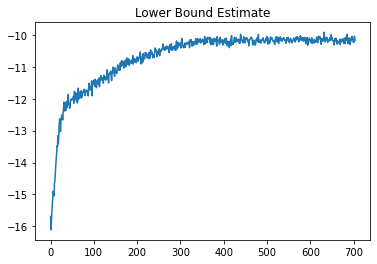

In [46]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:title={'center':'Smoothed Lower Bound Estimate'}>

<Figure size 432x288 with 0 Axes>

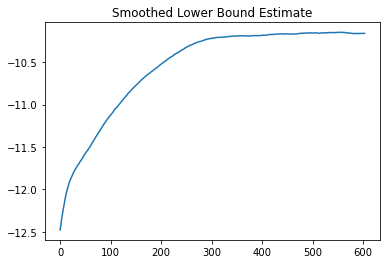

In [47]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [48]:
np.savetxt('vb_lb.txt', LB_estimate)

In [59]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (np.exp(best_theta_tilde[:,1]) - 1) / (np.exp(best_theta_tilde[:,1]) + 1)
best_gamma = np.exp(best_theta_tilde[:,2])
best_delta = best_theta_tilde[:,3]
best_theta = np.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.37156184,  0.23724063,  0.81347929, -0.13545312])

In [61]:
best_mu_untransformed = best_lambda_untransformed[0]
best_vech_l_untransformed = list(best_lambda_untransformed[1])
best_l_untransformed = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l_untransformed[i:num_coeffs,i] = best_vech_l_untransformed[:num_coeffs - i]
    del best_vech_l_untransformed[:num_coeffs-i]
best_Sigma_untransformed =  np.linalg.inv(best_l_untransformed @ best_l_untransformed.T)

best_theta_tilde_untransformed = multivariate_normal.rvs(mean = best_mu_untransformed, cov = best_Sigma_untransformed, size = 1000)
best_alpha_untransformed = (2 * np.exp(best_theta_tilde_untransformed[:,0]) + 1.1) / (1 + np.exp(best_theta_tilde_untransformed[:,0]))
best_beta_untransformed = (np.exp(best_theta_tilde_untransformed[:,1]) - 1) / (np.exp(best_theta_tilde_untransformed[:,1]) + 1)
best_gamma_untransformed = np.exp(best_theta_tilde_untransformed[:,2])
best_delta_untransformed = best_theta_tilde_untransformed[:,3]
best_theta_untransformed = np.array([best_alpha_untransformed, best_beta_untransformed, best_gamma_untransformed, best_delta_untransformed])
posterior_mean_estimate_untransformed = np.mean(best_theta_untransformed, axis = 1)
posterior_mean_estimate_untransformed

array([ 1.35886925,  0.21337079,  0.81397604, -0.18274972])

Text(0.5, 1.0, 'Posterior density of alpha')

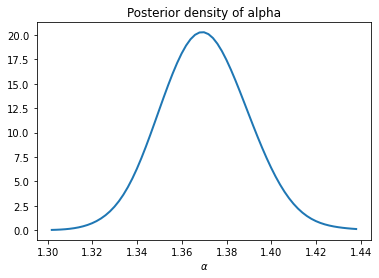

In [50]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of alpha')

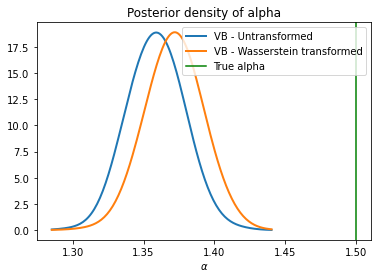

In [75]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_alpha_untransformed)-4*np.std(best_alpha_untransformed),np.mean(best_alpha)-4*np.std(best_alpha)), max(np.mean(best_alpha_untransformed)+4*np.std(best_alpha_untransformed), np.mean(best_alpha)+4*np.std(best_alpha)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0125, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde_vb_untransformed.fit(best_alpha_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - Untransformed')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - Wasserstein transformed')
# only one line may be specified; full height
plt.axvline(x = 1.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'g', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')


Text(0.5, 1.0, 'Posterior density of beta')

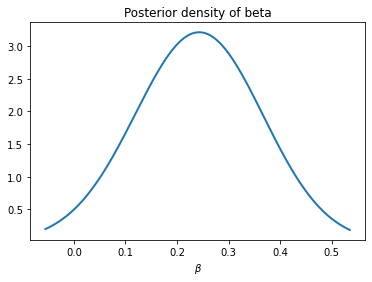

In [51]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of beta')

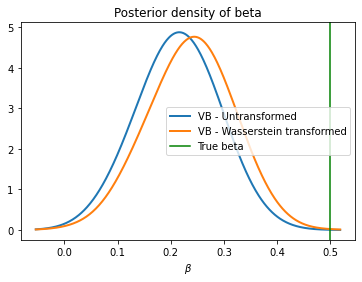

In [81]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_beta_untransformed)-4*np.std(best_beta_untransformed),np.mean(best_beta)-4*np.std(best_beta)), max(np.mean(best_beta_untransformed)+4*np.std(best_beta_untransformed), np.mean(best_beta)+4*np.std(best_beta)), 0.001)

kde_vb = KernelDensity(bandwidth=0.045, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.0455, kernel='gaussian')
kde_vb_untransformed.fit(best_beta_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - Untransformed')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - Wasserstein transformed')
# only one line may be specified; full height
plt.axvline(x = 0.5, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'g', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

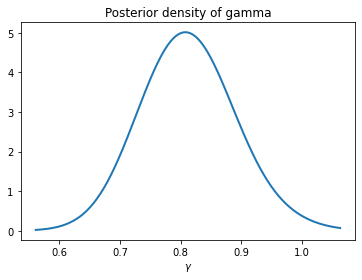

In [52]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of gamma')

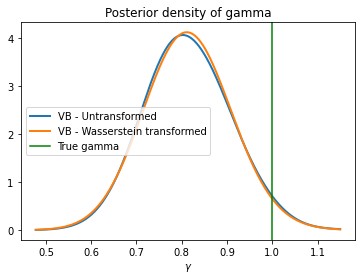

In [93]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_gamma_untransformed)-4*np.std(best_gamma_untransformed),np.mean(best_gamma)-4*np.std(best_gamma)), max(np.mean(best_gamma_untransformed)+4*np.std(best_gamma_untransformed), np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0755, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde_vb_untransformed.fit(best_gamma_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - Untransformed')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - Wasserstein transformed')
# only one line may be specified; full height
plt.axvline(x = 1, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'g', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

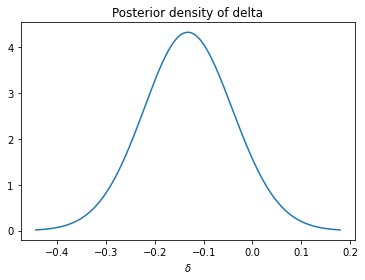

In [53]:
plt.figure()
x_plot = np.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.05, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')

Text(0.5, 1.0, 'Posterior density of delta')

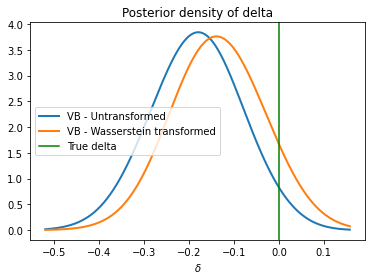

In [95]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(np.mean(best_delta_untransformed)-4*np.std(best_delta_untransformed),np.mean(best_delta)-4*np.std(best_delta)), max(np.mean(best_delta_untransformed)+4*np.std(best_delta_untransformed), np.mean(best_delta)+4*np.std(best_delta)), 0.001)

kde_vb = KernelDensity(bandwidth=0.0755, kernel='gaussian')
kde_vb.fit(best_delta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb_untransformed = KernelDensity(bandwidth=0.06, kernel='gaussian')
kde_vb_untransformed.fit(best_delta_untransformed.reshape(-1, 1))
y_plot_vb_untransformed = kde_vb_untransformed.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_vb_untransformed), '-', linewidth=2.0, label = 'VB - Untransformed')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - Wasserstein transformed')
# only one line may be specified; full height
plt.axvline(x = 0, ymin = 0, ymax = max(y_plot_vb_untransformed), color = 'g', label = 'True delta')

plt.legend()
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')